In [15]:
#1/30/24 Calculate RMSD for poses- last entry of xt
#Confirm matches last entry in csv file
#Also look into csv file statistics
#Thank you Hannes for advice!
#1/31/24 from RMSD_Calc_Poses_240130_1820, streamline to make all plots in 1 doc
#2/1/24 from Streamline_Analysis_240131_1535, update to use PDB bonds only as the bonds analyzed, to prepare for consensus distance analysis
#2/4/24 from Streamline_Analysis_240201_2050, to add in conformer analysis
#2/5/24 from Streamline_Analysis_240204_1730, to add in centralized function and obtain test train histogram
#2/5/24 from Streamline_Analysis_240205_1200 add in SD sensitivity anlysis
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem import AllChem, GetPeriodicTable, RemoveHs
from rdkit.Chem import Descriptors
from rdkit.Chem import rdDistGeom
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
from scipy import stats
import torch
from torch_scatter import scatter_mean

In [16]:
#Copied from https://github.com/gcorso/DiffDock/blob/main/datasets/process_mols.py
def read_molecule(molecule_file, sanitize=False, calc_charges=False, remove_hs=False):
    if molecule_file.endswith('.mol2'):
        mol = Chem.MolFromMol2File(molecule_file, sanitize=False, removeHs=False)
    elif molecule_file.endswith('.sdf'):
        supplier = Chem.SDMolSupplier(molecule_file, sanitize=False, removeHs=False)
        mol = supplier[0]
    elif molecule_file.endswith('.pdbqt'):
        with open(molecule_file) as file:
            pdbqt_data = file.readlines()
        pdb_block = ''
        for line in pdbqt_data:
            pdb_block += '{}\n'.format(line[:66])
        mol = Chem.MolFromPDBBlock(pdb_block, sanitize=False, removeHs=False)
    elif molecule_file.endswith('.pdb'):
        mol = Chem.MolFromPDBFile(molecule_file, sanitize=False, removeHs=False)
    else:
        raise ValueError('Expect the format of the molecule_file to be '
                         'one of .mol2, .sdf, .pdbqt and .pdb, got {}'.format(molecule_file))

    try:
        if sanitize or calc_charges:
            Chem.SanitizeMol(mol)

        if calc_charges:
            # Compute Gasteiger charges on the molecule.
            try:
                AllChem.ComputeGasteigerCharges(mol)
            except:
                warnings.warn('Unable to compute charges for the molecule.')

        if remove_hs:
            mol = Chem.RemoveHs(mol, sanitize=sanitize)
    except Exception as e:
        print(e)
        print("RDKit was unable to read the molecule.")
        return None

    return mol

In [17]:
#########
#Find rmsd w/o pytorch
#Ref https://en.wikipedia.org/wiki/Root-mean-square_deviation_of_atomic_positions
#Ref https://github.com/HannesStark/FlowSite/blob/main/utils/train_utils.py
#Input:
#(a) c1 1st coords
#(b) c2 2nd coords
#Output: rmsd
#########
def rmsd_calc_no_torch(c1, c2):
    
    #Find difference in each atom's coordinates, find distance, square each distance
    #Sum squares, divide by atom count, take resulting square root
    coord_diff = c1 - c2
    coord_dist = np.linalg.norm(coord_diff, axis = 1)
    coord_dist_sq = coord_dist ** 2
    sum_sq = np.sum(coord_dist_sq)
    rmsd = (sum_sq / len(coord_diff)) ** 0.5
    return rmsd

In [18]:
#########
#Convert to scientific notation to clean
#Copied this from https://stackoverflow.com/questions/29260893/convert-to-scientific-notation-in-python-a-×-10b
#Input:
#(a) number to convert
#Output: number in scientific notation format
#########
def sci_notation(number, sig_fig = 3):
    ret_string = "{0:.{1:d}e}".format(number, sig_fig)
    a, b = ret_string.split("e")
    # remove leading "+" and strip leading zeros
    b = int(b)
    #Ref https://stackoverflow.com/questions/21226868/superscript-in-python-plots for plot
    return a + "*$10^{" + str(b) + "}$"

In [19]:
#########
#Calculate ligand properties
#Input:
#(a) lcalcpdb_no_h ligand from pdb, w/o Hs
#(b) lcalc_inf ligand from inference
#Output:
#(a) lprop_dict dictionary with keys of property names and values of properties
#########
def lprop_calc(lcalcpdb_no_h, lcalc_inf):
    
    #Keys are name of properties, and values the properties
    lprop_dict = {}
    
    #Heavy atom and rotatable bond count
    #Ref https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html
    lprop_dict["Heavy_Atom_Count"] = rdkit.Chem.rdMolDescriptors.CalcNumHeavyAtoms(lcalcpdb_no_h)
    lprop_dict["Rot_Bonds"] = rdkit.Chem.rdMolDescriptors.CalcNumRotatableBonds(lcalcpdb_no_h)
    
    #Radius of gyration
    #Ref https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors3D.html
    rg_pdb = rdkit.Chem.Descriptors3D.RadiusOfGyration(lcalcpdb_no_h)
    lprop_dict["Rg_PDB"] = rg_pdb
    
    #Additional analyses if working with inference pose
    if lcalc_inf is not None:
        
        #Check heavy atom count is equal
        if rdkit.Chem.rdMolDescriptors.CalcNumHeavyAtoms(lcalcpdb_no_h) != rdkit.Chem.rdMolDescriptors.CalcNumHeavyAtoms(lcalc_inf):
            print("GetNumHeavyAtomsISSUE")

        #Radius of gyration percent error
        rg_inf = rdkit.Chem.Descriptors3D.RadiusOfGyration(lcalc_inf)
        rg_pct_error = 100.0 * (rg_inf - rg_pdb) / rg_pdb
        lprop_dict["Rg_Inf"] = rg_inf
        lprop_dict["Rg_Percent_Error"] = rg_pct_error
    
    return lprop_dict

In [20]:
#######
#Confirm atom ordering is correct, from Distance_Pct_Error_240129
#Note this is not perfect - just a check of elements, not atom names or smarts
#Input:
#(a) hfc HF ligand checking
#(b) pdbc PDB ligand checking 
#######
def check_atoms(hfc, pdbc):

    #element and atom id lists
    hf_at_el = []
    pdb_at_el = []
    hf_at_id = []
    pdb_at_id = []
    
    #Record atom info in each list
    #Get ID ref https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html, https://www.rdkit.org/docs/cppapi/classRDKit_1_1Atom.html
    #Could also explore https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html#rdkit.Chem.rdchem.Atom.GetProp
    for hfa in hfc.GetAtoms():
        hf_at_id.append(hfa.GetIdx())
        hf_at_el.append(hfa.GetAtomicNum())
    for pdba in pdbc.GetAtoms():
        pdb_at_id.append(pdba.GetIdx())
        pdb_at_el.append(pdba.GetAtomicNum())
        
    '''
    print("lists")
    print("hf at id")
    print(hf_at_id)
    print("pdb at id")
    print(pdb_at_id)
    print("hf elements")
    print(hf_at_el)
    print("pdb elements")
    print(pdb_at_el)
    '''
    
    #Compare
    for ha, pa in zip(hf_at_id, pdb_at_id):
        if ha != pa:
            print("ISSUE WITH INDEXING-IDS")
    for he, pe in zip(hf_at_el, pdb_at_el):
        if ha != pa:
            print("ISSUE WITH INDEXING-ELEMENTS")

In [21]:
#######
#2/1/24
#Distance calculation- revising because will do separately for HF
#Input:
#(a) lfordcalc ligand
#(b) posfordcalc positions
#(c) a1fordcalc atom 1 for calculation
#(d) a2fordcalc atom 2 for calculation
#Output
#(a) at1_atnum the atomic number of 1st atom
#(b) at2_atnum the atomic number of 2nd atom
#(c) calc_distance distance between atoms
#######
def dist_calc(lfordcalc, posfordcalc, a1fordcalc, a2fordcalc):
            
    #Record elements
    at1_atnum = lfordcalc.GetAtoms()[a1fordcalc].GetAtomicNum()
    at2_atnum = lfordcalc.GetAtoms()[a2fordcalc].GetAtomicNum()
    #b_dict[b_key]["elements"] = [at1_atnum, at2_atnum]

    #Positions and distance and record
    at_1_position = posfordcalc[a1fordcalc]
    at_2_position = posfordcalc[a2fordcalc]
    #Ref https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
    calc_distance = np.linalg.norm(at_1_position - at_2_position)
    #b_dict[b_key]["distance"] = bond_distance

    return at1_atnum, at2_atnum, calc_distance

In [22]:
#######
#Find all distances of interest, from Distance_Pct_Error_240129
#2/1/24 revise to call dist_calc so can work with pdb and inference/conformers separately
#Input:
#(a) confd conformer for distance calc
#(b) ligd ligand for distance calc
#(c) get_bonds_bool whether want to calculate distances from bonds
#(d) atom_pair_list atom pairs for distances- only specify if getbondsbool is false
#Output: 
#(a) d_dict distance info dictionary
#Ref https://www.rdkit.org/docs/GettingStartedInPython.html
#######
def obtain_dist_data(confd, 
                     ligd, 
                     get_bonds_bool, 
                     atom_pair_list):
    
    if (atom_pair_list is not None) and get_bonds_bool:
        print("obtain_dist_data input issue")
    if (atom_pair_list is None) and not get_bonds_bool:
        print("obtain_dist_data input issue")
    #Dictionary of keys of atom ids
    #Values of distances, elements
    d_dict = {}
    
    #Conformer coord pull
    
    cf_positions = confd.GetPositions()
    
    #Assemble list of atom ids in bonds if want to work w/bonds
    if get_bonds_bool:
        bond_list = []
        for b_rec in ligd.GetBonds():
            #Get atom IDs
            at1b = b_rec.GetBeginAtomIdx()
            at2b = b_rec.GetEndAtomIdx()
            bond_list.append(tuple(sorted([at1b, at2b])))
        
        pairs_calc = bond_list
        
    #Otherwise work with atom pairs
    else:
        pairs_calc = atom_pair_list
        
    #Iterate over pairs
    for ap in pairs_calc:
        
        #Sort and make possible dictionary entry
        d_key = tuple(sorted([ap[0], ap[1]]))
                      
        #For checking make 1st entry the lower atom id
        at1r = d_key[0]
        at2r = d_key[1]
        
        #Record elements and distance if heavy atom
        an1, an2, dval = dist_calc(ligd, cf_positions, at1r, at2r)
        if an1 > 1 and an2 > 1:
            d_dict[d_key] = {}
            d_dict[d_key]["elements"] = [an1, an2]
            d_dict[d_key]["distance"] = dval
        else:
            print(f"HYDROGENISSUE {an1} and {an2} atomic numbers for {at1r} and {at2r}")
        
    return d_dict

In [23]:
#########
#Calculate all bonded distance percent errors, from Distance_Pct_Error_240129
#2/1/24 update to efine set of bonds as all PDB bonds and only PDB bonds
#Ref https://github.com/rdkit/rdkit/issues/1982
#Ref https://www.rdkit.org/docs/GettingStartedInPython.html
#Input:
#(a) l_bpe_pdb ligand structure from pdb
#(b) l_bpe_inf ligand structure from inference
#Output:
#(a) pct_err_list list of each bond's percent error
#(b) pct_err_dict dictionary with keys of bond percent error metrics and values of the metrics
#(c) avg_bond_pe averae bond percent error
#########
def bond_percent_error_calc(l_bpe_pdb, l_bpe_inf):
    
    #Confirm comparing atoms correctly
    #Thank you Hannes for also indicating in 1/30/24 conversation atom indexing should not change
    #So while this check is not perfect, its always succeeding plus Hannes remarks imply going by atom ids should be alright
    check_atoms(l_bpe_inf, l_bpe_pdb)
    
    #Find all bond distances for inference and pdbbind
    #Ref https://github.com/HannesStark/EquiBind/blob/41bd00fd6801b95d2cf6c4d300cd76ae5e6dab5e/commons/process_mols.py helped process conformers
    distances_hf_list = []
    distance_pdb_list = []
    if len(l_bpe_inf.GetConformers()) > 1:
        print("HF conf PBM")
    if len(l_bpe_pdb.GetConformers()) > 1:
        print("PDB conf PBM")
    
    bd_pdb = obtain_dist_data(l_bpe_pdb.GetConformers()[0], l_bpe_pdb, True, None)
    pdb_bonds = list(bd_pdb.keys())
    bd_hf = obtain_dist_data(l_bpe_inf.GetConformers()[0], l_bpe_inf, False, pdb_bonds)

    #find bonds in both dictionaries
    #confirm same elements
    #Find distances and percent error
    bonds_in_only_hf = [b for b in list(bd_hf.keys()) if b not in list(bd_pdb.keys())]
    bonds_in_only_pdb = [b for b in list(bd_pdb.keys()) if b not in list(bd_hf.keys())]
    if (len(bonds_in_only_hf) > 0) or (len(bonds_in_only_pdb) > 0):
        print("BOND MISMATCH PROBLEM")
    pct_err_dict = {} #Dictionary of percent errors
    pct_err_list = [] #List of percent errors
    
    #Find percent error of each bond
    for bc in bd_pdb.keys():
        #element check
        if (bd_hf[bc]["elements"][0] != bd_pdb[bc]["elements"][0]) or (bd_hf[bc]["elements"][1] != bd_pdb[bc]["elements"][1]):
            print("ELEMENT MISMATCH PROBLEM,inference and pdb compare")
            print(bc)
            print("HF")
            print(bd_hf[bc]["elements"])
            print("PDB")
            print(bd_pdb[bc]["elements"])

        #percent error calc
        dist_pdb = bd_pdb[bc]["distance"]
        dist_hf = bd_hf[bc]["distance"]
        dist_pct_error = 100.0 * (dist_hf - dist_pdb) / dist_pdb
        '''
        print("***********")
        print("ids")
        print(bc)
        print("elements involved")
        print(bd_hf[bc]["elements"])
        print(f"pdb dist {dist_pdb}")
        print(f"hf dist {dist_hf}")
        print(f"pct error {dist_pct_error}")
        '''
        pct_err_list.append(dist_pct_error)
        pct_err_dict[bc] = {"inf" : dist_hf, "pdb" : dist_pdb, "pe" : dist_pct_error}
        
    #Now average
    avg_bond_pe = np.average(pct_err_list)
    
    return pct_err_list, pct_err_dict, avg_bond_pe

In [24]:
############
#Conformer generation
#2/1/24 13:40 update to redo rdkit generation if under 10 conformers, try w/random coords 1st
#Copied/slightly modified from https://github.com/HannesStark/EquiBind/blob/41bd00fd6801b95d2cf6c4d300cd76ae5e6dab5e/commons/process_mols.py#L447
#Thank you Jeremy Wohlwend for advice!
#copied from ps down to conformers.append with some edits
#Also relevant/consulted:
#Ref https://iwatobipen.wordpress.com/2021/01/31/generate-conformers-script-with-rdkit-rdkit-chemoinformatics/
#Ref https://greglandrum.github.io/rdkit-blog/posts/2023-02-04-working-with-conformers.htmlR
#Ref https://www.rdkit.org/docs/source/rdkit.Chem.rdDistGeom.html for random seed
#Ref https://github.com/rdkit/rdkit/issues/2575, https://github.com/rdkit/rdkit/discussions/6489, https://github.com/rdkit/rdkit/discussions/4623
#Ref https://github.com/rdkit/rdkit/discussions/5400 helped with figuring out a deterministic approach
#I think I only need 1 seed because I am generating all conformers at once
#Input:
#(a) l_c_gen molecule for conformer generation, believe needs Hs
#(b) cdir dir for saving conformer structures
#(c) cname complex name
#(d) count_conf how many conformers want
#Output:
#(a) conformers list of conformer coordinates
############
def generate_conformers(l_c_gen, cdir, cname, count_conf):

    ps = AllChem.ETKDGv2()
    
    #Update code so it will be deterministic unless error and to add more attempts
    #Ref https://github.com/rdkit/rdkit/issues/2536
    #Ref https://www.rdkit.org/docs/source/rdkit.Chem.rdDistGeom.html#rdkit.Chem.rdDistGeom.EmbedParameters
    ps.randomSeed = 5
    ps.maxAttempts = 10
    
    ids = rdDistGeom.EmbedMultipleConfs(l_c_gen, count_conf, ps)
    if (-1 in ids) or (len(list(ids)) < count_conf): #Edit here so this is now run if have under 10 conformers, 2/1/24 13:40
        print('rdkit coords could not be generated without using random coords. using random coords now.')
        ps.useRandomCoords = True
        ids = rdDistGeom.EmbedMultipleConfs(l_c_gen, count_conf, ps)
        AllChem.MMFFOptimizeMoleculeConfs(l_c_gen)
    else:
        AllChem.MMFFOptimizeMoleculeConfs(l_c_gen)
    conformers = []
    print("ids are:")
    print(list(ids))
    for i in range(count_conf):
        conformers.append(l_c_gen.GetConformer(i).GetPositions())
        
    #Save if want to
    #Copied writer code from https://stackoverflow.com/questions/69564484/how-to-save-rdkit-conformer-object-into-a-sdf-file
    if cdir is not None:
        cwriter = Chem.SDWriter(f"{cdir}/{cname}_confs.sdf")
        for cid in range(l_c_gen.GetNumConformers()):
            cwriter.write(l_c_gen, confId=cid)
        
    return conformers

In [25]:
############
#Obtain long range distances from dictionary
#Input:
#(a) d_lr_calc dictionary for LR distance calc
#Output:
#(a) lr_p_list list of lr pairs
############
def lr_list_from_dict(d_lr_calc):
    
    #Initialize list
    lr_p_list = []
    
    #Each atom iterate
    for a_lr_1 in d_lr_calc.keys():
        
        #Each further away atom relative to it iterate
        for a_lr_2 in d_lr_calc[a_lr_1]:
            
            #Sorted pair
            pair_sorted = sorted((a_lr_1, a_lr_2))
            if pair_sorted not in lr_p_list:
                lr_p_list.append(pair_sorted)
                
    return lr_p_list

In [26]:
############
#Work through bonds and find which pairs of atoms have 3+ bonds separating them
#TODO TODO TODO MUST CONFIRM HS ALWAYS AT END
#Input:
#(a) l_find_lr ligand for finding longer-range pairs
#(b) l_bonds list of ligand bonds
#Output:
#(a) lr_pairs list of pairs separated by 3+ bonds
############
def find_lr_pairs(l_find_lr, l_bonds):
    lr_pairs = []
    
    #A. Find all heavy. atoms
    #Ref https://www.rdkit.org/docs/GettingStartedInPython.html
    heavy_atom_list = []

    #Record all heavy atoms
    for a in l_find_lr.GetAtoms():
        if a.GetAtomicNum() > 1:
            #print(f"found atom {a.GetSymbol()}")
            heavy_atom_list.append(a.GetIdx())
            
    #B. Dictionary of bonded atoms for each atom
    heavy_atom_bonds_dict = {}
    for ah in heavy_atom_list:
        
        #Atom is key
        heavy_atom_bonds_dict[ah] = []
        
        #All bonds with atom- record other partner
        for bcheck in l_bonds:
            if ah in bcheck:
                if bcheck[0] == ah:
                    heavy_atom_bonds_dict[ah].append(bcheck[1])
                if bcheck[1] == ah:
                    heavy_atom_bonds_dict[ah].append(bcheck[0])
    #print("bond dict")
    #print(heavy_atom_bonds_dict)
    
    #C Dictionary of 2 away for each atom
    heavy_atom_2_away_dict = {}
    
    for ah2 in heavy_atom_list:
        heavy_atom_2_away_dict[ah2] = []
        
        #Bonded neighbors
        for ah2_bp in heavy_atom_bonds_dict[ah2]:
            
            #Their bonded neighbors
            for ah2_bp_2 in heavy_atom_bonds_dict[ah2_bp]:
                
                #Remove the atom itself and anything already in the bonded list or already in 2 away list
                if (ah2 != ah2_bp_2) and (ah2_bp_2 not in heavy_atom_bonds_dict[ah2]) and (ah2_bp_2 not in heavy_atom_2_away_dict[ah2]):
                    heavy_atom_2_away_dict[ah2].append(ah2_bp_2)
                    
    #print("2 away dict")
    #print(heavy_atom_2_away_dict)
    
    #D Dictionary of 3+ away for each atom
    heavy_atom_lr_dict = {}
    for ahlr in heavy_atom_list:
        
        #all 1 and 2 away plus atom itself
        close_list = heavy_atom_bonds_dict[ahlr] + heavy_atom_2_away_dict[ahlr] + [ahlr]
        
        #this list is everything except for what is 1 or 2 away
        heavy_atom_lr_dict[ahlr] = [hc for hc in heavy_atom_list if hc not in close_list]
        
    #print("3 away dict")
    #print(heavy_atom_lr_dict)
    
    #E List from dictionary
    lr_pairs = lr_list_from_dict(heavy_atom_lr_dict)
    #print("longer range pair list")
    #print(lr_pairs)
    
    return lr_pairs

In [27]:
############
#Determine which distances have a low enough standard deviation to be consensus distances
#Input
#(a) conf_sum_d dictionary with information for each distance's value in the conformer ensemble
#(b) consensus_sd_val threshold below which a distance is a consensus distance
#Output
#(a) consensus_d_list list of distances with low sds, representing consensus distances
#(b) len(consensus_d_list) how many distances are consensus ones
############
def find_consensus_dist(conf_sum_d, consensus_sd_val):
    consensus_d_list = []
    
    #Iterate over each distance, if sd is low enough add to list
    for lr_dist_check_c in conf_sum_d.keys():
        if conf_sum_d[lr_dist_check_c]["sd"] < consensus_sd_val:
            consensus_d_list.append(lr_dist_check_c)
            
    return consensus_d_list, len(consensus_d_list)

In [79]:
############
#2/1/24 19:30 centralize analysis of conformers
#Generate conformers and determine consensus distances and % error relative to pdb
#Input:
#(a) l_for_conf ligand for conformer analysis - should have hydrogens ref https://greglandrum.github.io/rdkit-blog/posts/2023-02-04-working-with-conformers.html
#(b) dir_c directory for results
#(c) name_c name of complex
#(d) c_bonds bonded atom list of conformer
#(e) l_from_inference ligand from inference for % error calculation. It may not have Hs, so I run checks of atom numbering
#(f) list_sd_thresholds list of SD thresholds for conensus
#Output:
#(a) consensus_dist_count count of consensus distances from conformer analysis
#(b) dict_of_sd_threshold_results consensus distance information for each sd cutoff. In particular this includes:
#(i) consensus_dist_pe_list_conf list of percent error of consensus distances- conformer average relative to pdb value
#(ii) consensus_dist_pe_list_inf list of percent error of consensus distances- inference relative to pdb value
#(iii) consensus_dist_pe_dict dictionary with percent error info
#(iv) all_pair_sd_list list of all pairs' standard deviations
############
def analyze_conformers(l_for_conf, 
                       dir_c, 
                       name_c, 
                       c_bonds, 
                       l_from_inference, 
                       list_sd_thresholds):
    
    if len(l_from_inference.GetConformers()) > 1:
        print("HF conf PBM")
    if len(l_for_conf.GetConformers()) > 1:
        print("PDB conf PBM")
    
    ############
    #A. Process structure
    ############
    #Find all heavy atom pairs 3 or more bonds away from each other
    heavy_atom_pairs_lr = find_lr_pairs(l_for_conf, c_bonds)
    
    if len(l_for_conf.GetConformers()) > 1:
        print("PDB conf PBM,for conf. gen.")
        
    #Find PDB pose distances for each pair
    pdb_lr_dist_dict = obtain_dist_data(l_for_conf.GetConformers()[0], 
                                        l_for_conf, 
                                        False, 
                                        heavy_atom_pairs_lr)
    
    ############
    #B. Generate conformers
    ############
    conf_num = 10
    conf = generate_conformers(l_for_conf, dir_c, name_c, conf_num)
    print(f"conf gen for {name_c}")
    if len(conf) < 10:
        print("Issue:too few conformers")
     
    ############
    #C. Find long range distances for each conformer
    ############
    #Dictionary with conformers as key
    #Each conformer has its own dictionary
    #Values are the distance dictionaries from obtain_dist_data
    conf_lr_dist_dict = {}
    for c in range(len(conf)):
        conf_lr_dist_dict[c] = obtain_dist_data(l_for_conf.GetConformers()[c], 
                                                l_for_conf, 
                                                False,
                                                heavy_atom_pairs_lr)
        
        #only output a couple keys- huge files
        '''
        print(f"conf {c} long range distance dictionary check")
        conf_lr_dist_dict_keys = list(conf_lr_dist_dict[c].keys())
        print("key 1")
        print(conf_lr_dist_dict_keys[0])
        print(conf_lr_dist_dict[c][conf_lr_dist_dict_keys[0]])
        print("last key")
        print(conf_lr_dist_dict_keys[-1])
        print(conf_lr_dist_dict[c][conf_lr_dist_dict_keys[-1]])
        '''
    #Now create dictionary of summary stats for each lr distance
    #Keys- atom pairs
    #Values- dictionaries with the distance for each conformer, plus the average and standard deviation
    conformer_summary_dict = {}
    
    #Add on list of all sds to show distribution
    all_pair_sd_list = []
    
    #Record info for each pair
    for ha_pair_lr in heavy_atom_pairs_lr:
        
        #Set up tuple
        ha_pair_sort = sorted(ha_pair_lr)
        ha_pair_sort_0 = ha_pair_sort[0]
        ha_pair_sort_1 = ha_pair_sort[1]
        ha_pair_lr_key = (ha_pair_sort_0, ha_pair_sort_1)
        
        #Dictionary setup
        conformer_summary_dict[ha_pair_lr_key] = {}
        
        #Find the distance of interest in each conformer
        conf_dist_list = [conf_lr_dist_dict[c_add][ha_pair_lr_key]["distance"] for c_add in conf_lr_dist_dict.keys()]
        
        #Also confirm elements match
        for c_el_check in conf_lr_dist_dict.keys(): #For each conformer
            
            #Find relevant elements
            c_el_check_lr_elements = conf_lr_dist_dict[c_el_check][ha_pair_lr_key]["elements"]
            
            #Compare to elements for PDB distance
            if (c_el_check_lr_elements[0] != pdb_lr_dist_dict[ha_pair_lr_key]["elements"][0]) or (c_el_check_lr_elements[1] != pdb_lr_dist_dict[ha_pair_lr_key]["elements"][1]):
                print("ELEMENT MISMATCH PROBLEM,conformers and pdb compare")
                print(ha_pair_lr)
                print("CONF")
                print(c_el_check_lr_elements)
                print("PDB")
                print(pdb_lr_dist_dict[ha_pair_lr_key]["elements"])
        
        #Record whole list, find summary statistics
        conformer_summary_dict[ha_pair_lr_key]["distance_list"] = conf_dist_list
        conformer_summary_dict[ha_pair_lr_key]["avg"] = np.average(conf_dist_list)
        sd_across_confs = np.std(conf_dist_list, ddof = 1)
        conformer_summary_dict[ha_pair_lr_key]["sd"] = sd_across_confs
        
        all_pair_sd_list.append(sd_across_confs)
        
    #print("conformer summary dictionary")
    #print(conformer_summary_dict)
    print("**********************************")
    
    ############
    #D Find how many distances are consensus distances, find consensus distance % error for conformers
    ############
    #Find the consensus distances information- for different SD thresholds    
    #To hold results at different thresholds
    dict_of_sd_threshold_results = {}
    for consensus_sd_threshold in list_sd_thresholds:
        
        dict_of_sd_threshold_results[consensus_sd_threshold] = {}
        consensus_dist_list, consensus_dist_count = find_consensus_dist(conformer_summary_dict, consensus_sd_threshold)

        #Find percent error of each consensus distance
        consensus_dist_pe_dict = {}
        consensus_dist_pe_list_conf = []
        for cd in consensus_dist_list:
            conf_consensus_val = conformer_summary_dict[cd]["avg"]
            conf_consensus_sd = conformer_summary_dict[cd]["sd"]
            pdb_consensus_val = pdb_lr_dist_dict[cd]["distance"]
            pe_conf_pdb = 100.0 * (conf_consensus_val - pdb_consensus_val) / pdb_consensus_val
            consensus_dist_pe_dict[cd] = {"pdb" : pdb_consensus_val,
                                     "conformers" : conf_consensus_val,
                                     "pdb_conf_pe" : pe_conf_pdb,
                                     "conf_sd" : conf_consensus_sd}
            consensus_dist_pe_list_conf.append(pe_conf_pdb)


        ############
        #E For each consensus distance also find % error for inference
        ############    
        #Run check to make sure atom numbering is ok- that Hs are just at the end, heavy atom ordering is the same
        #print("HF vs PDB w/H atom check")
        check_atoms(l_from_inference, l_for_conf)

        #Find the consensus distance atom pairs' distance values in the inference output
        inference_consensus_dist_dict = obtain_dist_data(l_from_inference.GetConformers()[0], 
                                                         l_from_inference, 
                                                         False,
                                                         consensus_dist_list)

        #List of consensus distance values in inference pose
        consensus_dist_pe_list_inf = []

        #Repeat percent error calculation, but now compare inference- not conformer average- to PDB
        for icd in inference_consensus_dist_dict.keys():

            #Confirm elements are the same
            inference_elements = inference_consensus_dist_dict[icd]["elements"]
            pdb_elements = pdb_lr_dist_dict[icd]["elements"]
            if (inference_elements[0] != pdb_elements[0]) or (inference_elements[1] != pdb_elements[1]):
                print("ELEMENT MISMATCH PROBLEM,inference and pdb compare")
                print(icd)
                print("INFERENCE")
                print(inference_elements)
                print("PDB")
                print(pdb_elements)

            #Find inference distance and compute percent error relative to pdb
            inference_dist_value = inference_consensus_dist_dict[icd]["distance"]
            pdb_for_inf_pe = consensus_dist_pe_dict[icd]["pdb"]
            inf_pe_rel_to_pdb = 100.0 * (inference_dist_value - pdb_for_inf_pe) / pdb_for_inf_pe
            consensus_dist_pe_dict[icd]["inf"] = inference_dist_value
            consensus_dist_pe_dict[icd]["pdb_inf_pe"] = inf_pe_rel_to_pdb
            consensus_dist_pe_list_inf.append(inf_pe_rel_to_pdb)

        #Now record for this sd threshold
        dict_of_sd_threshold_results[consensus_sd_threshold]["consensus_dist_count"] = consensus_dist_count
        dict_of_sd_threshold_results[consensus_sd_threshold]["consensus_dist_pe_dict"] = consensus_dist_pe_dict
        dict_of_sd_threshold_results[consensus_sd_threshold]["consensus_dist_pe_list_conf"] = consensus_dist_pe_list_conf
        dict_of_sd_threshold_results[consensus_sd_threshold]["consensus_dist_pe_list_inf"] = consensus_dist_pe_list_inf
        '''
        print(f"{name_c} consensus distances dictionary")
        print(consensus_dist_pe_dict)
        print(f"how many consensus distances? {consensus_dist_count}")
        print("consensus distance pe list- relative to conformers")
        print(consensus_dist_pe_list_conf)
        print("consensus distance pe list- relative to inference")
        print(consensus_dist_pe_list_inf)
        print("sd max")
        print(max([conformer_summary_dict[d_report]['sd'] for d_report in list(consensus_dist_pe_dict.keys())]))
        print("all pair sd list")
        print(all_pair_sd_list)
        '''
    return dict_of_sd_threshold_results, all_pair_sd_list

In [80]:
#########
#Scatterplot
#(a) xdat x vals for points
#(b) ydat y vals for points
#(c) xlabel x axis label
#(d) ylabel y axis label
#(e) color_scatter color for plot
#(f) dsc dir for scatterplot
#(g) strsc string for scatterplot
#########
def create_scatter(xdat, 
                   ydat, 
                   xlabel, 
                   ylabel, 
                   color_scatter,
                   dsc,
                   strsc):
    
    print("x values plot")
    print(xdat)
    print("y values plot")
    print(ydat)
    fp, ap = plt.subplots()
    plt.scatter(xdat, ydat, alpha = 0.7, color = color_scatter)
    plt.xlabel(xlabel, fontsize = 20)
    plt.ylabel(ylabel, fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    
    #Thank you Jeremy Wohlwend for Spearman R advice!
    #Ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
    #TODO remove p values or note not perfect for this context bcs have under 500 points
    spearman_r = scipy.stats.spearmanr(xdat, ydat)
    print("Spearman R 3 formats")
    print(f"raw {spearman_r[1]}")
    print(f".3e {spearman_r[1]:.3e}")
    print(f"sci. not. {sci_notation(spearman_r[1])}")
    spearman_r_sci_not = sci_notation(spearman_r[1])
    #Ref https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html
    #Ref https://www.adamsmith.haus/python/answers/how-to-print-a-number-in-scientific-notation-in-python
    plt.text(1.02, 0.88, f"Spearman R : {spearman_r[0]:.3f}\np-value : {spearman_r[1]:.3e}\np-value : {spearman_r_sci_not}", transform=ap.transAxes, fontsize = 16)
    #Ref https://stackoverflow.com/questions/55942693/how-do-i-save-the-entire-graph-without-it-being-cut-off
    plt.savefig(f"{dsc}/Scatter_{strsc}.png", bbox_inches = "tight")
    
    plt.show()
    plt.close()
    plt.clf()
    plt.cla()

In [81]:
#########
#Scatterplot- two y values
#Ref https://matplotlib.org/stable/gallery/subplots_axes_and_figures/secondary_axis.html
#Ref https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html
#(a) xdat x vals for points
#(b) ydat1 y vals for points 1st series
#(c) ydat2 y vals for points 2nd series
#(d) xlabel x axis label
#(e) ylabel1 y axis label 1st series
#(f) ylabel2 y axis label 2nd series
#(g) color_scatter1 color for plot 1st series
#(h) color_scatter1 color for plot 2nd series
#(i) dsc2 dir for double scatter
#(j) strsc2 string for double scatter
#########
def create_scatter_2_y(xdat, 
                       ydat1, 
                       ydat2, 
                       xlabel, 
                       ylabel1, 
                       ylabel2, 
                       color_scatter1, 
                       color_scatter2,
                       dsc2,
                       strsc2):
    
    fp, ap = plt.subplots()
    
    print("x values plot")
    print(xdat)
    print("y1 values plot")
    print(ydat1)    
    print("y2 values plot")
    print(ydat2)

    #One plot
    ap.scatter(xdat, ydat1, color = color_scatter1, alpha = 0.5)

    #Second
    ap2 = ap.twinx()
    ap2.scatter(xdat, ydat2, color = color_scatter2, alpha = 0.5)

    ap.set_xlabel(xlabel, fontsize = 20)
    ap.set_ylabel(ylabel1, fontsize = 20, color = color_scatter1)
    ap2.set_ylabel(ylabel2, fontsize = 20, color = color_scatter2)
    ap.tick_params(labelsize = 18)
    ap2.tick_params(labelsize = 18)
    #ap2.yticks(fontsize = 20)
    #print(scipy.stats.spearmanr(avg_d_pe, rg_error))
    y1_spearman = scipy.stats.spearmanr(xdat, ydat1)
    y1_spearman_p = sci_notation(y1_spearman[1])
    y2_spearman = scipy.stats.spearmanr(xdat, ydat2)
    y2_spearman_p = sci_notation(y2_spearman[1])
    plt.text(1.23, 0.50, f"{xlabel} and {ylabel1}\nSpearman R : {y1_spearman[0]:.3f}\np-value : {y1_spearman[1]:.3e}\np-value : {y1_spearman_p}\n{xlabel} and {ylabel2}\nSpearman R : {y2_spearman[0]:.3f}\np-value : {y2_spearman[1]:.3e}\np-value : {y2_spearman_p}", transform=ap.transAxes, fontsize = 16)
    #Ref https://stackoverflow.com/questions/55942693/how-do-i-save-the-entire-graph-without-it-being-cut-off
    plt.savefig(f"{dsc2}/Double_Scatter_{strsc2}.png", bbox_inches = "tight")
    plt.show()
    
    plt.close()
    plt.clf()
    plt.cla()

In [82]:
#########
#Histogram
#(a) hdat data for histogram
#(b) hlabel label for axis
#(c) hcolor color for plot
#(d) hbininf info for bins- dictionary
#(e) dhist dir for saving
#(f) strhist string for histogram
#########
def create_histogram(hdat, 
                     hlabel, 
                     hcolor, 
                     hbininf,
                     dhist,
                     strhist):
    hbins = np.arange(hbininf["min"], hbininf["max"], hbininf["bspace"])
    fhist, ahist = plt.subplots()
    plt.hist(hdat,
             bins = hbins,
             color = hcolor)
    
    plt.text(1.02, 0.50, "$μ$ " + f"{np.average(hdat):.1f}\n" + "$σ$ " + f"{np.std(hdat,ddof = 1):.1f}", transform = ahist.transAxes, fontsize = 16)

    #Ref https://www.delftstack.com/howto/matplotlib/how-to-place-legend-outside-of-the-plot-in-matplotlib/
    #Ref https://stackoverflow.com/questions/25068384/bbox-to-anchor-and-loc-in-matplotlib
    #plt.legend(bbox_to_anchor = (1.02, 1.00), loc = "upper left", fontsize = 15)
    plt.xlabel(hlabel, fontsize = 20)
    plt.ylabel("Frequency", fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    
    #Ref https://stackoverflow.com/questions/55942693/how-do-i-save-the-entire-graph-without-it-being-cut-off
    plt.savefig(f"{dhist}/Histogram_{strhist}.png", bbox_inches = "tight")
    plt.show()
    
    plt.close()
    plt.clf()
    plt.cla()
    
    below_0 = [i for i in hdat if i < 0]
    print(f"{hlabel} has {len(hdat)} entries, {len(below_0)} below 0 for {100.0 * len(below_0) / len(hdat)}% below")

In [83]:
#########
#Histogram with 2 entries
#(a) hdat_list list of data for histogram
#(b) hlabel label for axis
#(c) hcolor_list list of colors for plot
#(d) hbininf info for bins- dictionary
#(e) hdat_labels_list labels for histogram
#(f) norm_boolean whether to normalize
#(g) dhist2 dir for saving
#(h) strhist2 string for saving
#########
def create_histogram_2(hdat_list, 
                       hlabel, 
                       hcolor_list, 
                       hbininf, 
                       hdat_labels_list, 
                       norm_boolean,
                       dhist2,
                       strhist2):
    hbins = np.arange(hbininf["min"], hbininf["max"], hbininf["bspace"])
    fhist, ahist = plt.subplots()
    
    stats_string = ""
    
    for hd_i, hdat_pl in enumerate(hdat_list):
        plt.hist(hdat_pl,
                 bins = hbins,
                 color = hcolor_list[hd_i],
                 label = hdat_labels_list[hd_i],
                 alpha = 0.50)
        stats_for_entry = f"{hdat_labels_list[hd_i]}\n"+"$μ$ "+f"{np.average(hdat_pl):.1f}\n"+"$σ$ "+f"{np.std(hdat_pl,ddof = 1):.1f}\n"
        stats_string += stats_for_entry
    
    plt.text(1.02, 0.27, stats_string, transform = ahist.transAxes, fontsize = 16)
    

    #Ref https://www.delftstack.com/howto/matplotlib/how-to-place-legend-outside-of-the-plot-in-matplotlib/
    #Ref https://stackoverflow.com/questions/25068384/bbox-to-anchor-and-loc-in-matplotlib
    plt.legend(bbox_to_anchor = (1.02, 1.00), loc = "upper left", fontsize = 15)
    plt.xlabel(hlabel, fontsize = 20)
    plt.ylabel("Frequency", fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    
    #Ref https://stackoverflow.com/questions/55942693/how-do-i-save-the-entire-graph-without-it-being-cut-off
    plt.savefig(f"{dhist2}/Hist_2_{strhist2}.png", bbox_inches = "tight")
    
    plt.show()  
    plt.close()
    plt.clf()
    plt.cla()

In [84]:
#########
#Create 1 list from list of lists
#Inputs:
#(a) list_to_consolidate
#Output:
#(a) consolidated_list
#########
def list_consolidate(list_to_consolidate):
    
    consolidated_list = []
    
    for l_add in list_to_consolidate:
        consolidated_list += l_add
    #print("consolidation")
    #print(f"len{len(consolidated_list)}")
    #print(consolidated_list)
    
    return consolidated_list

In [85]:
#########
#Create plots
#Input:
#(a) df_plot dataframe to plot
#(b) rlist list to remove
#(c) pltd dir for saving
#(d) pltstri string with info
#########
def plot_data(df_plot, 
              rlist,
              pltd,
              pltstri):
    
    #########
    #Process, setup
    #########
    #Remove entries do not want
    #Filter removals
    #Ref https://saturncloud.io/blog/how-to-select-rows-from-a-dataframe-based-on-list-values-in-a-column-in-pandas/
    #Ref https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isin.html
    df_removals = df_plot["Complex_Name"].isin(rlist)
    print("what is removed?")
    print(df_plot[df_removals])
    df_after_remove = df_plot[~df_removals]
    
    #Label, color setup
    df_to_label_dict = {"Heavy_Atom_Count" : "Heavy Atom Count",
                        "RMSD" : "RMSD (Å)",
                        "Rot_Bonds" : "Rotatable Bond Count",
                        "Rg_Percent_Error" : "Radius of Gyration % Error",
                        "Bond_Distance_Percent_Error_List" : "Bond Distance % Error",
                        "SD_0.10_Consensus_Distance_Count" : "Count Consensus Distances",
                        "All_LR_SD" : "All Long-Range Dist. Std. Dev. (Å)"}
    
    sc_color_plt_dict = {("Heavy_Atom_Count", "RMSD") : [0.9, 0.9, 0.6],
                      ("Rot_Bonds", "RMSD") : [0.9, 0.6, 0.9],
                      ("Rg_Percent_Error", "RMSD") : [0.6, 0.9, 0.9],
                      ("Rg_Percent_Error", "Heavy_Atom_Count") : [0.6, 0.9, 0.9]}
    
    #########
    #Scatterplots
    #########
    #Scatterplots of drivers
    for dpair in [["Heavy_Atom_Count", "RMSD"], ["Rot_Bonds", "RMSD"], ["Rg_Percent_Error", "RMSD"], ["Rg_Percent_Error", "Heavy_Atom_Count"]]:
        dp0 = dpair[0]
        dp1 = dpair[1]
        
        #Obtain x and dy lists
        x_rem = df_after_remove[dp0]
        y_rem = df_after_remove[dp1]
        
        #Plot
        create_scatter(x_rem, 
                       y_rem, 
                       df_to_label_dict[dp0], 
                       df_to_label_dict[dp1], 
                       sc_color_plt_dict[(dp0, dp1)], 
                       pltd,
                       f"{pltstri}_{dp0}_{dp1}")
        
    #Two y axis scatterplot
    create_scatter_2_y(df_after_remove["Bond_Distance_Percent_Error_Average"], 
                       df_after_remove["Rg_Percent_Error"], 
                       df_after_remove["RMSD"], 
                       "Average Bond Distance % Error", 
                       "Radius of Gyration % Error", 
                       "RMSD (Å)", 
                       [0.2, 0.6, 0.6], 
                       [0.6, 0.6, 0.2],
                       pltd,
                       f"{pltstri}_BDPE_RgPE_RMSD")
    #########
    #Histograms
    #########
    #Histogram setup
    #Extra step for some lists, to make 1 list out of all the lists
    consolidated_data_dict = {} #keys metrics, values consolidated lists
    keys_consolidate_list = ["Bond_Distance_Percent_Error_List", 
                              "All_LR_SD", 
                              "SD_0.10_Conformer_Consensus_Percent_Error",
                              "SD_0.10_Inference_Consensus_Percent_Error"]
    for kconsolidate in keys_consolidate_list:
        consolidated_data_dict[kconsolidate] = list_consolidate(list(df_after_remove[kconsolidate]))  
                              

    print(f"consensus max {df_after_remove['SD_0.10_Consensus_Distance_Count']}")
    
    #And now general setup
    hist_color_plt_dict = {"Rg_Percent_Error" : [0.6, 0.9, 0.9],
                           "Bond_Distance_Percent_Error_List" : [0.6, 0.3, 0.6],
                           "SD_0.10_Consensus_Distance_Count" : [0.3, 0.9, 0.6],
                           "All_LR_SD" : [0.9, 0.3, 0.6],
                           "SD_0.10_Conformer_Consensus_Percent_Error" : [0.1, 0.3, 0.7],
                           "SD_0.10_Inference_Consensus_Percent_Error" : [0.7, 0.1, 0.3]}
    hist_bin_params = {
                        "Rg_Percent_Error" : {
                                                "min" : -60,
                                                "max" : 16,
                                                "bspace" : 2
                                             },
                        "Bond_Distance_Percent_Error_List" : {
                                                            "min" : -80,
                                                            "max" : 160,
                                                            "bspace" : 2
                                                         },
                         "SD_0.10_Consensus_Distance_Count" : {
                                                         "min" : 0,
                                                         "max" : 270,
                                                         "bspace" : 5
                                                      },
                        #TODO check and update
                        "All_LR_SD" : {
                                         "min" : 0.00,
                                         "max" : 8.00,
                                         "bspace" : 0.20
                                      }
                        
                      }
    
    #And create histogram
    for hplot in ["Rg_Percent_Error", "Bond_Distance_Percent_Error_List", "SD_0.10_Consensus_Distance_Count", "All_LR_SD"]:
        if hplot not in keys_consolidate_list:
            h_rem = df_after_remove[hplot]
            create_histogram(h_rem, 
                             df_to_label_dict[hplot], 
                             hist_color_plt_dict[hplot], 
                             hist_bin_params[hplot],
                             pltd,
                             f"{pltstri}_{hplot}")
        else:
            if hplot in ["Bond_Distance_Percent_Error_List", "All_LR_SD"]:
                print(hplot)
                print("where 0?")
                print(np.where(consolidated_data_dict[hplot] == 0.0))
                create_histogram(consolidated_data_dict[hplot],
                                 df_to_label_dict[hplot], 
                                 hist_color_plt_dict[hplot], 
                                 hist_bin_params[hplot],
                                 pltd,
                                 f"{pltstri}_{hplot}")
                
    #Add on histogram with 2 entries
    if len(consolidated_data_dict["SD_0.10_Conformer_Consensus_Percent_Error"]) != len(consolidated_data_dict["SD_0.10_Inference_Consensus_Percent_Error"]):
        print("PROBLEM, SD_0.10_Conformer_Consensus_Percent_Error and SD_0.10_Inference_Consensus_Percent_Error are diff. lengths")
    
    create_histogram_2([consolidated_data_dict["SD_0.10_Conformer_Consensus_Percent_Error"], 
                        consolidated_data_dict["SD_0.10_Inference_Consensus_Percent_Error"]],
                       "% error of non-bonded consensus distance\n(relative to PDB)",
                       [[0.4, 0.4, 0.9], [0.4, 0.9, 0.4]], 
                       {"max" : 70, "min" : -90, "bspace" : 0.5}, 
                       ["Conformer Consensus", "HarmonicFlow"], 
                       False,
                       pltd,
                       f"{pltstri}_Consensus_Inf_PE")

In [86]:
#########
#From earlier workflow
#Create normalized data
#Ref https://stackoverflow.com/questions/53063231/matplotlib-pyplot-hist-wrong-normed-property?noredirect=1&lq=1
#Ref https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
#Ref https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
#Ref https://stackoverflow.com/questions/22241240/plot-a-histogram-such-that-the-total-height-equals-1
#Ref https://stackoverflow.com/questions/18082536/numpy-histogram-normalized-with-specified-edges-python
#Ref https://stackoverflow.com/questions/3866520/plot-a-histogram-such-that-bar-heights-sum-to-1-probability/16399202#16399202
#Create histogram data to normalize
#Input:
#(a) dplot data to plot
#(b) bplot bins to plot
#Output:
#(a) hist_for_pl_norm histogram for plot
#########
def gen_hist_data(dplot, bplot):
    hist_for_pl, bins_for_pl = np.histogram(dplot, density = True, bins= bplot)
    hist_for_pl_sum = hist_for_pl.sum()
    print("sum")
    print(hist_for_pl_sum)
    hist_for_pl_norm = hist_for_pl / hist_for_pl_sum
    print("norm sum")
    print(hist_for_pl_norm)
    return hist_for_pl_norm

In [87]:
#########
#From earlier workflow
#Test and train histogram
#Input:
#(a) train_data training data vals
#(b) test_data test data vals
#(c) mname name of metric analyzing
#(d) maxval max for bins
#(e) minval min for bins
#(f) binval increment for bins
#(g) pltxlabel x label for plot
#(h) dhist_tt directory for saving
#(i) strhist_tt string for plot
#########
def histogram_train_test(train_data, 
                         test_data, 
                         mname, 
                         maxval, 
                         minval, 
                         binval,
                         pltxlabel,
                         dhist_tt,
                         strhist_tt):
    
    avalh = 0.3
    hist_bins = np.arange(minval, maxval, binval)
    train_data_h = gen_hist_data(train_data, hist_bins)
    test_data_h = gen_hist_data(test_data, hist_bins)
    
    fhist, ahist = plt.subplots()
    plt.hist(hist_bins[:-1],
         bins = hist_bins,
         weights = train_data_h,
         color = [0.3, 0.9, 0.3],
         alpha = avalh,
         label = "Train")
    plt.hist(hist_bins[:-1],
         bins = hist_bins,
         weights = test_data_h,
         color = [0.9, 0.3, 0.9],
         alpha = avalh,
         label = "Test")    
    #plt.title(f"Train Test {mname}")
    
    #Run t test
    #ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
    #TODO- is this the correct test?
    t_test_tr_test = scipy.stats.ttest_ind(train_data, test_data)
    #Ref https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html
    #Ref https://www.adamsmith.haus/python/answers/how-to-print-a-number-in-scientific-notation-in-python
    #Code if prefer sci. notation
    print(t_test_tr_test)
    print("t test stat 3 formats")
    print(f"raw {t_test_tr_test[1]}")
    print(f".3e {t_test_tr_test[1]:.3e}")
    print(f"sci. not. {sci_notation(t_test_tr_test[1])}")
    t_test_tr_test_sci_not = sci_notation(t_test_tr_test[1])
    #Ref https://stackoverflow.com/questions/21226868/superscript-in-python-plots for plot
    plt.text(1.02, 0.30, f"t test p-value:\n{t_test_tr_test[1]:.3e}\nt test p-value:\n{t_test_tr_test_sci_not}\n"+"$μ_{train}$"+f" {np.average(train_data):.2f}\n"+"$σ_{train}$" + f" {np.std(train_data,ddof = 1):.1f}\n"+"$μ_{test}$"+f" {np.average(test_data):.2f}\n"+"$σ_{test}$"+f" {np.std(test_data,ddof = 1):.1f}", transform = ahist.transAxes, fontsize = 16)

    #Ref https://www.delftstack.com/howto/matplotlib/how-to-place-legend-outside-of-the-plot-in-matplotlib/
    plt.legend(bbox_to_anchor = (1.02, 1.00), loc = "upper left", fontsize = 15)
    plt.xlabel(pltxlabel, fontsize = 20)
    plt.ylabel("Norm. Frequency", fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    
    #Ref https://stackoverflow.com/questions/55942693/how-do-i-save-the-entire-graph-without-it-being-cut-off
    plt.savefig(f"{dhist_tt}/Hist_Test_Train_{strhist_tt}.png", bbox_inches = "tight")
    
    plt.show()
    plt.close()
    plt.clf()
    plt.cla()

In [88]:
#########
#Obtain list from a file
#Input:
#(a) f_name file name
#Output:
#(a) list_from_file list from the file
#########
def obtain_list_from_file(f_name):
    list_from_file = []
    file_for_list = open(f_name, "r")
    for entry_add in file_for_list:
        list_from_file.append(entry_add.rstrip())
    file_for_list.close()
    return list_from_file

In [89]:
#########
#Launch the analysis
#Input:
#(a) pdb_dir the directory with PDBbind data
#(b) inf_dir directory with inference data
#(c) dir_output the directory for output
#(d) complex_list the list of complexes to analyze
#Output
#(a) pd_df output dataframe
#########
def run_analysis(pdb_dir,
                 inf_dir,
                 dir_output,
                 complex_list):

    #Make directory
    os.mkdir(dir_output)
    c_dir_output = f"{dir_output}/Conformers"
    os.mkdir(c_dir_output)
    
    #List if there are 2 molecules in the file
    mult_molec_in_file = []
    
    #Metrics for both only pdb (train) and inference + pdb (test) runs
    list_pdb_names = [] #Complex names
    list_hac = [] #Count of ligand heavy atoms
    list_rot_bonds = [] #Count of rotatable bonds
    list_rg_pdb = [] #PDB ligand radius of gyration
    
    #If this is a test set also use other mostly pose-based metrics/more in-depth analysis
    #Some of the consensus analyses could also be run for entire train set but for consistency not yet doing
    if inf_dir is not None:
        #List of differences
        rmsd_diffs = []

        #Count of rmsds from csv
        count_rmsds = []

        #RMSD range from csv
        range_rmsds = []

        #Lists will use for dataframe
        list_rmsds = [] #RMSD- of inference 1 sample last entry in xt.pdb to pdbbind
        list_rg_inf = [] #Inference pose radius of gyration
        list_rg_pct_error = [] #Radius of gyration percent error
        list_b_dist_pe_all = [] #Bond distance percent error list- each entry is a list of all percent errors for that complex
        list_b_dist_pe_dict = [] #Bond distance percent error dictionary- each entry is a dictionary with information on each bond used for its percent error calculation
        list_b_dist_pe_avg = [] #Average bond distance percent error list- each entry is the average of all bonds' percent errors for that complex
        list_lr_sd_all = [] #Every long range sd
        #Consensus results list for each SD
            
        #SD threshold values
        #Keys are the thresholds, values are dictionaries with the metrics
        #Note right now there is repetition - a higher SD will also have the results for lower SD thresholds plus those in between the next lowest threshold and this threshold
        #Definitely a point for further cleaning
        sd_threshold_dict = {}
        sd_threshold_dict_keys = [0.05, 0.10, 0.15]
        for sd_t_use in sd_threshold_dict_keys:
            sd_threshold_dict[sd_t_use] = {
                                            "list_consensus_dist_count" : [], #How many consensus distances in each complex
                                            "list_consensus_pe_conf_list" : [], #Percent errors of conformer consensus relative to pdb
                                            "list_consensus_pe_inf_list" : [], #Percent errors of inference relative to pdb
                                            "list_consensus_dict" : [] #Dictionaries with consensus distance info
                                          }
            

        

    #Check each complex
    for ip, pdb_name in enumerate(complex_list):

        #Progress track
        #if ip % 10 == 0:
        print(f"On {pdb_name} index {ip}")
        #print(f"+++++++\n{pdb_name}\n+++++++")
        #Copied below from https://github.com/gcorso/DiffDock/blob/main/datasets/pdbbind.py
        for file in os.listdir(os.path.join(pdb_dir, pdb_name)):
            if file.endswith(".sdf") and 'rdkit' not in file:

                lig = read_molecule(os.path.join(pdb_dir, pdb_name, file), remove_hs=False, sanitize=True)
                #Pull w/o H for rmsd comparison w/HF output
                lig_no_h = read_molecule(os.path.join(pdb_dir, pdb_name, file), remove_hs=True, sanitize=True)
                if lig_no_h is None and os.path.exists(os.path.join(pdb_dir, pdb_name, file[:-4] + ".mol2")):  # read mol2 file if sdf file cannot be sanitized
                    print('Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.')
                    lig = read_molecule(os.path.join(pdb_dir, pdb_name, file[:-4] + ".mol2"), remove_hs=False, sanitize=True)
                    lig_no_h = read_molecule(os.path.join(pdb_dir, pdb_name, file[:-4] + ".mol2"), remove_hs=True, sanitize=True)


                #Parse to see if there are 2+ molecs. If so- then remove from analysis
                #ref https://www.rdkit.org/docs/GettingStartedInPython.html#molecular-fragments
                #ref https://www.daylight.com/dayhtml/doc/theory/theory.smiles.html
                l_smiles = Chem.MolToSmiles(lig)
                if "." in l_smiles:
                    mult_molec_in_file.append(pdb_name)
                    print(f"PDB {pdb_name} Ligand {l_smiles} multiple molecules, do not use")
                    
                #If 1 molecule continue w/analysis
                else:
                    #Record in list
                    list_pdb_names.append(pdb_name)
                    
                    #Also read in inference pose if working with a test set
                    #TODO does sanitize=False affect props?
                    if inf_dir is not None:
                        lighf = read_molecule(f"{inf_dir}/{pdb_name}_x20.pdb", remove_hs=True, sanitize=False)

                        #Pull positions
                        #Ref https://github.com/HannesStark/EquiBind/blob/41bd00fd6801b95d2cf6c4d300cd76ae5e6dab5e/commons/process_mols.py#L447 helped process molecules
                        lig_coord = lig_no_h.GetConformer(0).GetPositions()
                        hf_coord = lighf.GetConformer(0).GetPositions()

                        #Confirm atom count same, sometimes Hs get included
                        count_l_atoms = len(lig_no_h.GetAtoms())
                        count_lhf_atoms = len(lighf.GetAtoms())

                        #If Hs are included only use non-H atom coordinates
                        if count_l_atoms != count_lhf_atoms:

                            #New coordinate list, iterate over atoms, only record if not hydrogen
                            lig_coord_cleaned = []
                            for ac, cc in zip(lig_no_h.GetAtoms(), lig_coord):
                                if ac.GetSymbol() != "H":
                                    lig_coord_cleaned.append(list(cc))

                        else:
                            lig_coord_cleaned = lig_coord

                        #RMSD calculation
                        rmsd_calc = rmsd_calc_no_torch(lig_coord_cleaned, hf_coord)
                        list_rmsds.append(rmsd_calc)
                        #print(len(lighf.GetAtoms()))
                    else:
                        lighf = None

                    #Property calculation
                    prop_calc = lprop_calc(lig_no_h, lighf)

                    #Update lists
                    list_hac.append(prop_calc["Heavy_Atom_Count"])
                    list_rot_bonds.append(prop_calc["Rot_Bonds"])
                    list_rg_pdb.append(prop_calc["Rg_PDB"])

                    #If working with test set update additional lists, run bond distance % error and consensus distance analysis
                    if lighf is not None:
                        list_rg_pct_error.append(prop_calc["Rg_Percent_Error"])
                        list_rg_inf.append(prop_calc["Rg_Inf"])

                        #Bond percent error
                        bdist_l, bdist_d, bdist_avg = bond_percent_error_calc(lig_no_h, lighf)

                        #Update lists
                        list_b_dist_pe_all.append(bdist_l)
                        list_b_dist_pe_dict.append(bdist_d)
                        list_b_dist_pe_avg.append(bdist_avg)

                        #Conformer analysis
                        consensus_sd_output_dict, list_all_sd = analyze_conformers(lig, 
                                                                                   c_dir_output, 
                                                                                   pdb_name, 
                                                                                   list(bdist_d.keys()), 
                                                                                   lighf,
                                                                                   list(sd_threshold_dict.keys()))
                        
                        #Have multiple thresholds, update each dictionary
                        for sd_update in sd_threshold_dict.keys():
                            sd_threshold_dict[sd_update]["list_consensus_dist_count"].append(consensus_sd_output_dict[sd_update]["consensus_dist_count"])
                            sd_threshold_dict[sd_update]["list_consensus_pe_conf_list"].append(consensus_sd_output_dict[sd_update]["consensus_dist_pe_list_conf"])
                            sd_threshold_dict[sd_update]["list_consensus_pe_inf_list"].append(consensus_sd_output_dict[sd_update]["consensus_dist_pe_list_inf"])
                            sd_threshold_dict[sd_update]["list_consensus_dict"].append(consensus_sd_output_dict[sd_update]["consensus_dist_pe_dict"])
                        
                        #Update list of all LR SDs
                        list_lr_sd_all.append(list_all_sd)

    #Now construct dataframe
    chem_prop_dict = {
                        "Complex_Name" : list_pdb_names,
                        "Heavy_Atom_Count" : list_hac,
                        "Rot_Bonds" : list_rot_bonds,
                        "Rg_PDB" : list_rg_pdb,
                     }
    
    #Additional properties if working with inference output
    if lighf is not None:
        chem_prop_dict["RMSD"] = list_rmsds
        chem_prop_dict["Rg_Inf"] = list_rg_inf
        chem_prop_dict["Rg_Percent_Error"] = list_rg_pct_error
        chem_prop_dict["Bond_Distance_Percent_Error_List"] = list_b_dist_pe_all
        chem_prop_dict["Bond_Distance_Percent_Error_Dict"] = list_b_dist_pe_dict
        chem_prop_dict["Bond_Distance_Percent_Error_Average"] = list_b_dist_pe_avg
        chem_prop_dict["All_LR_SD"] = list_lr_sd_all
        
        #Each SD threshold has its own entries
        for sd_for_df in sd_threshold_dict.keys():
            chem_prop_dict[f"SD_{sd_for_df:.2f}_Consensus_Distance_Count"] = sd_threshold_dict[sd_for_df]["list_consensus_dist_count"]
            chem_prop_dict[f"SD_{sd_for_df:.2f}_Conformer_Consensus_Percent_Error"] = sd_threshold_dict[sd_for_df]["list_consensus_pe_conf_list"]
            chem_prop_dict[f"SD_{sd_for_df:.2f}_Inference_Consensus_Percent_Error"] = sd_threshold_dict[sd_for_df]["list_consensus_pe_inf_list"]
            chem_prop_dict[f"SD_{sd_for_df:.2f}_Consensus_Info_Dict"] = sd_threshold_dict[sd_for_df]["list_consensus_dict"]
        

    #Ref https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
    pd_df = pd.DataFrame(data = chem_prop_dict)
    
    print(pd_df)

    #Save out csv
    #Ref https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html
    pd_df.to_csv(f"{dir_output}/Chem_Prop_Data.csv")
    
    #Save out multiple molecule info
    np.save(f"{dir_output}/Multiple_Molec_List.npy", mult_molec_in_file)

    #Plot
    if lighf is not None:
        plot_data(pd_df, [], dir_output, "From_Script_Run")

    return pd_df

On 6py0 index 0
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6py0
**********************************
On 6nrf index 1
Can't kekulize mol.  Unkekulized atoms: 1 3 21 22 23 24 25 26 27
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 3 21 22 23 24 25 26 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[18:38:15] Can't kekulize mol.  Unkekulized atoms: 1 3 21 22 23 24 25 26 27
[18:38:15] Can't kekulize mol.  Unkekulized atoms: 1 3 21 22 23 24 25 26 27


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6nrf
**********************************
On 6qtr index 2
HYDROGENISSUE 7 and 1 atomic numbers for 27 and 94
HYDROGENISSUE 7 and 1 atomic numbers for 38 and 95
rdkit coords could not be generated without using random coords. using random coords now.
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qtr
**********************************
  Complex_Name  Heavy_Atom_Count  Rot_Bonds    Rg_PDB       RMSD    Rg_Inf  \
0         6py0                21          5  4.585075   2.239049  4.338154   
1         6nrf                37          4  5.896089   1.537123  5.736530   
2         6qtr                94         41  9.868375  17.456148  8.336462   

   Rg_Percent_Error                   Bond_Distance_Percent_Error_List  \
0         -5.385337  [-14.793005113237022, -15.00823463506898, -31....   
1         -2.706182  [-19.6876323830356, -41.46534999107442, -39.47...   
2        -15.523455  [-27.663506000900334, -19.412624457180726, -35... 

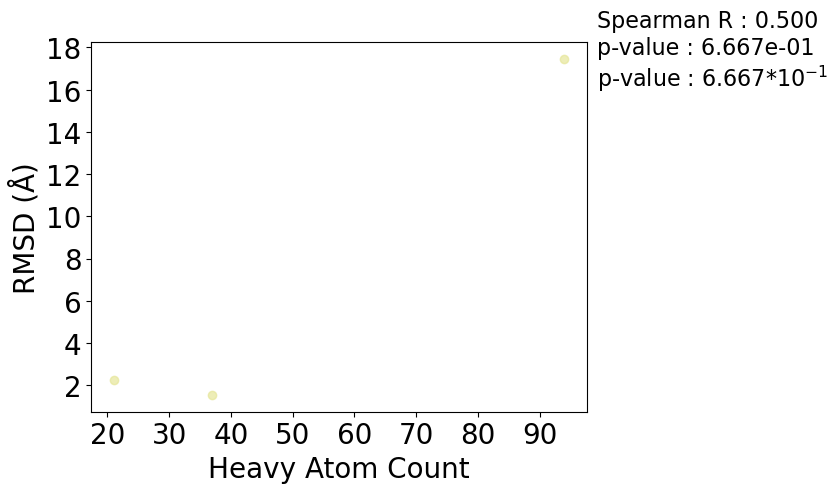

x values plot
0     5
1     4
2    41
Name: Rot_Bonds, dtype: int64
y values plot
0     2.239049
1     1.537123
2    17.456148
Name: RMSD, dtype: float64
Spearman R 3 formats
raw 0.0
.3e 0.000e+00
sci. not. 0.000*$10^{0}$


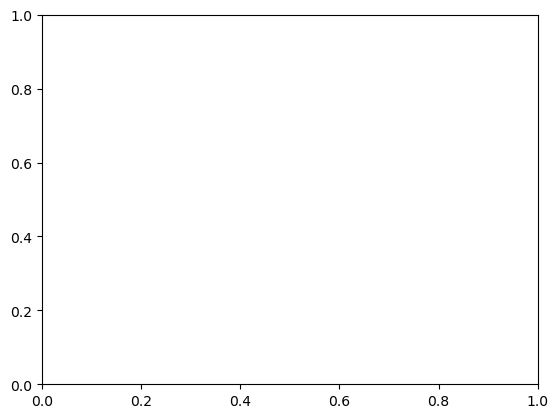

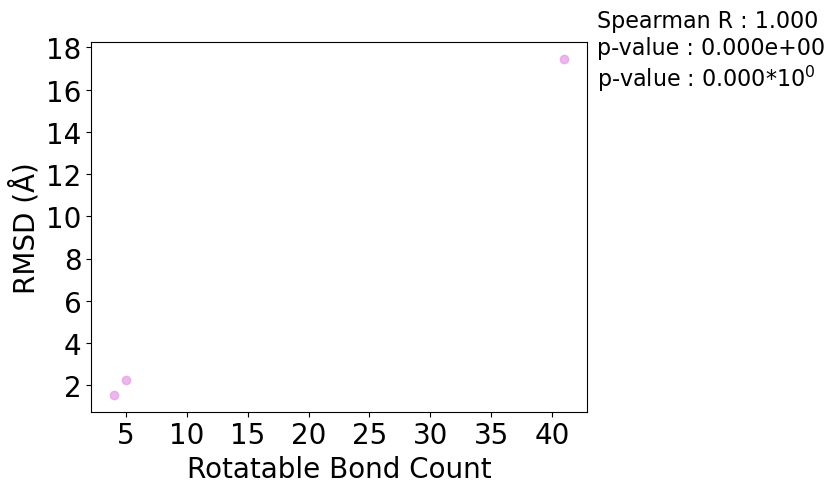

x values plot
0    -5.385337
1    -2.706182
2   -15.523455
Name: Rg_Percent_Error, dtype: float64
y values plot
0     2.239049
1     1.537123
2    17.456148
Name: RMSD, dtype: float64
Spearman R 3 formats
raw 0.0
.3e 0.000e+00
sci. not. 0.000*$10^{0}$


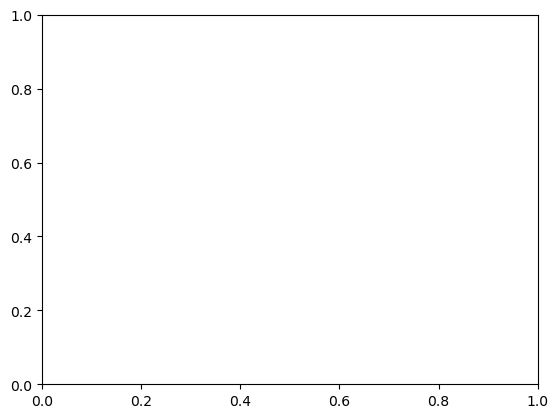

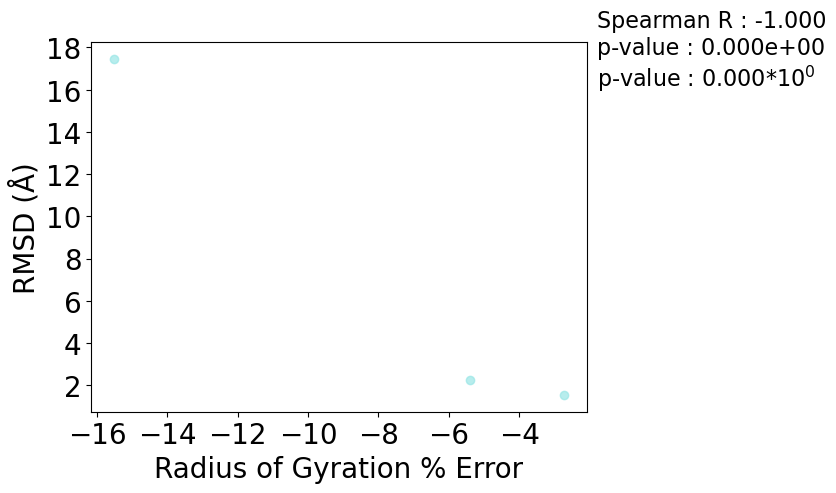

x values plot
0    -5.385337
1    -2.706182
2   -15.523455
Name: Rg_Percent_Error, dtype: float64
y values plot
0    21
1    37
2    94
Name: Heavy_Atom_Count, dtype: int64
Spearman R 3 formats
raw 0.6666666666666667
.3e 6.667e-01
sci. not. 6.667*$10^{-1}$


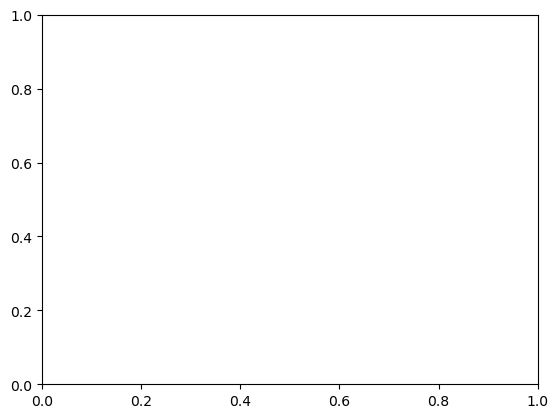

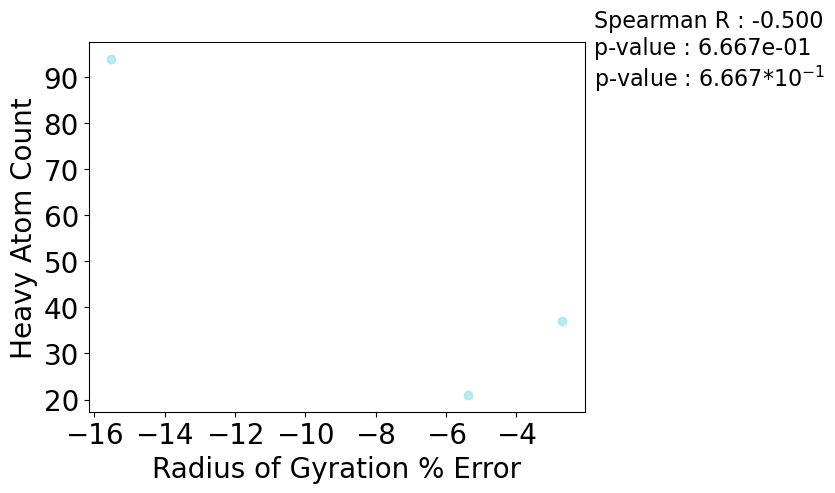

x values plot
0   -21.517381
1   -16.733430
2   -32.306369
Name: Bond_Distance_Percent_Error_Average, dtype: float64
y1 values plot
0    -5.385337
1    -2.706182
2   -15.523455
Name: Rg_Percent_Error, dtype: float64
y2 values plot
0     2.239049
1     1.537123
2    17.456148
Name: RMSD, dtype: float64


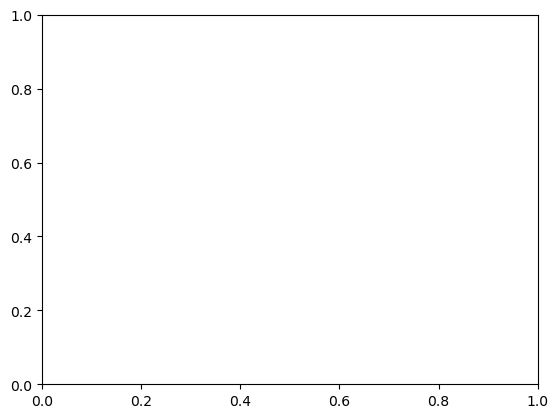

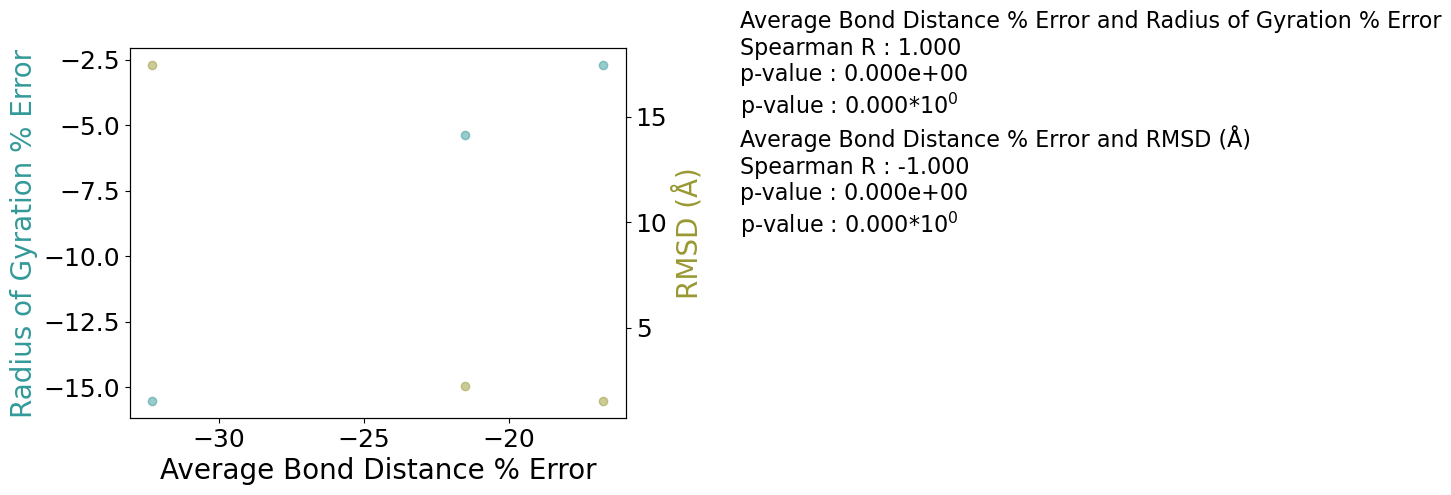

consensus max 0     4
1    77
2    42
Name: SD_0.10_Consensus_Distance_Count, dtype: int64


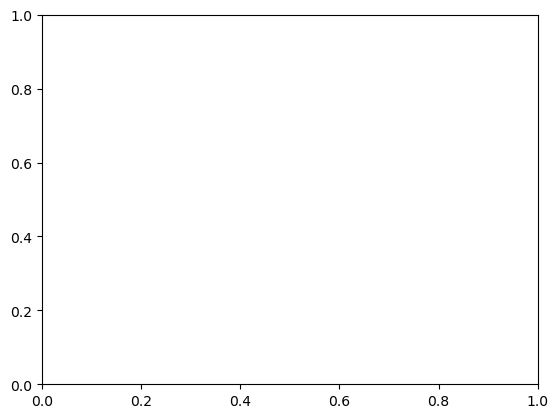

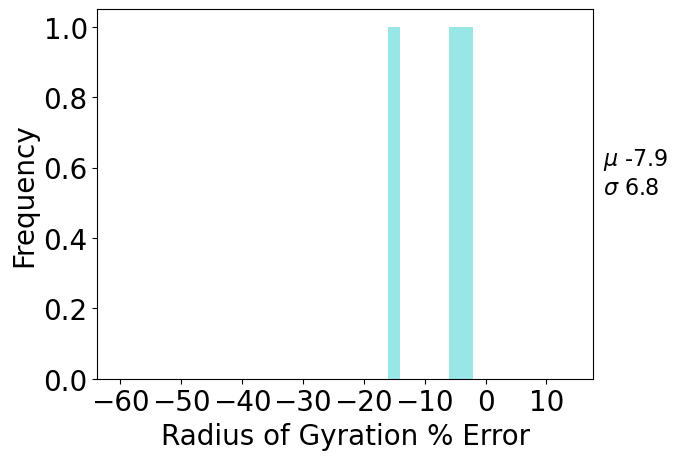

Radius of Gyration % Error has 3 entries, 3 below 0 for 100.0% below
Bond_Distance_Percent_Error_List
where 0?
(array([], dtype=int64),)


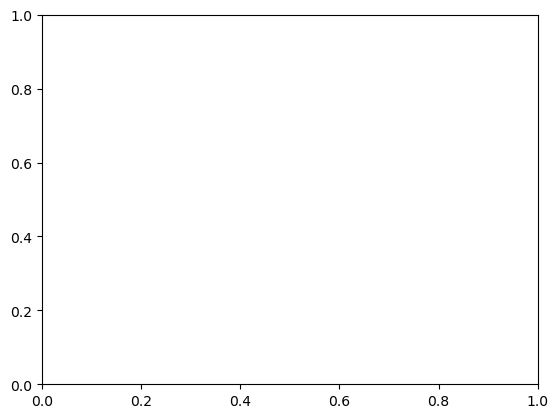

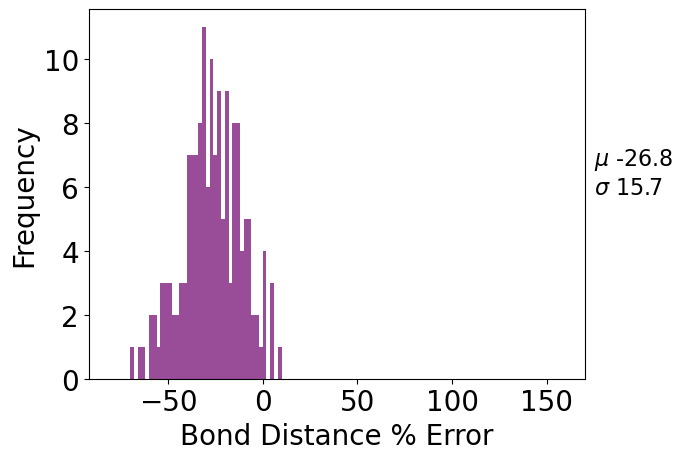

Bond Distance % Error has 159 entries, 151 below 0 for 94.96855345911949% below


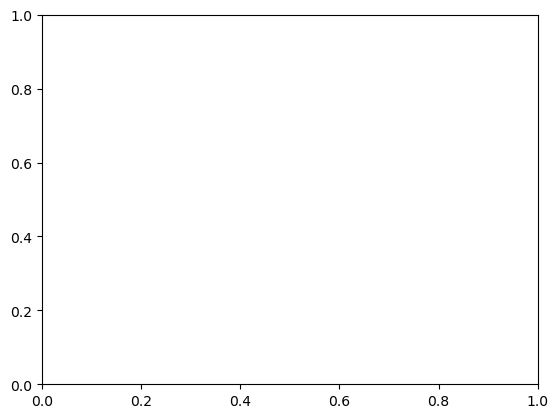

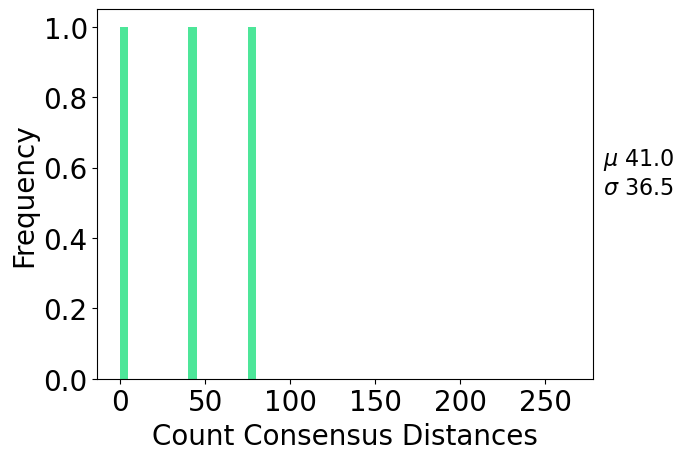

Count Consensus Distances has 3 entries, 0 below 0 for 0.0% below
All_LR_SD
where 0?
(array([], dtype=int64),)


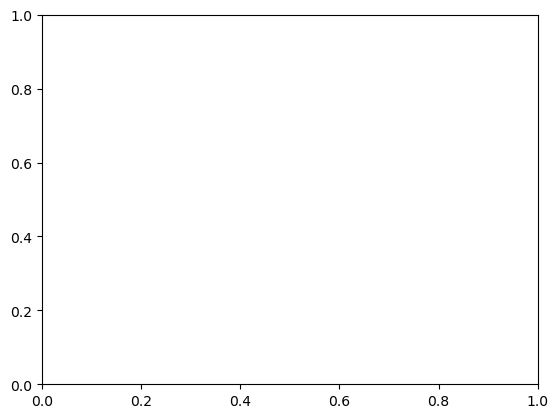

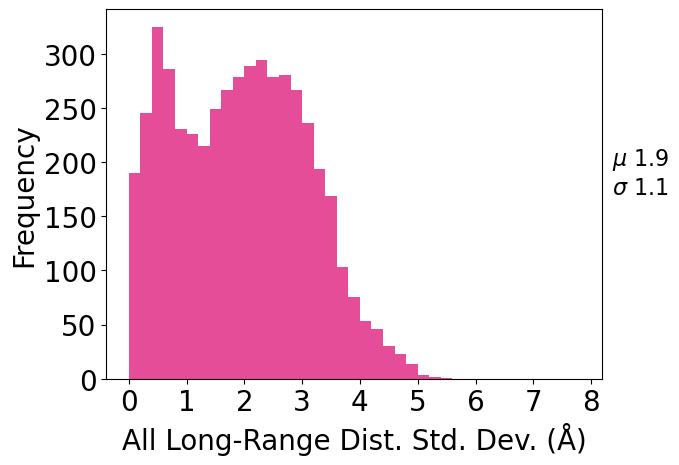

All Long-Range Dist. Std. Dev. (Å) has 4871 entries, 0 below 0 for 0.0% below


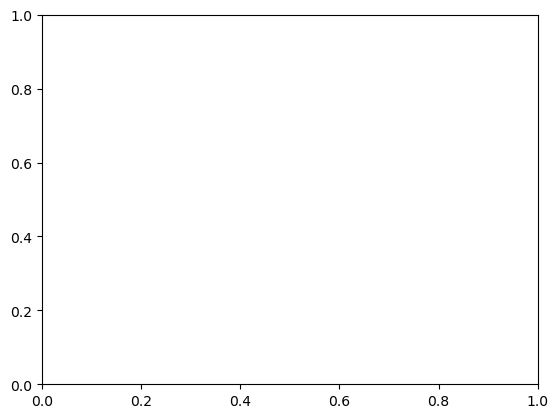

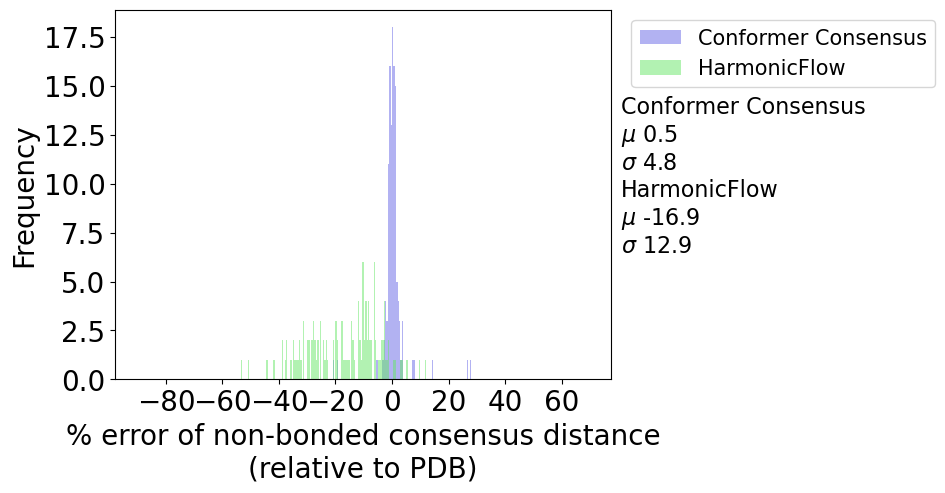

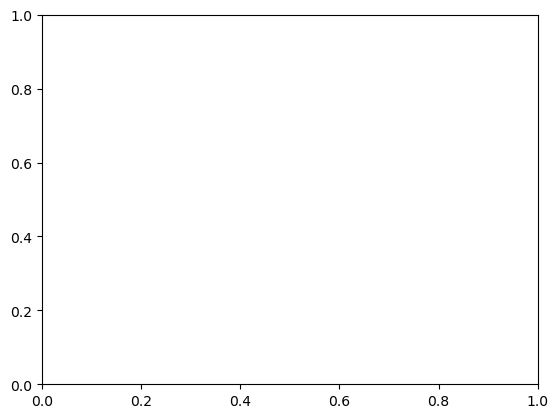

In [90]:
#2/5/24 try for a couple ligands
#This has processed PDBbind data
pdb_dir_check = "/Users/dsharon/Documents/MIT/6.8701/Project/Code/HarmonicFlow/FlowSite/data/PDBBind_processed/"

#I had parsed the _xt.pdb output and placed the 20th set of coordinates for each in a directory
hf_out_dir_check = "/Users/dsharon/Documents/MIT/6.8701/Project/Data/From_Hannes/HarmonicFlow/inference_output_last_xt"

#csv for comparison
#hfcsv = pd.read_csv("/Users/dsharon/Documents/MIT/6.8701/Project/Data/From_Hannes/HarmonicFlow/pred_0.csv")

#Output directory
dir_output_run = "/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/Output/240131/240205_1810_Check_SD_Consensus"
check_df_sd_consensus = run_analysis(pdb_dir_check, 
                                     hf_out_dir_check, 
                                     dir_output_run,
                                     ["6py0", "6nrf", "6qtr"])

In [91]:
#6py0 lists and dict match
#6nrf lists and dict match
#6qtr lists and dict match
#print(check_df_sd_consensus[check_df_sd_consensus["Complex_Name"].isin(["6py0", "6nrf", "6qtr"])])
for c_check in ["6py0", "6nrf", "6qtr"]:
    print(c_check)
    print("SD_0.10_Conformer_Consensus_Distance_Count")
    print(list(check_df_sd_consensus[check_df_sd_consensus["Complex_Name"] == c_check]["SD_0.10_Consensus_Distance_Count"]))
    print("SD_0.10_Conformer_Consensus_Percent_Error")
    print(list(check_df_sd_consensus[check_df_sd_consensus["Complex_Name"] == c_check]["SD_0.10_Conformer_Consensus_Percent_Error"]))
    print("SD_0.10_Inference_Consensus_Percent_Error")
    print(list(check_df_sd_consensus[check_df_sd_consensus["Complex_Name"] == c_check]["SD_0.10_Inference_Consensus_Percent_Error"]))
    print("SD_0.10_Consensus_Info_Dict")
    print(dict(check_df_sd_consensus[check_df_sd_consensus["Complex_Name"] == c_check]["SD_0.10_Consensus_Info_Dict"]))
    #print("All_LR_SD")
    #print(list(pd_df[pd_df["Complex_Name"] == c_check]["All_LR_SD"]))

6py0
SD_0.10_Conformer_Consensus_Distance_Count
[4]
SD_0.10_Conformer_Consensus_Percent_Error
[[3.51940603026987, 2.8253217493780265, 7.927803111924723, 14.412831402255808]]
SD_0.10_Inference_Consensus_Percent_Error
[[-2.2602189409821625, -14.382359350074113, 5.060666668057455, 11.875740515355558]]
SD_0.10_Consensus_Info_Dict
{0: {(0, 3): {'pdb': 2.8828966335961472, 'conformers': 2.984357471565377, 'pdb_conf_pe': 3.51940603026987, 'conf_sd': 0.07199367117749465, 'inf': 2.81773685783467, 'pdb_inf_pe': -2.2602189409821625}, (2, 5): {'pdb': 2.8475861707769257, 'conformers': 2.928039642192167, 'pdb_conf_pe': 2.8253217493780265, 'conf_sd': 0.09372559141677188, 'inf': 2.438036094892773, 'pdb_inf_pe': -14.382359350074113}, (6, 9): {'pdb': 3.3917300894970985, 'conformers': 3.6606197730803367, 'pdb_conf_pe': 7.927803111924723, 'conf_sd': 0.06961590180025852, 'inf': 3.5633742436067535, 'pdb_inf_pe': 5.060666668057455}, (8, 11): {'pdb': 3.215300608030297, 'conformers': 3.6787164637414094, 'pdb_co

In [106]:
#Now check counts
#good all incr
#and indeed 6py0 0.10 dict has none below 0.05
#good additions make sense great
for c_check in ["6py0", "6nrf", "6qtr"]:
    print("++++++")
    for cutoff in [0.05, 0.10, 0.15]:
        print("********")
        print(f"cutoff {cutoff}")
        print(c_check)
        print(f"SD_{cutoff}_Conformer_Consensus_Distance_Count")
        print(list(check_df_sd_consensus[check_df_sd_consensus["Complex_Name"] == c_check][f"SD_{cutoff:.2f}_Consensus_Distance_Count"]))
        print(f"SD_{cutoff:.2f}_Consensus_Info_Dict Max SD")
        consensus_d = dict(check_df_sd_consensus[check_df_sd_consensus["Complex_Name"] == c_check][f"SD_{cutoff:.2f}_Consensus_Info_Dict"])
        consensus_d_usable = consensus_d[list(consensus_d.keys())[0]]
        sd_list = [consensus_d_usable[k]["conf_sd"] for k in consensus_d_usable.keys()]
        if len(sd_list) > 0:
            print(f"max SD {max(sd_list)}")
        else:
            print("no entries")
        
        #Check added if 0.15
        if cutoff == 0.15:
            print("how many under 0.10?")
            print(len([s for s in sd_list if s < 0.10]))
            
        #Check added if 0.10
        if cutoff == 0.10:
            print("how many under 0.05?")
            print(len([s for s in sd_list if s < 0.05]))
            
    #Now confirm all in lower sd lists in higher
    i_list_005 = list(check_df_sd_consensus[check_df_sd_consensus["Complex_Name"] == c_check]["SD_0.05_Inference_Consensus_Percent_Error"])
    i_list_010 = list(check_df_sd_consensus[check_df_sd_consensus["Complex_Name"] == c_check]["SD_0.10_Inference_Consensus_Percent_Error"])
    i_list_015 = list(check_df_sd_consensus[check_df_sd_consensus["Complex_Name"] == c_check]["SD_0.15_Inference_Consensus_Percent_Error"])
    print("i, any in 0.10 not 0.15?")
    print([i for i in i_list_010[0] if i not in i_list_015[0]])
    print("i, any in 0.05 not 0.10?")
    print([i for i in i_list_005[0] if i not in i_list_010[0]])
    c_list_005 = list(check_df_sd_consensus[check_df_sd_consensus["Complex_Name"] == c_check]["SD_0.05_Conformer_Consensus_Percent_Error"])
    c_list_010 = list(check_df_sd_consensus[check_df_sd_consensus["Complex_Name"] == c_check]["SD_0.10_Conformer_Consensus_Percent_Error"])
    c_list_015 = list(check_df_sd_consensus[check_df_sd_consensus["Complex_Name"] == c_check]["SD_0.15_Conformer_Consensus_Percent_Error"])
    print("c, any in 0.10 not 0.15?")
    print([c for c in c_list_010[0] if c not in c_list_015[0]])
    print("c, any in 0.05 not 0.10?")
    print([c for c in c_list_005[0] if c not in c_list_010[0]])    
    
    

++++++
********
cutoff 0.05
6py0
SD_0.05_Conformer_Consensus_Distance_Count
[0]
SD_0.05_Consensus_Info_Dict Max SD
no entries
********
cutoff 0.1
6py0
SD_0.1_Conformer_Consensus_Distance_Count
[4]
SD_0.10_Consensus_Info_Dict Max SD
max SD 0.09372559141677188
how many under 0.05?
0
********
cutoff 0.15
6py0
SD_0.15_Conformer_Consensus_Distance_Count
[6]
SD_0.15_Consensus_Info_Dict Max SD
max SD 0.1399887731538034
how many under 0.10?
4
i, any in 0.10 not 0.15?
[]
i, any in 0.05 not 0.10?
[]
c, any in 0.10 not 0.15?
[]
c, any in 0.05 not 0.10?
[]
++++++
********
cutoff 0.05
6nrf
SD_0.05_Conformer_Consensus_Distance_Count
[69]
SD_0.05_Consensus_Info_Dict Max SD
max SD 0.04550213554775422
********
cutoff 0.1
6nrf
SD_0.1_Conformer_Consensus_Distance_Count
[77]
SD_0.10_Consensus_Info_Dict Max SD
max SD 0.07033982667003462
how many under 0.05?
69
********
cutoff 0.15
6nrf
SD_0.15_Conformer_Consensus_Distance_Count
[90]
SD_0.15_Consensus_Info_Dict Max SD
max SD 0.14980494488630672
how many und

In [99]:
#2/5/24 try for pdbbind
#This has processed PDBbind data
pdb_dir_check = "/Users/dsharon/Documents/MIT/6.8701/Project/Code/HarmonicFlow/FlowSite/data/PDBBind_processed/"

#I had parsed the _xt.pdb output and placed the 20th set of coordinates for each in a directory
#hf_out_dir_check = "/Users/dsharon/Documents/MIT/6.8701/Project/Data/From_Hannes/HarmonicFlow/inference_output_last_xt"

#csv for comparison
#hfcsv = pd.read_csv("/Users/dsharon/Documents/MIT/6.8701/Project/Data/From_Hannes/HarmonicFlow/pred_0.csv")


train_set_list = obtain_list_from_file("/Users/dsharon/Documents/MIT/6.8701/Project/Data/For_ICLR_2024_02_05/PDB_Lists/train_pdb_ids.txt")

#Output directory
dir_output_run_train = "/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/Output/240131/240205_1638"
check_df_train = run_analysis(pdb_dir_check, 
                        None, 
                        dir_output_run,
                        train_set_list)

On 4kz8 index 0
On 1ajp index 1
On 3tu7 index 2
On 2qi1 index 3
On 4mvx index 4
On 3qxv index 5
On 4e35 index 6
Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4dst index 7
Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3i5z index 8
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[16:39:36] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8 9 10 11
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8 9 10 11
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 9 11 12 15 21 22 23
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 9 11 12 15 21 22 23
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 10 11 12 13 14
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 10 11 12 13 14
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 22 23 24 

On 3hub index 61
On 2xde index 62
Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2x8d index 63
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1hsg index 64
On 4z0k index 65
On 4um3 index 66
On 5kdf index 67
On 3ns9 index 68
On 4wpf index 69
On 3kiv index 70
On 3t0x index 71
Can't kekulize mol.  Unkekulized atoms: 9 10 11 13 14 15 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 13 14 15 16 17 18
RDKit was unable to read the molecule.
Using the .sdf file faile

[16:39:36] Can't kekulize mol.  Unkekulized atoms: 9 10 11 13 14 15 16 17 18
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 9 10 11 13 14 15 16 17 18
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 32 33 34
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 32 33 34
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
[16:39:36] Can't kekulize mol.  U

On 5ovc index 123
On 4ymx index 124
On 5ia2 index 125
On 2c6e index 126
On 1kzk index 127
On 5azg index 128
On 1b4h index 129
On 6ed6 index 130
On 5qav index 131
Can't kekulize mol.  Unkekulized atoms: 0 2 3 8 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 2 3 8 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1nz7 index 132
On 5ttv index 133
Can't kekulize mol.  Unkekulized atoms: 0 2 6 14 15 16 17 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 2 6 14 15 16 17 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6aqs index 134
Can't kekulize mol.  Unkekulized atoms: 0 4 5 8 9 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 4 5 8 9 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mo

[16:39:36] Can't kekulize mol.  Unkekulized atoms: 0 2 6 14 15 16 17 18 19
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 0 2 6 14 15 16 17 18 19
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 0 4 5 8 9 10
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 0 4 5 8 9 10
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 28
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 28
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 7 8 9
[16:39:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 7 8 9
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 1 2 6 9 14 20 21 26 28
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 1 2 6 9 14 20 21 26 28
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 3 4 9 10 11 12 14 15 16
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 3 4 9 10 11 12 14 15 16
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 18 19 20 21 22
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 18 19 2

On 4og8 index 198
On 5ggn index 199
On 1fls index 200
On 2qmg index 201
On 4mk2 index 202
On 3wf7 index 203
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 23 24 25 26 27
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 23 24 25 26 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3v01 index 204
On 6g3v index 205
On 5mes index 206
On 5h4j index 207
On 6eya index 208
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 19 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 19 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2z3z index 209
Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit was unable to read the molecule.
Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit was unable to read the molecule.
Usin

[16:39:37] Can't kekulize mol.  Unkekulized atoms: 6 13 14 15 16
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 6 13 14 15 16
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 7 8 14 17 18 19
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 7 8 14 17 18 19
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 8 9 10 24 25 26
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 8 9 10 24 25 26
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71 72 73 74 75
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71 72 73 74 75
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 1 7 20 21 22 23 24 28 29
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 1 7 20 21 22 23 24 28 29
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 

On 4ia0 index 266
On 5vsc index 267
On 2ykj index 268
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4ufd index 269
On 2uw3 index 270
Can't kekulize mol.  Unkekulized atoms: 0 2 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 2 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3umx index 271
Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2wzx index 272
On 5qaz index 273
Can't ke

[16:39:37] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 1 3 5 8 10 11 13 20 21
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 1 3 5 8 10 11 13 20 21
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 4 10 11 12 13
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 4 10 11 12 13
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 13 15 16 17 18 19 20
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 13 15 16 17 18 19 20
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 6 7 8 14 17
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 6 7 8 14 17
[16:39:3

On 3k97 index 331
On 3d1g index 332
On 4o61 index 333
On 3bwk index 334
On 5tl9 index 335
On 4erk index 336
On 1pxn index 337
On 5u0f index 338
On 1f74 index 339
On 5fi7 index 340
On 5l2s index 341
On 6b5q index 342
On 4cg9 index 343
On 6dh0 index 344
On 5gn5 index 345
On 2oei index 346
On 5jur index 347
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 22 23 24 25 26
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 22 23 24 25 26
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2aie index 348
On 3nlb index 349
Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2jk9 index 350
On 3p9m index 351
On 5lud index 352
On 5fue index 353
On 2q89 index 354
On 2x8

[16:39:37] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 0 1 4 7 9 10 11 12 13
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 0 1 4 7 9 10 11 12 13
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 22
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 22
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 21
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 21
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 11 12 13 14 15 16
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 11 12 13 14 15 16
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 8 9 10 11 12 13 14
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 8 9 10 11 12 13 14
[16:39:37] Can't kekulize mol.  Unkekulized atom

On 1c1r index 402
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5f39 index 403
On 4ya8 index 404
On 4jkt index 405
On 5mwg index 406
On 5fho index 407
On 2fqt index 408
On 4b3b index 409
Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5hls index 410
On 5fng index 411
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to us

[16:39:37] Can't kekulize mol.  Unkekulized atoms: 0 8 14 15 16
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 0 8 14 15 16
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 4 12 14 15 16
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 4 12 14 15 16
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20
[16:39:37] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20
[16:39:37] Can't kekulize mo

On 4kql index 478
On 5hk9 index 479
On 5xpn index 480
On 5idp index 481
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 19 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 19 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6ezg index 482
Can't kekulize mol.  Unkekulized atoms: 7 8 11 12 23 25 26 27 28
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 11 12 23 25 26 27 28
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4q1w index 483
On 4ask index 484
On 3lvp index 485
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file in

[16:39:38] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 20 21 22 25 26
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 20 21 22 25 26
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 7 8 19 21 22 23 24 25 26
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 7 8 19 21 22 23 24 25 26
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 0 20 21 22 23
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 0 20 21 22 23
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 8 9 14 15
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 8 9 14 15
[16:39:38] Can't kekuliz

On 5y0f index 541
On 5gmi index 542
On 5bvn index 543
On 3bgl index 544
On 2q9y index 545
On 2byh index 546
Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1ndj index 547
On 4p0x index 548
On 4bjb index 549
On 3wut index 550
On 5q12 index 551
On 5wqj index 552
On 5laq index 553
Can't kekulize mol.  Unkekulized atoms: 7 8 9 41 42
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 41 42
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4z1s index 554
On 2og8 index 555
On 2wpa index 556
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit was unable to r

[16:39:38] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 14 17 19
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 14 17 19
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 38 39 40 41 42
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 38 39 40 41 42
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 10 12 21 22 23
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 10 12 21 22 23
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 3 4 8 9 10
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 3 4 8 9 10
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 1

On 1lhe index 611
On 2xxy index 612
On 3fvl index 613
On 4mpn index 614
On 5ni7 index 615
On 4lh5 index 616
On 5hmh index 617
On 3f37 index 618
On 4m5g index 619
Can't kekulize mol.  Unkekulized atoms: 3 4 8 9 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 8 9 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4yo8 index 620
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3dxm index 621
On 1gx8 index 622
On 6f8r index 623
On 4lv4 index 624
On 5fnr index 625
On 3bpc index 626
On 1jev index 627
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekul

[16:39:38] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 1 7 8 9 10 11 12 13 14
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 1 7 8 9 10 11 12 13 14
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 6 7 8 13 15 16
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 6 7 8 13 15 16
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[1

On 5ljj index 680
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6hdq index 681
On 5qax index 682
On 4dvi index 683
On 4o3t index 684
Can't kekulize mol.  Unkekulized atoms: 47 48 49 50 51 52 53 54 55
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 47 48 49 50 51 52 53 54 55
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3gfw index 685
Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1

[16:39:38] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34 35 36 37 38
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34 35 36 37 38
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 14
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 14
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 0 1 17 18 19 20 21 22 23
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 0 1 17 18 19 20 21 22 23
[16:39:38] Can't kekulize mol.  Unkekulized at

Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4qsx index 739
On 1di9 index 740
On 5ztn index 741
On 5qaq index 742
On 5jf4 index 743
On 6mdq index 744
On 3t4h index 745
On 2xp8 index 746
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2pvk index 747
On 3lk0 index 748
On 3cd8 index 749
On 6ep9 index 750
On 2bpv index 751
On 4pvt index 752
On 3jzk index 753
On 5eds index 754
On 5k4z index 755
Can't kekulize mol.  Unkekulized atoms: 0 1 17 18 19 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 17 18 19 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4lpf index 756
Can't kekulize mol.  Unkekul

[16:39:38] Can't kekulize mol.  Unkekulized atoms: 6 7 8 14 15 16 17 18 19
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 6 7 8 14 15 16 17 18 19
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 10 11 19
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 10 11 19
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 20 21 22 24 25
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 20 21 22 24 25
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 12 13 14 15
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 12 13 14 15
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39

Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5nra index 803
Can't kekulize mol.  Unkekulized atoms: 20 21 22 24 25
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 20 21 22 24 25
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4ciy index 804
On 4wq2 index 805
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 12 13 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4z1k index 806
On 6esj index 807
On 5v8q index 808
On 6evp index 809
On 1uyf index 810
On 5eyz index 811
On 3kdm index 812
On 3ha6 index 813
On 2o7v index 814
On 4jdf index 815
On 4f8h index 816
On 3r6c index 817
On 5g3n index 818
On 1hsh index 819
On 4eh9 index 820
On 6awn index 821
On 5wdw 

[16:39:39] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[16:39:39] Explicit valence for atom # 3 C, 5, is greater than permitted
[16:39:39] Explicit valence for atom # 3 C, 5, is greater than permitted
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 17
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 17
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14 15 16 17 18
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14 15 16 17 18
[16:39:3

On 4ob2 index 877
Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit was unable to read the molecule.
Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4jk5 index 878
On 3s3r index 879
On 2wmw index 880
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2vwl index 881
On 2h4g index 882
On 4kwg index 883
On 5nhj index 884
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3e3b index 885
On 1

[16:39:39] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 10 11
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 10 11
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 11 12
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 11 12
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 7 8 9 11 13
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 7 8 9 11 13
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 

Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3m5a index 935
On 4ach index 936
On 5v8p index 937
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4wr7 index 938
On 4mq1 index 939
On 5nap index 940
On 5t6g index 941
On 3h0q index 942
On 1c1v index 943
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5af

[16:39:39] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 13 14 15 16 17
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 13 14 15 16 17
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10 11 12 13 14 15 16 17 18 24 25 26 27
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10 11 12 13 14 15 16 17 18 24 25 26 27
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 3 15 16 17 18
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 3 15 16 17 18
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 66 67 68 69 70
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 66 67 68 69 70
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 3 8 9 10 11
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 3 8 9 10 11
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[16:39:39] Can't kekulize mol.  Un

On 2lsv index 990
On 1j36 index 991
On 4crf index 992
On 2xk4 index 993
On 1utl index 994
On 1h3b index 995
On 6g5j index 996
On 5owh index 997
On 4x7k index 998
On 1rv1 index 999
On 1w8m index 1000
On 4btk index 1001
On 4n1b index 1002
On 4oc3 index 1003
On 4l19 index 1004
On 4yl0 index 1005
Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10 11 12 13 14 15 16 17 18 24 25 26 27
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10 11 12 13 14 15 16 17 18 24 25 26 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1rrw index 1006
On 5nut index 1007
On 5txy index 1008
On 4zy4 index 1009
Can't kekulize mol.  Unkekulized atoms: 3 15 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 15 16 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5ivn index 1010
C

[16:39:39] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15 16 18
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15 16 18
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 0 1 14 15 17 18 19 20 21
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 0 1 14 15 17 18 19 20 21
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 0 1 18 19 20
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 0 1 18 19 20
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 

On 4lm2 index 1054
On 4eor index 1055
Can't kekulize mol.  Unkekulized atoms: 0 1 14 15 17 18 19 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 14 15 17 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5o1d index 1056
On 5n84 index 1057
On 5gwz index 1058
On 1vjy index 1059
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4e3i index 1060
On 1swk index 1061
On 4bio index 1062
On 4cxx index 1063
On 2v2q index 1064
Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
RDKit was unable to read the molecule.
Using the .sdf fi

[16:39:39] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 10 11 12
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 10 11 12
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7 8 9 10 12 13 14
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7 8 9 10 12 13 14
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 9
[16:39:39] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 9
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 9
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 9
[16:39:40] Can't kek

On 4e7r index 1131
On 3ndm index 1132
On 1ssq index 1133
On 2w8y index 1134
On 4pnw index 1135
On 2g00 index 1136
On 5ll5 index 1137
On 3owj index 1138
Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7 8 9 10 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7 8 9 10 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3ft5 index 1139
On 3ttz index 1140
Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3v8t index 1141
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file

[16:39:40] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 19 20 21 22 24
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 19 20 21 22 24
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 49 50 51 52 53
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 49 50 51 52 53
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 6 7 11 16 17
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 6 7 11 16 17
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 9 18 19
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 9 18 19
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[16:39:40] Can't

Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4brx index 1253
On 3ljo index 1254
On 1ek1 index 1255
On 2hzn index 1256
On 3nx7 index 1257
On 3s2v index 1258
On 1z9h index 1259
On 4lmn index 1260
On 3wyy index 1261
On 2qa8 index 1262
On 6e0q index 1263
On 5v8o index 1264
On 1hvr index 1265
On 5usq index 1266
On 3jq8 index 1267
On 5f08 index 1268
On 4aj1 index 1269
On 4pre index 1270
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3znc index 1271
On 4fpf index 1272
On 5vb5 index 1273
On 2y71 index 1274
On 5cp5 index 1275
On 4pml index 1276
On 1n0s index 1277
On 6hpg index 1278
On 1tnh index 1279
On 3o7u index 1280
On 4qz3 index 1281
On 3ff3 index 1282
On 6dub index 1283
On 1cp6 index 1284
On 4avj index 1285
On 1b3g index 1286
On 5

[16:39:40] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 23 24 25 26 27 28 29 35 36 37 38 39 40
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 23 24 25 26 27 28 29 35 36 37 38 39 40
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 34
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 34
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 76 77 78 79 80 81 82 83 84
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 76 77 78 79 80 81 82 83 84
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 6 10 17 24 26
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 6 10 17 24 26
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 14 15
[16:39:40] Can't kekulize mol. 

On 4b2i index 1319
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1g85 index 1320
On 1q41 index 1321
On 4lyw index 1322
Can't kekulize mol.  Unkekulized atoms: 2 3 4 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 3 4 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3t5u index 1323
On 3rse index 1324
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4zwx index 1325
On 4hww index 1326
Ex

[16:39:40] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 9
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 9
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 42 43 44 45 46 47 48 49 50
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 42 43 44 45 46 47 48 49 50
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 14 15 16
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 14 15 16
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:40] Can't k

Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3r21 index 1376
On 4an2 index 1377
On 4dai index 1378
Can't kekulize mol.  Unkekulized atoms: 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2chx index 1379
On 4ajw index 1380
On 2jbo index 1381
Can't kekulize mol.  Unkekulized atoms: 16 17 18 24 25
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 16 17 18 24 25
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2k62 index 1382
On 2ozr index 1383
On 3p7b index 1384
On 5jau index 1385
On 5akw index 1386
On 3g32 index 1387
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
RDKit was una

[16:39:40] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 8 9 15 16 17
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 8 9 15 16 17
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 10 12 21 22 23
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 10 12 21 22 23
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 10 11
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 10 11
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 3 4 6 8 10
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 3 4 6 8 10
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:40] Can't kekulize mol.  Unkekulized atoms: 1 2 3

On 4umu index 1437
On 3c2u index 1438
On 5odx index 1439
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 18 19 20 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 18 19 20 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2f34 index 1440
On 3byu index 1441
On 6db4 index 1442
Can't kekulize mol.  Unkekulized atoms: 0 2 6 18 19 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 2 6 18 19 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5tdb index 1443
On 2a3x index 1444
On 2qrq index 1445
On 5dya index 1446
On 3miy index 1447
Can't kekulize mol.  Unkekulized atoms: 4 12 14 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 12 14 15 16
RDKit was unable to read the molecule.
Using the .sdf file fai

[16:39:41] Can't kekulize mol.  Unkekulized atoms: 6 7 22 24 25
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 6 7 22 24 25
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 3 4 9 10 11 12 18 19 25
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 3 4 9 10 11 12 18 19 25
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 5 9 11 13 15 19 21 23 25
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 5 9 11 13 15 19 21 23 25
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 11 21 22 23 24 25
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 11 21 22 23 24 25
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 2 6 7 10 11 12
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 2 6 7 10 11 12
[16:39:41]

On 187l index 1493
On 4b80 index 1494
On 3pwh index 1495
On 2vqm index 1496
On 4h75 index 1497
On 3qfd index 1498
On 4j51 index 1499
On 3h26 index 1500
Can't kekulize mol.  Unkekulized atoms: 2 6 7 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 6 7 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2vba index 1501
On 6cck index 1502
On 3tvx index 1503
On 1mu6 index 1504
On 13gs index 1505
On 3ked index 1506
On 2r0y index 1507
On 5jao index 1508
On 3lcd index 1509
On 4g95 index 1510
On 6gub index 1511
On 2iw9 index 1512
Can't kekulize mol.  Unkekulized atoms: 0 1 14 15 17 18 19 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 14 15 17 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3fuj index 1513
Can't kekulize mol.  Unkekulized 

[16:39:41] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 25
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 25
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:41] Can't kekulize mol.  Unkekuli

Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3fh5 index 1550
On 1o3b index 1551
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3gus index 1552
On 4j93 index 1553
Can't kekulize mol.  Unkekulized atoms: 11 12 13 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11 12 13 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4z93 index 1554
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 11 14 15 16 25 26 27 29 30
RDKit wa

[16:39:41] Can't kekulize mol.  Unkekulized atoms: 0 7 9 14 16
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 0 7 9 14 16
[16:39:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:39:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9 10 11 12 13
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9 10 11 12 13
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10 11 12
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10 11 12
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 3 4 8 16 17
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 3 4 8 16 17
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 63 64 65 66 67 68 69 70 71
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 63 64 65 66 67 68 69 70 71
[16:39:41] Can't kekulize 

On 4hup index 1607
Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5ka9 index 1608
On 1nny index 1609
On 5f88 index 1610
On 4ze6 index 1611
On 5t37 index 1612
Can't kekulize mol.  Unkekulized atoms: 3 4 8 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 8 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4yxo index 1613
On 6fqo index 1614
On 6ela index 1615
On 2r5d index 1616
Can't kekulize mol.  Unkekulized atoms: 63 64 65 66 67 68 69 70 71
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 63 64 65 66 67 68 69 70 71
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file in

[16:39:41] Can't kekulize mol.  Unkekulized atoms: 36 37 38 39 40 41 42 43 44
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 36 37 38 39 40 41 42 43 44
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 0 1 12 13 14 16 17 18 20
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 0 1 12 13 14 16 17 18 20
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 0 1 4 5 6 7 9 13 16 17
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 0 1 4 5 6 7 9 13 16 17
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 30
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 30
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 12 13 14 15
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 

Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3gvb index 1656
On 2yz3 index 1657
On 4c73 index 1658
On 4myq index 1659
On 1nl6 index 1660
On 6ay3 index 1661
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 30
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 30
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2zmm index 1662
On 3f81 index 1663
On 3arv index 1664
On 1d3p index 1665
On 6g0w index 1666
On 2aod index 1667
On 4wq3 index 1668
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 12 13 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5hes index 1669
Can't kekulize mol.  Unkekulized atoms: 1 7 8 9 10 11 12 13 14
RDKit was una

[16:39:41] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 5 14 15 29 30
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 5 14 15 29 30
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 14
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 14
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 38 39 40 41 42 43 44 45 46
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 38 39 40 41 42 43 44 45 46
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8 10 11 12 13
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8 10 11 12 13
[16:39:42] Can't kekulize mol.  Unkekulized atoms:

Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1g48 index 1708
On 3ccc index 1709
On 1h08 index 1710
On 2zas index 1711
On 6f3i index 1712
On 1y3x index 1713
On 5e8z index 1714
On 4afe index 1715
On 1heg index 1716
On 4avg index 1717
On 5mmp index 1718
On 5zah index 1719
On 3owd index 1720
On 2yj2 index 1721
On 5clm index 1722
On 2zfp index 1723
On 6eux index 1724
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4ryg index 1725
On 4jv6 index 1726
On 4hvh index 1727
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 

[16:39:42] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 31 32 33
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 31 32 33
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6 7 8 9 11
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6 7 8 9 11
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 3 4 5 14 15 16 17 18 19
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 3 4 5 14 15 16 17 18 19
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 10 11 12 20 21
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 10 11 12 20 21
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6 7 8 9 10
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6 7 8 9 10
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 27 28 30 31 32
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 27 28 30 31 32
[16:39:4

On 3ccw index 1773
On 4y8d index 1774
On 5lrj index 1775
On 4c1g index 1776
On 2r9w index 1777
On 3u8w index 1778
On 6cb5 index 1779
Can't kekulize mol.  Unkekulized atoms: 10 11 12 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2o5k index 1780
Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6 7 8 9 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6 7 8 9 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3rak index 1781
On 2xxt index 1782
On 4cix index 1783
On 4dko index 1784
On 3oxc index 1785
On 2r3n index 1786
On 2qi7 index 1787
On 5wlo index 1788
On 5e7r index 1789
On 5ijr index 1790
On 4muk index 1791
On 5yg2 index 1792
Can't kekulize mol.  Unkekulized atoms: 27 28 30 31 32
RDKit was

[16:39:42] Explicit valence for atom # 16 B, 4, is greater than permitted
[16:39:42] Explicit valence for atom # 16 B, 4, is greater than permitted
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 7 8 9
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 7 8 9
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 0 3 5 9 16
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 0 3 5 9 16
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 21 24 25
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 21 24 25
[16:39:42] Can't kekulize 

On 1owd index 1835
On 3qfv index 1836
On 3avz index 1837
Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6di1 index 1838
On 4xuh index 1839
On 2yex index 1840
Can't kekulize mol.  Unkekulized atoms: 0 3 5 9 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 3 5 9 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3src index 1841
On 5cau index 1842
On 5oci index 1843
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 21 24 25
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 21 24 25
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 

[16:39:42] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 18 19 20
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 18 19 20
[16:39:42] Explicit valence for atom # 2 O, 3, is greater than permitted
[16:39:42] Explicit valence for atom # 2 O, 3, is greater than permitted
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71 72 73 74 75
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71 72 73 74 75
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 0 1 2 11 12 13 14 15 16
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 0 1 2 11 12 13 14 15 16
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 2 6 7 17 18 19 22 23 24 25
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 2 6 7 17 18 19 22 23 24 25
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 55 56 57 58 59 60 61 62 63
[16:39:42] Can't kekulize mol.  Unkeku

Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit was unable to read the molecule.
Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4x2l index 1891
On 4iuu index 1892
On 2cv3 index 1893
Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71 72 73 74 75
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71 72 73 74 75
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4kab index 1894
On 4ha5 index 1895
On 4j0y index 1896
On 5hvt index 1897
On 1t46 index 1898
On 1w5x index 1899
On 5al3 index 1900
On 4txs index 1901
On 4lh7 index 1902
On 5dri index 1903
Can't kekulize mol.  Unkekulized atoms: 0 1 2 11 12 13 14 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 11 12 13 14 15 16


[16:39:42] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 26 27 28
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 26 27 28
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 3 4 5 31 32
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 3 4 5 31 32
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 13 14 15 16 17 18 23 24 25 26 27
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 13 14 15 16 17 18 23 24 25 26 27
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6 13 14 18 20
[16:39:42] Can't kekulize mol.  Unkekulized atoms: 0 

On 1bn4 index 1946
On 2az5 index 1947
On 3drr index 1948
Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 26 27 28
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 26 27 28
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5xmt index 1949
Can't kekulize mol.  Unkekulized atoms: 3 4 5 31 32
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 31 32
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2pv1 index 1950
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3gjt index 1951
On 4fny index 1952
On 3sx9 index

[16:39:43] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 3 6 16 17 18
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 3 6 16 17 18
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 20
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 20
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:39:43] Explicit valence for atom

Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1kcs index 2016
On 2n0w index 2017
On 4o9s index 2018
On 1ttv index 2019
On 5uhi index 2020
On 2fda index 2021
On 1xud index 2022
On 3gx0 index 2023
On 1h4w index 2024
On 3ebb index 2025
On 6cyd index 2026
On 4eg5 index 2027
On 2ohs index 2028
On 6dgy index 2029
On 5jid index 2030
On 6gz9 index 2031
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 20
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5i13 index 2032
On 1ong index 2033
On 4zw8 index 2034
On 1xp6 index 2035
On 6gy1 index 2036
On 3lpk index 2037
On 3wvm index 2038
On 3ipq index 2

[16:39:43] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7 8 9 22 23
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7 8 9 22 23
[16:39:43] Can't kekulize mol.  

On 1mqi index 2080
On 2qnq index 2081
On 1udu index 2082
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5ix1 index 2083
On 5t1t index 2084
On 3wto index 2085
On 5wyz index 2086
On 4xv2 index 2087
On 3d3p index 2088
On 5w0q index 2089
On 3e8u index 2090
On 4ztn index 2091
On 5l2t index 2092
On 3hr1 index 2093
On 1mxu index 2094
On 5sz3 index 2095
On 3nes index 2096
On 3h6z index 2097
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1a4w index 2098
On 4jxs index 2099
On 5yh8 index 2100
Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
RD

[16:39:43] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 29 30 31
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 29 30 31
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 7 8 24
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 7 8 24
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 5 18 19 20 21 22 23 24 26 27 28
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 5 18 19 20 21 22 23 24 26 27 28
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 6 7 9 25 26 27 28 29 30 31 32
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 6 7 9 25 26 27 28 29 30 31 32
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 14 15 16 17
[16

On 3n7a index 2202
On 4f14 index 2203
On 4yog index 2204
On 6gi6 index 2205
On 6cd9 index 2206
Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33 34 35 36 37
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33 34 35 36 37
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5fb1 index 2207
On 2i0v index 2208
On 3uwo index 2209
On 1kwq index 2210
On 5fwj index 2211
On 4qpd index 2212
Can't kekulize mol.  Unkekulized atoms: 0
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1gt3 index 2213
On 3rme index 2214
On 6ft9 index 2215
Can't kekulize mol.  Unkekulized atoms: 0 1 9 10 11 14 15 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 9 10 11 14 15 16 17
RDKit was unable to r

[16:39:43] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33 34 35 36 37
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33 34 35 36 37
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 0
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 0
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 0 1 9 10 11 14 15 16 17
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 0 1 9 10 11 14 15 16 17
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44 45 46 47 48
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44 45 46 47 48
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 10
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 10
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 22 23 24 25
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 22 23 24 25
[16:39:43] Can't kekuliz

On 4m5l index 2265
Can't kekulize mol.  Unkekulized atoms: 11 12 13 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11 12 13 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4l2f index 2266
On 5t5g index 2267
On 4ez5 index 2268
Can't kekulize mol.  Unkekulized atoms: 4 5 6 28 29 30 31 32 33
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 6 28 29 30 31 32 33
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5ufs index 2269
On 4ijh index 2270
On 2yig index 2271
On 1rtf index 2272
On 2jdt index 2273
On 4xyc index 2274
On 1t49 index 2275
On 4nak index 2276
Can't kekulize mol.  Unkekulized atoms: 2 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file fail

[16:39:43] Can't kekulize mol.  Unkekulized atoms: 2 8 9 10 11
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 2 8 9 10 11
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 41
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 41
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 18 19 20 21
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 18 19 20 21
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 5 6 16 17 18
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 5 6 16 17 18
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 138 139 140 141 142
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 138 139 140 141 142
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 21 23 24 25 26
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 21 23 24 25 26
[16:39:43] Can't kekulize mol.  Unkekulized atoms: 1 6 14 15 1

Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4nrb index 2335
On 5a4t index 2336
On 4z0f index 2337
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1d4j index 2338
On 3omm index 2339
On 5tzz index 2340
On 1npz index 2341
On 1nq0 index 2342
On 5ttf index 2343
On 1rs2 index 2344
On 3nw7 index 2345
Can't kekulize mol.  Unkekulized atoms: 4 9 10 20 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 9 10 20 23
RDKit was unable to read the molecule.
Using the .sd

[16:39:44] Can't kekulize mol.  Unkekulized atoms: 4 9 10 20 23
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 4 9 10 20 23
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 2 3 11 16 32
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 2 3 11 16 32
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 21
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 21
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 23 24 25 26
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 23 24 25 26
[16:39:44] Can't kekulize mol.  Unkekulized 

On 2gni index 2395
On 5a0c index 2396
On 5uf0 index 2397
On 4lwc index 2398
On 5yji index 2399
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4d8a index 2400
On 1v2t index 2401
On 3fqk index 2402
On 3hl7 index 2403
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2cm8 index 2404
On 4ahs index 2405
On 3nww index 2406
On 1pi4 index 2407
On 4jfm index 2408
On 3dcr index 2409
On 5alg index 2410
On 2jk7 index 2411
On 2gnl index 2412
On 3v8w index 2413
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
RDKit was unable to read the molecule.
Can't kek

[16:39:44] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 7 8 9
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 7 8 9
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 41
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 41
[16:39:44] Can't kekulize mo

On 5gja index 2471
On 5h5s index 2472
Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71 72 73 74 75
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71 72 73 74 75
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5tzo index 2473
On 4io3 index 2474
On 3kfa index 2475
On 5dxt index 2476
On 5osl index 2477
On 5gvn index 2478
Can't kekulize mol.  Unkekulized atoms: 27 28 30 31 32
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 27 28 30 31 32
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2f1g index 2479
On 3tt0 index 2480
On 1y6r index 2481
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 16 17 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 16 17 18 19
RDKit was unable to read the molecule.
Using t

[16:39:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 10 14 20 21 22 23
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 10 14 20 21 22 23
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 12 13 14 16 17 19
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 12 13 14 16 17 19
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 19
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 19
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 23 24 25 26 27
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 23 24 25 26 27
[16:39:44] Can't kekulize mo

Can't kekulize mol.  Unkekulized atoms: 9 10 16 17 19 20 28 29 30
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 16 17 19 20 28 29 30
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1c4y index 2530
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3nf9 index 2531
On 5q0t index 2532
On 3lj3 index 2533
On 2vx0 index 2534
On 5n1p index 2535
On 3snb index 2536
On 5mys index 2537
On 4nga index 2538
On 1ai7 index 2539
On 4hxr index 2540
On 3efk index 2541
Can't kekulize mol.  Unkekulized atoms: 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 fil

[16:39:44] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 0 2 3 5 7 14 15 16 17
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 0 2 3 5 7 14 15 

On 5sve index 2582
On 1ni1 index 2583
On 6dik index 2584
On 3efw index 2585
On 3fyj index 2586
On 4j5b index 2587
On 3erk index 2588
On 3v5q index 2589
Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2bve index 2590
On 5m6h index 2591
On 4y3j index 2592
On 1q83 index 2593
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 8 15 16 17 18 19 20
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 8 15 16 17 18 19 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6h34 index 2594
On 2xd6 index 2595
On 6gxu index 2596
On 5mrd index 2597
On 4nka index 2598
Can't kekulize mol.  Unkekulized atoms: 3 6 7 8 21
RDKit was unable to read the molecule.
Can't

[16:39:44] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[16:39:44] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[16:39:45] Explicit valence for atom # 0 B, 4, is greater than permitted
[16:39:45] Explicit valence for atom # 0 B, 4, is greater than permitted
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 31 32 33
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 31 32 33
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 16 17 18 19 20 21 22 23 24 25
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 16 17 18 19 20 21 22 23 24 25
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 10
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 10
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 9 10 11
[16:39:45] Can't kekulize mol.  Unkekul

On 1tg5 index 2644
On 5eol index 2645
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 16 17 18 19 20 21 22 23 24 25
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 16 17 18 19 20 21 22 23 24 25
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2ya8 index 2646
On 4ce1 index 2647
On 1o5b index 2648
On 6ea1 index 2649
On 4lzs index 2650
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5oxk index 2651
On 4hf4 index 2652
On 6bsx index 2653
Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file fa

[16:39:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 11 13 18 22 23
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 11 13 18 22 23
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 15 16 17 18 22
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 15 16 17 18 22
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7 14 15 16 17
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7 14 15 16 17
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 41 42 43 44 45
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 41 42 43 44 45
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:45] Can't kekulize mol.  Unkekulized a

Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 17 18 20 21 22
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 17 18 20 21 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5kww index 2721
On 4b5d index 2722
On 1rw8 index 2723
On 4ojq index 2724
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 9 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 9 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2vnf index 2725
On 5fe9 index 2726
On 6chq index 2727
On 1ukh index 2728
On 1o5f index 2729
Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file i

[16:39:45] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 14 19 20 21
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 14 19 20 21
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 0 5 6 9 10 11 12 19 20
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 0 5 6 9 10 11 12 19 20
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 19 21 22 23 24 26 27 28 29
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 19 21 22 23 24 26 27 28 29
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 16 17 18 24 25
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 16 17 18 24 2

On 5fp0 index 2800
Can't kekulize mol.  Unkekulized atoms: 0 5 6 9 10 11 12 19 20
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 5 6 9 10 11 12 19 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2oo8 index 2801
On 5g53 index 2802
On 4ju3 index 2803
On 4nru index 2804
On 4lwv index 2805
On 4ih7 index 2806
On 3vw1 index 2807
On 3bxs index 2808
On 1uvu index 2809
On 1evh index 2810
On 4xir index 2811
On 4dmy index 2812
Can't kekulize mol.  Unkekulized atoms: 19 21 22 23 24 26 27 28 29
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 19 21 22 23 24 26 27 28 29
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1aid index 2813
On 1onh index 2814
On 3l0v index 2815
On 1k1p index 2816
On 4itp index 2817
On 6csq index 2818
On 4jpe index 2819
On 3qiy index 2820
On 2j47 index

[16:39:45] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 4 5 6 20 21 22 23 24 25
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 4 5 6 20 21 22 23 24 25
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 18 19
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 18 19
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 8 9 10 18 19 20 21 22 23
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 8 9 10 18 19 20 21 22 23
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 5 7 10 13 15
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 5 7 10 13 15
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18 24 25
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18 24 25
[16:39:45] C

Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4yff index 2884
Can't kekulize mol.  Unkekulized atoms: 4 5 6 20 21 22 23 24 25
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 6 20 21 22 23 24 25
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5yp6 index 2885
On 3vi5 index 2886
On 2c80 index 2887
On 4h2j index 2888
On 4mul index 2889
On 6c8x index 2890
On 4z46 index 2891
On 1x76 index 2892
On 1d7i index 2893
On 4ikr index 2894
On 5auu index 2895
On 5djv index 2896
Can't kekulize mol.  Unkekulized atoms: 0 1 2 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 18 19
RDKit was unable to read the molecule.
Using

[16:39:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 9 18 19 20 21 24 25
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 9 18 19 20 21 24 25
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 15 16 17 18
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 15 16 17 18
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 6 7 8 12 13
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 6 7 8 12 13
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 4 5 15 19 23
[16:39:45] Can't kekulize mol.  Unkekulized atoms: 4 5 15 19 23
[16:39:45] Can't k

On 5ivc index 3043
On 4zfi index 3044
Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2xch index 3045
On 4x60 index 3046
On 6dqb index 3047
On 1xgj index 3048
On 1h62 index 3049
On 1h39 index 3050
On 4y38 index 3051
On 2v3u index 3052
On 4kn2 index 3053
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3av9 index 3054
On 4yht index 3055
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 12 13 14 24 25
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 12 13 14 24 25
RDKit was unab

[16:39:46] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 15
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 15
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 12 13 14 24 25
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 12 13 14 24 25
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 21
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 21
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 7 8 9 21 22 23 25 26 27
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 7 8 9 21 22 23 25 26 27
[16:39:46] Can't kekulize mol.  Un

On 4wy3 index 3108
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6fng index 3109
On 4azb index 3110
On 4b7z index 3111
On 5u62 index 3112
On 2wkz index 3113
On 1zzz index 3114
On 4y8x index 3115
Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3h85 index 3116
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use

[16:39:46] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 40 43 44
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 40 43 44
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 3 4 8 9 17
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 3 4 8 9 17
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
[16:39:46] Can't kekulize mol.  Unkekulized atoms:

On 3ppo index 3172
On 2z9g index 3173
On 4q0l index 3174
On 2jt6 index 3175
On 4oz2 index 3176
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1l83 index 3177
On 2byp index 3178
Can't kekulize mol.  Unkekulized atoms: 64 65 66 67 68 69 70 71 72
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 64 65 66 67 68 69 70 71 72
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4io2 index 3179
On 4zs0 index 3180
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file ins

[16:39:46] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 26 27
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 26 27
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 10 11 15 18
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 10 11 15 18
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 0 1 3 6 11
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 0 1 3 6 11
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 73 74 75 76 77
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 73 74 75 76 77
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 4 7 11 12 13
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 4 7 11 12 13
[1

On 6b7h index 3235
On 4zsh index 3236
On 4eqf index 3237
On 4jia index 3238
On 5a83 index 3239
On 5wcm index 3240
On 3vw9 index 3241
On 2bvr index 3242
On 4bkj index 3243
On 1kdw index 3244
On 2xpa index 3245
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5ece index 3246
On 5eei index 3247
On 3g0e index 3248
Can't kekulize mol.  Unkekulized atoms: 4 12 14 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 12 14 15 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4c4f index 3249
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
RDKit 

[16:39:46] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 13
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 13
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 4 12 14 15 16
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 4 12 14 15 16
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[16:39:46] Can't kekulize mol.  Unkekuli

On 4k4e index 3294
On 3dtc index 3295
On 4l0b index 3296
On 4gb9 index 3297
On 5e8r index 3298
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3zso index 3299
On 6cnk index 3300
On 1yyr index 3301
On 5m5q index 3302
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 21 22 23 24 27
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 21 22 23 24 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5jyo index 3303
On 3qw8 index 3304
On 4g8v index 3305
On 5n4t index 3306
Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 9 10 11 12 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 9 10 11 12 16
RDKit was unable to read the mol

[16:39:46] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 9 10 11 12 16
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 9 10 11 12 16
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 13 14 15 16 17
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 13 14 15 16 17
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 0 1 12 14 15 18 19 20 22
[16:39:46] Can't kekulize mol.  Unkekulized atoms: 0 1 12 14 15 18 19 20 22
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 0 1 4 9 11
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 0 1 4 9 11
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 65 66 67 68 69 70 71 72 73
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 65 66 67 68 69 70 71 72 73
[16:39:47] Can't kek

On 4tw7 index 3370
On 4yad index 3371
On 2a8g index 3372
On 5nuu index 3373
Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3v7s index 3374
On 1w84 index 3375
Can't kekulize mol.  Unkekulized atoms: 0 9 10 11 12 13 14 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 9 10 11 12 13 14 15 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4ezk index 3376
Can't kekulize mol.  Unkekulized atoms: 11 13 25 26 27 28 29 30 31
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11 13 25 26 27 28 29 30 31
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and a

[16:39:47] Can't kekulize mol.  Unkekulized atoms: 7 8 9 14 15
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 7 8 9 14 15
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 3 4 5 14 15
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 3 4 5 14 15
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 39 40 41 42 43
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 39 40 41 42 43
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7 8 9 10 11 12 13 14
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7 8 9 10 11 12 13 14
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 8 9 10 11 12 13
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 8 9 10 11 12 13
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 33 34 35
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 33 34 35
[16:39:47] Can

On 5tya index 3437
On 2y1x index 3438
Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 33 34 35
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 33 34 35
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4ucv index 3439
On 2uze index 3440
On 4pv0 index 3441
On 1hvl index 3442
On 4p6e index 3443
On 4yv1 index 3444
On 2pe0 index 3445
Can't kekulize mol.  Unkekulized atoms: 10 14 15 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 14 15 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4a51 index 3446
On 2h9m index 3447
On 3ce3 index 3448
Can't kekulize mol.  Unkekulized atoms: 10 12 13 14 15 16 17 28 29
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 12 13 14 15 16 17 28 29
RDKit was unable to read th

[16:39:47] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 16 17 18
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 16 17 18
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 0 4 5 7 13 17 18 19 22
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 0 4 5 7 13 17 18 19 22
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 9 11 12 13 14
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 9 11 12 13 14
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 10 18 19 20 21
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 10 18 19 20 21
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 5 6 24 25 26 27 28 29 40
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 5 6 24 25 26 27 28 29 40
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28
[16:39:47] Can't kekulize mol.  Unke

On 5hwv index 3494
On 1fl3 index 3495
On 5ljt index 3496
On 3djk index 3497
On 1kz8 index 3498
On 4efu index 3499
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3mz6 index 3500
On 4qtd index 3501
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 13 14 15 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 13 14 15 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5cfa index 3502
On 3r17 index 3503
On 6fc6 index 3504
On 1kui index 3505
Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
RDKit was unable to rea

[16:39:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 1 8 9 10 11 12 22 23 24
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 1 8 9 10 11 12 22 23 24
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 8 9 10 11 12 13 14
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 8 9 10 11 12 13 14
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 29 30 31 32
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 29 30 31 32
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 7 

On 4en4 index 3556
On 4l10 index 3557
On 3qnj index 3558
On 5ut0 index 3559
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5mkr index 3560
On 4msl index 3561
On 4awp index 3562
On 5vkf index 3563
On 2w71 index 3564
On 5vh0 index 3565
On 5een index 3566
On 2gg2 index 3567
Can't kekulize mol.  Unkekulized atoms: 12 13 15 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 12 13 15 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4w9o index 3568
On 2ndo index 3569
On 2bqw index 3570
On 6c7i index 3571
On 3nyn index 3572
On 1w9u index 3573
Can't kekulize mol.  Unkekulized atoms: 33 34 35 36 37
RDKit was unable to read the molecule.
Can't kekulize mol.  U

[16:39:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 10 11 12 13
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 10 11 12 13
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 10
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 10
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:39:47] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 14 15 16 17 19
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 14 15 16 17 19
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[16:39:48] Can

On 5ugd index 3625
On 1j14 index 3626
On 1hgt index 3627
On 4mc9 index 3628
On 4imq index 3629
On 4ps3 index 3630
On 3k3h index 3631
On 1ws1 index 3632
On 6hpw index 3633
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4ds1 index 3634
On 6bh1 index 3635
Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 14 15 16 17 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 14 15 16 17 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2waj index 3636
On 4jg6 index 3637
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14

[16:39:48] Can't kekulize mol.  Unkekulized atoms: 64 65 66 67 68 69 70 71 72
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 64 65 66 67 68 69 70 71 72
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 78 79 80 81 82 83 84 85 86
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 78 79 80 81 82 83 84 85 86
[16:39:48] Explicit valence for atom # 9 B, 4, is greater than permitted
[16:39:48] Explicit valence for atom # 9 B, 4, is greater than permitted
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8 9 10 11 12
[16:39:48] Can't kekulize mol.  Unkekulized 

Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5jjr index 3681
On 5cxi index 3682
On 4qag index 3683
On 2c57 index 3684
On 3chr index 3685
On 2jkq index 3686
On 2hxq index 3687
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6dh8 index 3688
On 6fe1 index 3689
On 6ft7 index 3690
Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3zn0 index 3691
On 5q0j index 3692
On 4b3d index 3693
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read 

[16:39:48] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 14 15 16 17 18
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 14 15 16 17 18
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 0 2 3 17 18
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 0 2 3 17 18
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 11 17 20 21 22 34 35 36 37
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 11 17 20 21 22 34 35 36 37
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 72 73 74 75 76 77 78 79 80
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 72 73 74 75 76 77 78 79 80
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 24
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 24
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 33 34 35 36 37
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 33 34 35 36 37
[16:39:48] Can't k

On 2viv index 3744
On 3qwc index 3745
Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3gds index 3746
On 2lh8 index 3747
On 4ks5 index 3748
On 4zyc index 3749
Can't kekulize mol.  Unkekulized atoms: 33 34 35 36 37
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 33 34 35 36 37
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3rkb index 3750
On 2qky index 3751
On 5wa5 index 3752
On 2xj0 index 3753
On 4q6e index 3754
On 1f9e index 3755
On 3f7z index 3756
On 1uvt index 3757
On 1aq7 index 3758
On 6cnj index 3759
On 2h96 index 3760
On 3lir index 3761
On 3uzc index 3762
On 4e28 index 3763
On 5c20 index 3764
On 7kme index 3765
Can't kekulize mol.  Unkekulized a

[16:39:48] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:39:48] Explicit valence for atom # 9 B, 4, is greater than permitted
[16:39:48] Explicit valence for atom # 9 B, 4, is greater than permitted
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 7 9 11 20 21
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 7 9 11 20 21
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 9
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 9
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
[16:39:48] Can't kekulize mol.  Un

Explicit valence for atom # 9 B, 4, is greater than permitted
RDKit was unable to read the molecule.
Explicit valence for atom # 9 B, 4, is greater than permitted
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2i1m index 3828
On 3rm4 index 3829
Can't kekulize mol.  Unkekulized atoms: 7 9 11 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 9 11 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3avl index 3830
On 5ayf index 3831
On 4k60 index 3832
On 5yz7 index 3833
On 1n8u index 3834
On 4pax index 3835
On 4uwf index 3836
Can't kekulize mol.  Unkekulized atoms: 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3pjc index 3837
Can'

[16:39:48] Can't kekulize mol.  Unkekulized atoms: 10 11 12 21 22
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 10 11 12 21 22
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 20 21 30
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 20 21 30
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 43 44 45 46 47 48 49 50 51
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 43 44 45 46 47 48 49 50 51
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 14 15 16
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 14 15

On 5i4v index 3893
On 3qsb index 3894
On 5iza index 3895
Can't kekulize mol.  Unkekulized atoms: 43 44 45 46 47 48 49 50 51
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 43 44 45 46 47 48 49 50 51
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3u6a index 3896
On 3d50 index 3897
On 2euf index 3898
On 1p05 index 3899
On 4ddy index 3900
Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6c0n index 3901
On 5anu index 3902
On 4z5w index 3903
On 1w8l index 3904
On 5e1b index 3905
On 5n8v index 3906
On 4alv index 3907
On 5nu3 index 3908
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized 

[16:39:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 13 15 16
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 13 15 16
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 5 8 9 10 11
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 5 8 9 10 11
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 14
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 14
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 7 8 9
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 7 8 9
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6
[16:39:48] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6
[16:39:49] Can't kekuliz

On 2ofu index 3954
On 6g3q index 3955
On 6f6u index 3956
On 4kup index 3957
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3po6 index 3958
On 5g1z index 3959
On 1i7i index 3960
On 5t1s index 3961
On 3uo9 index 3962
On 4oz1 index 3963
Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 33 34 35
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 33 34 35
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2wf2 index 3964
On 4tmp index 3965
On 3uvq index 3966
On 4xg7 index 3967
On 1ebz index 3968
On 3su3 index 3969
On 5ceh index 3970
On 3s2a index 3971
On 4b0c index 3972
Can't kekulize mol.  Unkekulized atoms: 1 6

[16:39:49] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7 8 9 10 11 12 13 14 16 17 18
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7 8 9 10 11 12 13 14 16 17 18
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 85 86 87 88 89
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 85 86 87 88 89
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 0 27 28 29 30 31 32 33 34
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 0 27 28 29 30 31 32 33 34
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10 11 12
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10 11 1

On 3owl index 4027
Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7 8 9 10 11 12 13 14 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7 8 9 10 11 12 13 14 16 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2o8h index 4028
On 3wk9 index 4029
On 3er3 index 4030
Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2oc7 index 4031
On 5xwr index 4032
Can't kekulize mol.  Unkekulized atoms: 85 86 87 88 89
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 85 86 87 88 89
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4wtu in

[16:39:49] Can't kekulize mol.  Unkekulized atoms: 3 6 14 15 16 18 20 26 27
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 3 6 14 15 16 18 20 26 27
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 24 25
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 24 25
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 3 4 6 7 28
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 3 4 6 7 28
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 1 3 5 6 7
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 1 3 5 6 7
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[16:39:4

On 3arw index 4098
On 1qbu index 4099
On 3vi7 index 4100
On 4qd6 index 4101
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4djo index 4102
On 4q06 index 4103
On 4wn1 index 4104
On 1uvs index 4105
On 3s76 index 4106
Can't kekulize mol.  Unkekulized atoms: 1 3 5 6 7
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 3 5 6 7
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4ngq index 4107
On 1s38 index 4108
On 5q14 index 4109
On 2cn8 index 4110
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found 

[16:39:49] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13 14 15 16 17
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13 14 15 16 17
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 9 24 25
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 9 24 25
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 8 9
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 8 9
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 12 13 14 21 22 23 24 25 26
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 12 13 14 21 22 23 24 25 26
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 0 3 5 6 8 11 13 14 15
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 0 3 5 6 8 11 13 14 15
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 0 4 5 8 9 10
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 0 4 5 8 9 10
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 1 2 15 16 17
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 1 2 15 16 17
[16:39:49] Can't kekul

On 4m5m index 4173
Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5vih index 4174
On 2r3m index 4175
On 4ggl index 4176
Can't kekulize mol.  Unkekulized atoms: 12 13 14 21 22 23 24 25 26
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 12 13 14 21 22 23 24 25 26
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4fbe index 4177
On 3v04 index 4178
Can't kekulize mol.  Unkekulized atoms: 0 3 5 6 8 11 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 3 5 6 8 11 13 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2vcj index 4179
On 4ear index

[16:39:49] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9 10 11 12 13
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9 10 11 12 13
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 19
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 19
[16:39:49] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34 35 36 37 38
[16:39:49] Can't kekulize mol.  Unkekulized 

On 1ony index 4248
On 3wiz index 4249
On 1czc index 4250
On 3o99 index 4251
On 4cqf index 4252
On 2ei6 index 4253
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1sqi index 4254
On 4ab8 index 4255
On 3fn0 index 4256
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2c3i index 4257
On 1b8n index 4258
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found 

[16:39:50] Can't kekulize mol.  Unkekulized atoms: 2 9 10 13 15 16
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 2 9 10 13 15 16
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 18 19 21
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 18 19 21
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 1 8 9 19 30
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 1 8 9 19 30
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 4 5 9 10 11
[16:3

On 5qac index 4330
On 2c4w index 4331
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1f7b index 4332
On 5lj1 index 4333
On 2uup index 4334
On 2w1d index 4335
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2gj4 index 4336
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 18 19 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 18 19 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2wxh index 4337
On 2wmu index 4338
Can't kekulize 

[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 9 10
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 9 10
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 26
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 26
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 2 3 6 7 8
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 2 3 6 7 8
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 14 15 16 17
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 14 15 16 17
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 1 4 7 17 19
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 1 4 7 17 19
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 23 24 25 26
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 23 24 25 26
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 16 17 18 19 20
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 16 17 18 19 20
[16:39:50] Explicit valence for atom # 31 O, 3, 

On 5awu index 4415
On 3g2s index 4416
On 2cbs index 4417
On 4o44 index 4418
On 4xg8 index 4419
On 2bz8 index 4420
On 4epy index 4421
Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 26
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 26
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3s45 index 4422
On 6d28 index 4423
On 2std index 4424
On 2d1o index 4425
On 3wix index 4426
On 4ke1 index 4427
On 3cfn index 4428
On 3ekp index 4429
On 5llh index 4430
On 3vbd index 4431
On 3ttj index 4432
On 5e91 index 4433
On 2uy3 index 4434
Can't kekulize mol.  Unkekulized atoms: 2 3 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 3 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5gp7 index 4435
On 2qbq index 4436
On 2xng index 4437
On 5igq index 4438
On 5ct

[16:39:50] Can't kekulize mol.  Unkekulized atoms: 3 6 7 8 9 10 11
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 3 6 7 8 9 10 11
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 79 80 81 82 83
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 79 80 81 82 83
[16:39:50] Explicit valence for atom # 2 C, 6, is greater than permitted
[16:39:50] Explicit valence for atom # 2 C, 6, is greater than permitted
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:50] Can't kekulize mo

On 3tv6 index 4577
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6dqa index 4578
On 1u3r index 4579
On 3cr4 index 4580
On 4deu index 4581
On 2br8 index 4582
On 3ur9 index 4583
On 1ghv index 4584
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3ati index 4585
On 6g85 index 4586
On 1y3v index 4587
On 4zxy index 4588
On 4nbk index 4589
On 4dsu index 4590
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unabl

[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 1 4 6 7 8
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 1 4 6 7 8
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 2 3 22 23 24 25 26 27
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 2 3 22 23 24 25 26 27
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 6 7 8 9 10
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 6 7 8 9 10
[16:39:50] Can't kekulize mol.  Unkekulized atoms:

On 3h2n index 4641
On 4tkf index 4642
On 5hz5 index 4643
Can't kekulize mol.  Unkekulized atoms: 5 24 25 26 27
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 24 25 26 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4h2m index 4644
On 1ow4 index 4645
On 1ysg index 4646
On 5tuo index 4647
On 3qaa index 4648
On 3f39 index 4649
On 4pnk index 4650
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3mj1 index 4651
Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead

[16:39:50] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 11
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 11
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 9 27 28 29 30 31 32
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 9 27 28 29 30 31 32
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 9 15 16
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 9 15 16
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 19 20 21 22 23
[16:39:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 19 20 21 22 23
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 23
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 23
[16:39:51] Can't kekulize mol.  Unkeku

On 3nnx index 4709
On 4yqh index 4710
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3aqt index 4711
On 3sff index 4712
On 2c8w index 4713
On 5g4n index 4714
On 5alv index 4715
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3sji index 4716
On 5za8 index 4717
On 2jkm index 4718
On 4ie5 index 4719
On 6ek3 index 4720
On 5nk6 index 4721
On 4cjn index 4722
On 6g3y index 4723
On 3r9d index 4724
On 5uzk index 4725
Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 31 32 33
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atom

[16:39:51] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 31 32 33
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 31 32 33
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 21
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 21
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 31 32 33 34 35 36 37 38 39
[16:39:51] C

On 4u44 index 4787
On 4m8x index 4788
On 5nkd index 4789
On 5gvl index 4790
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2gu8 index 4791
On 6d5j index 4792
On 1qtn index 4793
On 5fl5 index 4794
On 3b8r index 4795
On 3chs index 4796
On 4at4 index 4797
On 3tti index 4798
On 3ijg index 4799
On 6gip index 4800
On 5v83 index 4801
On 5y8y index 4802
On 2fl6 index 4803
On 4c1d index 4804
On 2ypo index 4805
On 4fz6 index 4806
On 6c98 index 4807
On 5bpe index 4808
On 5dva index 4809
On 5mnh index 4810
On 1s39 index 4811
On 5jnn index 4812
On 1ny0 index 4813
On 5exn index 4814
On 5dl1 index 4815
On 1ajx index 4816
On 6ce8 index 4817
On 1rmz index 4818
On 6ckw index 4819
On 4n4v index 4820
On 5hng index 4821
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 9 10 11 12
RDKit wa

[16:39:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 9 10 11 12
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 9 10 11 12
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 9 10 11
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 9 10 11
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 1 6 7 16 17
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 1 6 7 16 17
[16:39:51] Explicit valence for atom # 3 C, 6, is greater than permitted
[16:39:51] Explicit valence for atom # 3 C, 6, is greater than permitted
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 80 81 82 83 84 85 86 87 88
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 80 81 82 83 84 85 86 87 88
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 6 11 12 13 14
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 6 11 12 13 14
[16:39:51] Can't kekulize mol.  Un

On 3qti index 4864
On 4m8y index 4865
On 5egs index 4866
On 1hs6 index 4867
On 1ttm index 4868
On 11gs index 4869
On 2vtt index 4870
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1gjb index 4871
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2isc index 4872
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use tha

[16:39:51] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:39:51] Explicit valence for atom # 9 B, 4, is greater than permitted
[16:39:51] Explicit valence for atom # 9 B, 4, is greater than permitted
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 5 6 7 15 16 17 18 19 20
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 5 6 7 15 16 17 18 19 20
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 11 12 13 15 16
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 11 12 13 15 16
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 5 6 9 10 11 17 18
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 5 6 9 10 11 17 18
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 68 69 70 71 72
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 68 69 70 71 72
[16:39:51] Can't kekulize mol.  

On 1i5r index 4910
On 3d1y index 4911
On 5mz8 index 4912
On 6gu2 index 4913
On 4ovg index 4914
On 5urk index 4915
On 4uwl index 4916
Can't kekulize mol.  Unkekulized atoms: 6
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3dhk index 4917
On 5uis index 4918
On 1f4f index 4919
On 2ovy index 4920
On 5hk2 index 4921
On 1epp index 4922
On 3lpj index 4923
On 5yc1 index 4924
On 2ybp index 4925
On 1h23 index 4926
On 3koo index 4927
On 2qhz index 4928
On 5dlx index 4929
On 5oht index 4930
On 4v24 index 4931
On 4hxm index 4932
On 1v2k index 4933
On 4mg6 index 4934
On 5cy9 index 4935
On 4qwj index 4936
On 5he0 index 4937
Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
RDKit was unable to read the molecule.
Using th

[16:39:51] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 14 15 17 18 19 20 21 29 30
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 14 15 17 18 19 20 21 29 30
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 7 10 12 13 14 15 16 17 18
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 7 10 12 13 14 15 16 17 18
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 19 20 21 23 27
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 19 20 21 23 27
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[16:39:51] Can't kekulize mol.  

On 3dpo index 4976
On 5kbi index 4977
On 3ia6 index 4978
On 6c5q index 4979
On 5adq index 4980
On 5nk4 index 4981
On 4wiv index 4982
On 4bdc index 4983
On 6g98 index 4984
On 5vdw index 4985
On 3dgq index 4986
On 1z3j index 4987
On 3ao5 index 4988
On 5ien index 4989
On 2hds index 4990
On 4b0b index 4991
On 4x61 index 4992
On 4hva index 4993
On 4ezr index 4994
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2f9u index 4995
On 1i33 index 4996
On 4e5g index 4997
On 5lrk index 4998
On 1rlq index 4999
On 5cr7 index 5000
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead

[16:39:51] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 0 23 24 25 26
[16:39:51] Can't kekulize mol.  Unkekulized atoms: 0 23 24 25 26
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 9 11 21 23 30
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 9 11 21 23 30
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 6
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 6
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 10 13 15 16
[16:39:52] Can't ke

Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3sxf index 5066
On 4avt index 5067
On 5le1 index 5068
On 3m6q index 5069
On 4prn index 5070
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4c52 index 5071
On 6beh index 5072
On 6eq7 index 5073
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 10 13 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 10 13 15 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 186l index 5074
On 3art index 5075
On 3rk5 index 5076
On 4dvf index 5077
On 1o5c index 5078
Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 10 11 12
RDKit was unable to read the molecule.
Can't kekulize 

[16:39:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 14 17 19
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 14 17 19
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 24 25 26 27 28
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 24 25 26 27 28
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34 35 36 37 38
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34 35 36 37 38
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 2 9 10 13 15
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 2 9 10 13 15
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 19 20 21 22 23 24
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 19 20 21 22 23 24
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 40 41 42 43
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 40 41 

On 2xck index 5133
On 4ifh index 5134
On 2hah index 5135
On 1zub index 5136
Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 40 41 42 43
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 40 41 42 43
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4d83 index 5137
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4yhz index 5138
On 5jas index 5139
On 3le6 index 5140
On 2r2m index 5141
On 4qwu index 5142
On 3hk1 index 5143
On 4b6e index 5144
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit was unable to read the mole

[16:39:52] Can't kekulize mol.  Unkekulized atoms: 38 39 40 41 42 43 44 45 46
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 38 39 40 41 42 43 44 45 46
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 5 6 7 24 25
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 5 6 7 24 25
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 8 9 10 14
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 8 9 10 14
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 20 21 22 24 25
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 20 21 22 24 25
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 

On 2vtd index 5213
On 4pum index 5214
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 8 9 10 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 8 9 10 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4h4b index 5215
On 5i89 index 5216
On 1sbr index 5217
On 3hfv index 5218
On 2ohm index 5219
On 4z0e index 5220
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5lny index 5221
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 20 21 22 24 25
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 20 21 22 24 25
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .m

[16:39:52] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 11 12
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 11 12
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 19 20 21 22 23
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 19 20 21 22 23
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 31 32 33 34 35 36 37 38 39
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 31 32 33 34 35 36 37 38 39
[16:39:52] Explicit valence for atom # 18 C, 6, is greater than permitted
[16:39:52] Explicit valence for atom # 18 C, 6, is greater than permitted
[16:39:52]

Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 19 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 19 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5dpw index 5285
Can't kekulize mol.  Unkekulized atoms: 31 32 33 34 35 36 37 38 39
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 31 32 33 34 35 36 37 38 39
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3ant index 5286
On 1ov3 index 5287
On 4uxq index 5288
On 4ixu index 5289
Explicit valence for atom # 18 C, 6, is greater than permitted
RDKit was unable to read the molecule.
Explicit valence for atom # 18 C, 6, is greater than permitted
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2pe1 index 5290
Can't ke

[16:39:52] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 5 6 7 19 20 21 22 23 24
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 5 6 7 19 20 21 22 23 24
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 2 3 4 8 9 10
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 2 3 4 8 9 10
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 5 6 13 14 15 17 20 28 30
[16:39:52] Can't kekulize mol.  Unkekulized atoms: 5 6 13 14 15 17 20 28 30


On 5mon index 5340
On 5tqe index 5341
On 4jss index 5342
On 4utx index 5343
On 5j2x index 5344
On 5kls index 5345
On 6dq4 index 5346
On 1ohr index 5347
On 2imd index 5348
On 2p94 index 5349
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 25 27
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 25 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4hw2 index 5350
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2x2r index 5351
On 2bkt index 5352
On 1bgq index 5353
On 3oyp index 5354
On 2y8o index 5355
On 1yy4 index 5356
On 4e5w index 5357
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25 26 27
RDKit was una

[16:39:53] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 7 11 12 13
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 7 11 12 13
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 22 23 24 26
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 22 23 24 26
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 20 21 31 32 33
[16:39:53

Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4fgt index 5410
On 2hdu index 5411
On 1onz index 5412
On 2rkf index 5413
On 4eox index 5414
On 5ohi index 5415
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 20 21 31 32 33
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 20 21 31 32 33
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4exg index 5416
On 6bh2 index 5417
Can't kekulize mol.  Unkekulized atoms: 0 2 3 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 2 3 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying

[16:39:53] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 16 17 18 47 48
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 16 17 18 47 48
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 13 15 16 17 18
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 13 15 16 17 18
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 11 12
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 11 12
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 4 18 19 20 21
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 4 18 19 20 21
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 8 9 10 24 25 26
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 8 9 10 24 25 26
[16:39

On 6gdg index 5491
On 4drp index 5492
On 4agc index 5493
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6cd8 index 5494
On 3psb index 5495
On 5t9u index 5496
On 3fwv index 5497
On 5j82 index 5498
On 5i1q index 5499
Can't kekulize mol.  Unkekulized atoms: 4 18 19 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5bms index 5500
Can't kekulize mol.  Unkekulized atoms: 0 1 2 8 9 10 24 25 26
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 8 9 10 24 25 26
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a

[16:39:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 0 1 14 15 17 18 19 20 21
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 0 1 14 15 17 18 19 20 21
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 13 14 15 16
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 13 14 15 16
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[16:39:53] Can't kek

On 3le9 index 5556
On 3q2j index 5557
On 3isj index 5558
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 13 14 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 13 14 15 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1n51 index 5559
On 5isz index 5560
On 6ftn index 5561
On 1riw index 5562
On 4jyv index 5563
On 5eh7 index 5564
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4zs2 index 5565
On 1yvf index 5566
On 2won index 5567
On 3wka index 5568
On 4c2v index 5569
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit was unable to rea

[16:39:53] Can't kekulize mol.  Unkekulized atoms: 1 2 3 21 22
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 1 2 3 21 22
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 6 13 14 15 16 17
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 6 13 14 15 16 17
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 60 61 62 63 64
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 60 61 62 63 64
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 14
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 14
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 20 22 23 24 26
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 20 22 23 24 26
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 63 64 65 66 67 68 69 70 71
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 63 64 65 66 67 68 69 70 71
[16:39:53] Can't kekulize mol.  Unkekulized atom

Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3eqb index 5624
On 2z7r index 5625
On 4dv8 index 5626
On 3gvu index 5627
On 5myk index 5628
Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4xx3 index 5629
On 3bt9 index 5630
On 4yhp index 5631
On 2y06 index 5632
Can't kekulize mol.  Unkekulized atoms: 60 61 62 63 64
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 60 61 62 63 64
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2nmx index 5633
On 4kin index 5634
On 1sb1 index 5635
On 4kz7 index 5636
On 5mrp index 5637
On 2wf1 index 5638
On 2xpb index 5639
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 14
RDKit was 

[16:39:53] Can't kekulize mol.  Unkekulized atoms: 0 9 11 16 19
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 0 9 11 16 19
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[16:39:53] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 3 4 18 19 20
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 3 4 18 19 20
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 11 12 13 15 16
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 11 12 13 15 16
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 0
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 0
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 8 9 11 25 26
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 8 9 11 25 26
[16:39:54] Can't kekulize mol.  Unkeku

On 5wex index 5681
On 4u79 index 5682
On 5qai index 5683
On 6htg index 5684
On 3r22 index 5685
On 4j1e index 5686
On 2xuf index 5687
On 4awf index 5688
On 1met index 5689
On 6afl index 5690
On 3e5u index 5691
On 5vnb index 5692
On 5k0t index 5693
On 5qae index 5694
On 5t8q index 5695
On 1mq6 index 5696
On 5byz index 5697
On 3jy9 index 5698
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4azi index 5699
On 3k7f index 5700
On 3b95 index 5701
On 4oks index 5702
On 4jr3 index 5703
On 3sl0 index 5704
On 4omc index 5705
On 4o2e index 5706
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit was unable to rea

[16:39:54] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 32 33 34
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 32 33 34
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 0 8 9 12 13 14 15 16 17 18 19 20 21
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 0 8 9 12 13 14 15 16 17 18 19 20 21
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 8 9 10 14
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 8 9 10 14
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 26 27 28
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 26 27 28
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 5 6 

On 4yk6 index 5850
On 1xqc index 5851
On 5i56 index 5852
On 4btl index 5853
On 1shd index 5854
On 5wxh index 5855
On 5lca index 5856
On 6aom index 5857
On 4mm9 index 5858
On 1ec2 index 5859
On 5fl6 index 5860
On 3bl9 index 5861
On 3ouh index 5862
Can't kekulize mol.  Unkekulized atoms: 9 11 12 13 14 15 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 11 12 13 14 15 16 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3ccb index 5863
On 1zfk index 5864
On 1ceb index 5865
On 3ew2 index 5866
On 4lwi index 5867
On 3ips index 5868
On 2ym7 index 5869
On 2ohq index 5870
On 3nq9 index 5871
On 4kox index 5872
On 2p3a index 5873
On 5c4s index 5874
On 1vot index 5875
On 1a5v index 5876
On 4mf0 index 5877
On 1w31 index 5878
On 3vjk index 5879
On 6anl index 5880
On 3aas index 5881
On 5ndb index 5882
On 2hwo index 5883
On 3cqw index 5884
Can't kekulize mol.  Unkekulized atoms:

[16:39:54] Can't kekulize mol.  Unkekulized atoms: 9 11 12 13 14 15 16 17 18
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 9 11 12 13 14 15 16 17 18
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 7 8 9 10 11
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 7 8 9 10 11
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 5 8 12 14 21
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 5 8 12 14 21
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 6 7 8 11
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 6 7 8 11
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 0 21 22 23 24
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 0 21 22 23 24
[16:39:54] Can't kekulize mol.  

On 5fdc index 5944
On 5nxi index 5945
On 1g32 index 5946
On 4z1e index 5947
On 2imb index 5948
On 3v43 index 5949
On 1kv1 index 5950
On 5lyn index 5951
On 2w6o index 5952
On 5aqn index 5953
On 6f5u index 5954
On 5t1w index 5955
On 4ipf index 5956
On 4bvb index 5957
Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 9 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 9 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6awp index 5958
On 4as9 index 5959
On 6ex1 index 5960
On 4mp7 index 5961
On 3dcv index 5962
On 4yzn index 5963
On 4o2p index 5964
On 4ncg index 5965
On 5lz5 index 5966
On 4kz3 index 5967
On 5e89 index 5968
On 1pme index 5969
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .

[16:39:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 0 2 14 15 17 18 19 20 21
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 0 2 14 15 17 18 19 20 21
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[16:39:54] Explicit valence for atom # 2 C, 6, is greater than permitted
[16:39:54] Explicit valence for atom # 2 C, 6, is greater than permitted
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[16:39:54] Can't kek

On 5kby index 6035
On 3q4k index 6036
On 5kql index 6037
On 1erq index 6038
On 2yit index 6039
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 7 8 9 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 7 8 9 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1fkh index 6040
On 3bys index 6041
On 3drp index 6042
Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 26 27 28
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 26 27 28
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4m6p index 6043
Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found 

[16:39:54] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 7 16 17 18 19 20 21 22 27 28 29 30 31 32
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 7 16 17 18 19 20 21 22 27 28 29 30 31 32
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 17 18 19 20 21 22 23
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 17 18 19 20 21 22 23
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:39:54] Can't kekulize mol.  Unkekulized atoms: 4 5 6 26 27
[16:39:54] Can't kekulize mol.  Unk

On 1n1g index 6111
Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4zsm index 6112
On 5v3o index 6113
On 3k22 index 6114
On 1ibc index 6115
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2pog index 6116
On 1fki index 6117
On 6b1f index 6118
On 4jsc index 6119
On 1xws index 6120
Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
RDKit was unable to read the molecule.
Using the .sdf file fa

[16:39:55] Can't kekulize mol.  Unkekulized atoms: 0 25 26 27 28
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 0 25 26 27 28
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 4 11 12 13 14 15 16 17 18
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 4 11 12 13 14 15 16 17 18
[16:39:55] Explicit valence for atom # 2 C, 6, is greater than permitted
[16:39:55] Explicit valence for atom # 2 C, 6, is greater than permitted
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 7
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 7
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 82 83 84 85 86 87 88 89 90
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 82 83 84 85 86 87 88 89 90
[16:39:55] Can't kekuliz

On 2hz4 index 6182
On 3gbb index 6183
On 5t78 index 6184
On 1t7d index 6185
On 4li7 index 6186
On 2yj8 index 6187
On 5uoo index 6188
Can't kekulize mol.  Unkekulized atoms: 5 6 8 9 10 11 12 13 23 24 25 26 28
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 8 9 10 11 12 13 23 24 25 26 28
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6fmf index 6189
On 4lc7 index 6190
On 2pe2 index 6191
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4p0v index 6192
On 6ghj index 6193
On 3anq index 6194
On 3iut index 6195
On 3m58 index 6196
On 5vja index 6197
On 4lmu index 6198
On 2cf8 index 6199
On 4zx9 index 6200
On 4qmw index 6201
Can't kekulize mol.  Unkekulized

[16:39:55] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 3 4 6 23 25
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 3 4 6 23 25
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 0 1 2 6 14 15 16 18 19
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 0 1 2 6 14 15 16 18 19
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 3 4 6 7 8 15 17 18 19
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 3 4 6 7 8 15 17 18 19
[16:39:55] C

On 3g5y index 6252
On 4h3b index 6253
On 2v59 index 6254
On 3f6h index 6255
On 3ms2 index 6256
On 2vj7 index 6257
On 4tsx index 6258
On 2h03 index 6259
On 3fee index 6260
On 5mwo index 6261
On 5aqt index 6262
On 4eu3 index 6263
On 6ety index 6264
On 6cdp index 6265
On 1a3e index 6266
On 4b5t index 6267
On 2c3k index 6268
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2fix index 6269
On 5o5h index 6270
On 3u4r index 6271
On 5n8j index 6272
On 4ps5 index 6273
On 4e5f index 6274
On 5ota index 6275
On 1z1h index 6276
On 3ken index 6277
On 1tni index 6278
On 4b6r index 6279
On 4kzu index 6280
On 5d0j index 6281
On 5hrx index 6282
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 10 11 12 13
RDKit was unable to read the molecule.
Can't keku

[16:39:55] Can't kekulize mol.  Unkekulized atoms: 2 3 5 6 7 8 9 11 12
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 2 3 5 6 7 8 9 11 12
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 30 31 33 34 35
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 30 31 33 34 35
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 0 2 3 22 23 24 25 26 27
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 0 2 3 22 23 24 25 26 27
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 0 1 22 23 24
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 0 1 22 23 24
[16:39:55] Can't kek

Can't kekulize mol.  Unkekulized atoms: 0 2 3 22 23 24 25 26 27
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 2 3 22 23 24 25 26 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6b8j index 6326
Can't kekulize mol.  Unkekulized atoms: 0 1 22 23 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 22 23 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4feq index 6327
On 1tog index 6328
On 5dnu index 6329
On 4km2 index 6330
On 3vap index 6331
On 1ove index 6332
On 3daz index 6333
On 1okw index 6334
On 1avd index 6335
On 3suf index 6336
On 4xkx index 6337
On 4hxj index 6338
On 4pl3 index 6339
On 4aj4 index 6340
On 3s74 index 6341
On 5lx6 index 6342
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize 

[16:39:55] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 2 3 4 9 12 13 20 21 22
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 2 3 4 9 12 13 20 21 22
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 79 80 81 82 83
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 79 80 81 82 83
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 14 15 16 17
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 14 15 16 1

On 5t8e index 6394
On 3qkk index 6395
On 2idk index 6396
Can't kekulize mol.  Unkekulized atoms: 3
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5f1l index 6397
On 2j3q index 6398
On 3u4w index 6399
On 3pj1 index 6400
On 6isd index 6401
On 3qrj index 6402
On 5cpr index 6403
On 4kz0 index 6404
On 4qlq index 6405
On 4zt2 index 6406
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 17 22
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 17 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1ouy index 6407
On 1w1y index 6408
On 3l08 index 6409
On 3gk1 index 6410
On 3mo2 index 6411
On 4e49 index 6412
On 3ly2 index 6413
On 3fci index 6414
On 4kz4 index 6415
On 5d11 index 6416
Can't kekulize mol.

[16:39:55] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 0 4 5 6 7 9 10 11 12
[16:39:55] Can't kekulize mol.  Unkekulized atoms: 0 4 5 6 7 9 10 11 12
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 32 33 34 35 36
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 32 33 34 35 36


On 1nc6 index 6471
On 1mwt index 6472
On 2oz2 index 6473
On 1b32 index 6474
On 1grp index 6475
On 3cf9 index 6476
On 4ks2 index 6477
On 3nwb index 6478
On 6mrg index 6479
On 4xit index 6480
On 5maj index 6481
On 3vyf index 6482
On 4htx index 6483
On 6gu3 index 6484
On 4agm index 6485
On 4qtl index 6486
On 1ba8 index 6487
On 2i2b index 6488
On 4jof index 6489
On 5zwf index 6490
On 2iws index 6491
On 1w51 index 6492
On 5ceq index 6493
On 4m13 index 6494
On 6h3k index 6495
On 5mnn index 6496
On 4agq index 6497
On 4gja index 6498
On 4i80 index 6499
Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4j5e index 6500
On 6euc index 6501
On 5lcj index 6502
On 3wkb index 6503
On 4wa9 index 6504
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 1

[16:39:56] Can't kekulize mol.  Unkekulized atoms: 0 2 3 6 7
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 0 2 3 6 7
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 6 10 19 20 21
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 6 10 19 20 21
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 2 3 4 8 9 10 11 12 13 14
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 2 3 4 8 9 10 11 12 13 14
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:39:56] Can't kekulize mol.  Unkekulized 

On 5mri index 6546
On 3bmn index 6547
On 5u28 index 6548
On 2fjp index 6549
On 3gcu index 6550
On 5u14 index 6551
Can't kekulize mol.  Unkekulized atoms: 2 7 8 9 21 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 7 8 9 21 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2xfj index 6552
On 3ao1 index 6553
On 2vxa index 6554
On 3mrx index 6555
On 2uw7 index 6556
Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4ptc index 6557
On 4fpk index 6558
On 4ui8 index 6559
On 1d6n index 6560
On 5wdj index 6561
Can't kekulize mol.  Unkekulized atoms: 3 9 10 11 12 13 14 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 9 10

[16:39:56] Can't kekulize mol.  Unkekulized atoms: 10 11 12 16 20
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 10 11 12 16 20
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 7 8 11 15 17
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 7 8 11 15 17
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 19 20 21
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 19 20 21
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 54 55 56 57 58
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 54 55 56 57 58
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 4 5 6 9 10 11 18 19 20
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 4 5 6 9 10 11 18 19 20
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 7 8 9 10
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 7 8 9 10
[16:39:56] Can't kek

On 3ncg index 6624
On 2am2 index 6625
On 4tw6 index 6626
On 5m4c index 6627
On 4kww index 6628
On 3g42 index 6629
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 19 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4mnq index 6630
Can't kekulize mol.  Unkekulized atoms: 54 55 56 57 58
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 54 55 56 57 58
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5eij index 6631
On 2yjx index 6632
Can't kekulize mol.  Unkekulized atoms: 4 5 6 9 10 11 18 19 20
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 6 9 10 11 18 19 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are

[16:39:56] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 8 9 10 20 21
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 8 9 10 20 21
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13 14 15 16 17 20 21
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13 14 15 16 17 20 21
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 14 17 19
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 14 17 19
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 53 54 55 56 57 58 59 60 61
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 53 54 55 56 57 58 59 60 61
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 1

Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 14 17 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 14 17 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4usj index 6691
On 5mwj index 6692
Can't kekulize mol.  Unkekulized atoms: 53 54 55 56 57 58 59 60 61
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 53 54 55 56 57 58 59 60 61
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5qay index 6693
On 2qlf index 6694
On 4np2 index 6695
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2v22 index 6696
On 2oxn index 6697
On 3n76 i

[16:39:56] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 16 17 18 24 25
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 16 17 18 24 25
[16:39:56] Explicit valence for atom # 26 O, 3, is greater than permitted
[16:39:56] Explicit valence for atom # 26 O, 3, is greater than permitted
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 4 12 14 15 16
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 4 12 14 15 16
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 5 6 7 11 12
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 5 6 7 11 12
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 14


On 5u8f index 6767
On 5lp6 index 6768
On 4lkf index 6769
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6hkz index 6770
On 3inh index 6771
On 2zm3 index 6772
On 3uw4 index 6773
On 5tyh index 6774
Can't kekulize mol.  Unkekulized atoms: 5 6 7 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4oys index 6775
Can't kekulize mol.  Unkekulized atoms: 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5cuq index 6776
On 1

[16:39:56] Can't kekulize mol.  Unkekulized atoms: 5 7 10 13 14 15
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 5 7 10 13 14 15
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 3 4 7 9 10 11 15 24 25
[16:39:56] Can't kekulize mol.  Unkekulized atoms: 3 4 7 9 10 11 15 24 25
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 83 84 85 86 87 88 89 90 91
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 83 84 8

On 4mwe index 6833
On 5ura index 6834
On 3u93 index 6835
On 4z3v index 6836
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5a7b index 6837
On 4k75 index 6838
Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5ncz index 6839
On 3d83 index 6840
On 6f8v index 6841
On 3up2 index 6842
On 5dk4 index 6843
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit was unable to read the molecule.
U

[16:39:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 6 7 8 9 10 11 12 13
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 6 7 8 9 10 11 12 13
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
[16:39:57] Explicit valence for atom # 17 C, 5, is greater than permitted
[16:39:57] Explicit valence for atom # 17 C, 5, is greater than permitted
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 38 39
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 38 39
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[16:

On 4und index 6899
On 3u8l index 6900
On 4mcc index 6901
On 4ou3 index 6902
On 4yqm index 6903
On 3mrv index 6904
On 2w1i index 6905
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1w9v index 6906
On 4ny3 index 6907
On 4lkt index 6908
On 4mue index 6909
On 4f8j index 6910
On 5fsn index 6911
On 1wcc index 6912
On 3msj index 6913
On 2wks index 6914
On 4p7e index 6915
On 1g53 index 6916
On 3rxa index 6917
On 4bw3 index 6918
On 2p4y index 6919
On 5dyo index 6920
On 3eta index 6921
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 38 39
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 38 39
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
O

[16:39:57] Can't kekulize mol.  Unkekulized atoms: 48 49 50 51 52 53 54 55 56
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 48 49 50 51 52 53 54 55 56
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 13 22 23 24 25 26 27 28 29
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 13 22 23 24 25 26 27 28 29
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 5 28 29 30 31 32 33 34 35
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 5 28 29 30 31 32 33 34 35
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 10 11 12 13
[16:39:57] Can't kekulize mol.  U

On 6b4d index 6970
On 4nj3 index 6971
On 1d6v index 6972
On 4x48 index 6973
On 6cex index 6974
On 3t8v index 6975
On 3ook index 6976
On 4eo4 index 6977
On 3ppp index 6978
On 2fwp index 6979
On 2p93 index 6980
On 2opy index 6981
Can't kekulize mol.  Unkekulized atoms: 13 22 23 24 25 26 27 28 29
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 13 22 23 24 25 26 27 28 29
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1pb9 index 6982
On 1xow index 6983
On 1ciz index 6984
Can't kekulize mol.  Unkekulized atoms: 5 28 29 30 31 32 33 34 35
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 28 29 30 31 32 33 34 35
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6beb index 6985
On 3avg index 6986
On 3rcd index 6987
On 5mra index 6988
On 5q1g index 6989
On 5k8n index 6990
On 2d0k

[16:39:57] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15 16 17
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15 16 17
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 2 3 4 12 14
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 2 3 4 12 14
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 17 18 20 21 22
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 17 18 20 21 22
[16:39:57] Can't kek

On 2io6 index 7060
On 3mpm index 7061
On 5mwz index 7062
On 6hkj index 7063
On 4bkt index 7064
On 5teh index 7065
On 2ga2 index 7066
On 2flb index 7067
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1zgv index 7068
On 2v5a index 7069
On 5ngz index 7070
On 4my6 index 7071
On 5acw index 7072
On 3kxz index 7073
On 4ll3 index 7074
On 3fzr index 7075
On 5lgq index 7076
On 5loh index 7077
On 4xmo index 7078
On 5ggz index 7079
On 5mpz index 7080
On 5dhs index 7081
On 3e0p index 7082
On 3qip index 7083
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are 

[16:39:57] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 19 22 23
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 19 22 23
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 1 4 5 6 7 8 9 10 11
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 1 4 5 6 7 8 9 10 11
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 0 1 14 17 21 22 23 29 30
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 0 1 14 17 21 22 23 29 30
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 43 44 45 46 47 48 49 50 51
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 43 44 45 46 47 48 49 50 51
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8


On 5ab9 index 7132
Can't kekulize mol.  Unkekulized atoms: 1 4 5 6 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 4 5 6 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4o3a index 7133
On 3o5x index 7134
On 3g9e index 7135
On 6eyz index 7136
Can't kekulize mol.  Unkekulized atoms: 0 1 14 17 21 22 23 29 30
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 14 17 21 22 23 29 30
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1juf index 7137
Can't kekulize mol.  Unkekulized atoms: 43 44 45 46 47 48 49 50 51
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 43 44 45 46 47 48 49 50 51
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4wz4 in

[16:39:58] Can't kekulize mol.  Unkekulized atoms: 65 66 67 68 69 70 71 72 73
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 65 66 67 68 69 70 71 72 73
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 11 12 13 14 15
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 11 12 13 14 15
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 20 21 22 23 24
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 20 21 22 23 24
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 0 11 12 13 14
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 0 

Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5t8o index 7199
On 5n9r index 7200
On 4qgg index 7201
On 5xpm index 7202
On 4kfp index 7203
On 4u90 index 7204
On 5svz index 7205
On 5t4u index 7206
On 4q7v index 7207
On 1eub index 7208
On 4a95 index 7209
On 4rfd index 7210
On 4ie4 index 7211
On 5wev index 7212
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 11 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 11 12 13 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4psh index 7213
On 3oyl index 7214
On 2qg2 index 7215
On 4i8n index 7216
On 1hqh index 7217
On 1bzf index 7218
On 4ojr index 7219
On 3che index 7220
On 1utn index 7221
On 2xvd index 7222
On 4zt4 index 7223
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 20 21 22 23 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9

[16:39:58] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 18
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 18
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 13 15 19 21 22
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 13 15 19 21 22
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 39 40 41 42 43
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 39 40 41 42 43
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 5 6 26 27 30
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 5 6 26 27 30
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 10 11 12
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 10 11 12
[16:39:58] Can't kekulize mol.  Unkekulize

Can't kekulize mol.  Unkekulized atoms: 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5xff index 7344
Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 7 8 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 7 8 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3nwe index 7345
On 2x8i index 7346
Can't kekulize mol.  Unkekulized atoms: 2 3 5 7 9 10 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 3 5 7 9 10 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6dh3 index 7347
On 4bs0 index 7348
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
RDKit was unable to rea

[16:39:58] Can't kekulize mol.  Unkekulized atoms: 2 3 5 7 9 10 12 13 14
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 2 3 5 7 9 10 12 13 14
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 76 77 78 79 80 81 82 83 84
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 76 77 78 79 80 81 82 83 84
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 12 13 14 15 16
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 12 13 14 15 16
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 14 15 17 18 19
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 14 15 17 18 19
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 15 19 20 23 24 26 27 28 29
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 15 19 20 23 24 26 27 28 29
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 7 8 9 

On 5wj6 index 7399
On 5wle index 7400
On 5ei3 index 7401
Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5dx4 index 7402
On 5ndf index 7403
On 6evq index 7404
On 3w9r index 7405
On 3lq5 index 7406
On 2zhd index 7407
On 4azt index 7408
On 4ufy index 7409
On 1c86 index 7410
On 3f35 index 7411
On 2etr index 7412
On 4otf index 7413
On 1owj index 7414
On 3v5l index 7415
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 19 20 21 22
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 19 20 21 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1z6j index 7416
On 5amd index 7417
On 6d6u index 7418
On 2weg index 7419
On 1e06 index 7420
On 4e0x index 7421
On 

[16:39:58] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 19 20 21 22
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 19 20 21 22
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 0 11 15 16 17 18 19 20 22
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 0 11 15 16 17 18 19 20 22
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 68 69 70 71 72
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 68 69 70 

On 5naw index 7476
On 1vj9 index 7477
On 4krs index 7478
On 4og5 index 7479
On 5knj index 7480
On 4fe6 index 7481
On 4pnm index 7482
On 3n3j index 7483
On 6cqz index 7484
On 4zla index 7485
On 3ixg index 7486
On 1fmb index 7487
On 1fq7 index 7488
Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4fyo index 7489
On 1gi8 index 7490
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6eiz index 7491
On 1l2z index 7492
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unke

[16:39:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 0 1 12 13 14 15 16 23 24
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 0 1 12 13 14 15 16 23 24
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 15 16 17
[16:39:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 15 16 17
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 6 7 8 9 10
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 6 7 8 9 10
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 10 11 12 15 16
[16:39:59] Can't kekulize mol.  Unkekulized 

On 2rm0 index 7539
On 2yc3 index 7540
On 5e28 index 7541
On 1k21 index 7542
On 3cl0 index 7543
On 3ime index 7544
On 2bjm index 7545
On 5qas index 7546
On 3zpq index 7547
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4ly9 index 7548
On 5kmh index 7549
On 5zwh index 7550
On 5xpo index 7551
On 1vru index 7552
On 5y93 index 7553
On 1o3g index 7554
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6f5h index 7555
On 4jt9 index 7556
On 6bbs index 7557
On 5ufr index 7558
On 4xue index 7559
On 1h61 index 7560
On 5z95 

[16:39:59] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 10 11 12
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 10 11 12
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 1 4 5 8 9 10
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 1 4 5 8 9 10
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 63 64 65 66 67 68 69 70 72
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 63 64 65 66 67 68 69 70 72
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 0 2 7 12 15
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 0 2 7 12 15
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 81 82 83 84 85 86 87 88 89
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 81 82 83 84 85 86 87 88 89
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 

On 5moe index 7606
On 2c5o index 7607
On 3pkb index 7608
On 5d6q index 7609
Can't kekulize mol.  Unkekulized atoms: 12 18 19 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 12 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6c7d index 7610
On 1u71 index 7611
On 3rwq index 7612
On 1b3f index 7613
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4r5n index 7614
On 1d3q index 7615
On 1oau index 7616
On 3bls index 7617
On 1pwy index 7618
On 3gcv index 7619
On 4ohm index 7620
On 3e8n index 7621
On 4fzg index 7622
On 3l9m index 7623
Can't kekulize mol.  Unkekulized atoms: 1 8 15 17 19 20 21 22 23
RDKit was unable to read the molecule.
Can't 

[16:39:59] Can't kekulize mol.  Unkekulized atoms: 9 10 14 15 16
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 9 10 14 15 16
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 2 3 9 17 18 19 20 22 23
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 2 3 9 17 18 19 20 22 23
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 8 9 11 27 28 29 30
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 8 9 11 27 28 29 30
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 6 8 11 15 16 17
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 6 8 11 15 16 17
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 23 24 27 

On 3mg8 index 7678
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3pcj index 7679
On 1qf1 index 7680
On 2obf index 7681
On 4ngr index 7682
On 6csr index 7683
On 5l4j index 7684
On 4cmo index 7685
On 4mwv index 7686
On 5hor index 7687
On 1j16 index 7688
On 3ryx index 7689
On 4cbt index 7690
On 5acb index 7691
Can't kekulize mol.  Unkekulized atoms: 12 23 24 25 26 27 30 31 36
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 12 23 24 25 26 27 30 31 36
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6b31 index 7692
On 2lk1 index 7693
On 4ysi index 7694
On 5aia index 7695
On 5lhu index 7696
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was u

[16:39:59] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 22 23 24 25 26
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 22 23 24 25 26
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 9
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 9
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 0 16 17 18 19
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 0 16 17 18 19
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 9 12 13 15
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 9 12 13 15
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[16:39:59] Explicit valence for atom # 3 C, 6, is greater than permitted
[16:39:59] Explicit valence for atom # 3 C, 6, is greater than pe

On 5fgk index 7766
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 16 17 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 16 17 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4riv index 7767
On 5usz index 7768
On 5amg index 7769
On 4kbk index 7770
On 5ygf index 7771
On 3iny index 7772
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 6 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 6 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1fgi index 7773
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4xyn index 77

[16:39:59] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 12 13 14 15 16 17
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 12 13 14 15 16 17
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7 8 9
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7 8 9
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 6 8 11 15 16 17
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 6 8 11 15 16 17
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 42 43 44 45 46
[16:39:59] Can't kekulize mol.  Unkekulized atoms: 42 43 4

On 3emh index 7833
Can't kekulize mol.  Unkekulized atoms: 42 43 44 45 46
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 42 43 44 45 46
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4msc index 7834
On 3tza index 7835
On 2flr index 7836
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4ys7 index 7837
On 1w7x index 7838
On 5aut index 7839
On 4au8 index 7840
On 1nhx index 7841
Can't kekulize mol.  Unkekulized atoms: 11 12 13 19 20
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11 12 13 19 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
O

[16:40:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9 10 11 12 13
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9 10 11 12 13
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 6 7 8 9 10
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 6 7 8 9 10
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[16:40:0

On 3lhj index 7906
On 3pj2 index 7907
On 6f20 index 7908
Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 6 7 8 9 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 6 7 8 9 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4qev index 7909
On 2xv1 index 7910
On 1c87 index 7911
On 4ere index 7912
On 5ejw index 7913
On 4tu4 index 7914
On 4jxw index 7915
On 6g3o index 7916
On 3zls index 7917
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4x69 index 7918
On 5f62 index 7919
On 3hv7 index 7920
On 5n9k index 7921
On 2qnn index 7922
On 4qna index 7923
On 5hn9 index 7924
On 2ybu index 7925
Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
RDK

[16:40:00] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 26 27 30 31 32 33 34 35 36 37
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 26 27 30 31 32 33 34 35 36 37
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 11
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 11
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 12
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 12
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 0 1 9 10 12 15
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 0 1 9 10 12 15
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:40

Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3v2p index 7976
On 5x4m index 7977
On 2xdl index 7978
On 2of4 index 7979
On 4bw1 index 7980
On 5w1e index 7981
On 4yha index 7982
On 4zx4 index 7983
On 3aau index 7984
On 2iv9 index 7985
On 2nqg index 7986
Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 40 41 42 43
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 40 41 42 43
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1b51 index 7987
On 3vye index 7988
On 3wdc index 7989
On 1f4g index 7990
On 5csw index 7991
On 5f2f index 7992
On 4e3d index 7993
On 5fbi index 7994
Can't kekulize mol.  Unkekulized atoms: 0 1 2 11 12 13 14 15 16
RDK

[16:40:00] Can't kekulize mol.  Unkekulized atoms: 5 6 16 17 18
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 5 6 16 17 18
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 48 49 50 51 52
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 48 49 50 51 52
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 9 10 12 13 14
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 9 10 12 13 14
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3

Can't kekulize mol.  Unkekulized atoms: 9 10 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2j4a index 8046
On 5zh2 index 8047
On 4xx4 index 8048
On 6h7m index 8049
On 4ke0 index 8050
On 2rin index 8051
On 3hy7 index 8052
On 1d6w index 8053
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3uvk index 8054
On 5anv index 8055
On 4w9n index 8056
On 5kmf index 8057
On 5e8w index 8058
On 3dcw index 8059
On 5nba index 8060
On 6h7f index 8061
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable 

[16:40:00] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 25 26
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 25 26
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 18 19 20 21
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 18

On 5fow index 8111
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4fxj index 8112
On 5ml8 index 8113
On 1sfi index 8114
On 3uw9 index 8115
On 4k3h index 8116
On 4a4q index 8117
On 4emv index 8118
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3eax index 8119
On 5u6d index 8120
On 1dis index 8121
On 4j0t index 8122
On 5aip index 8123
On 5lxb index 8124
On 5dgw index 8125
On 3iad index 8126
On 3l13 index 8127
On 5zo8 index 8128
On 4nrp index 8129
On 1n7j index 8130
On 1wbs index 8131
Can't kekulize mol.

[16:40:00] Can't kekulize mol.  Unkekulized atoms: 2 6 7 18 19 20 23 24 25 26
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 2 6 7 18 19 20 23 24 25 26
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9 14 15 17 18
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9 14 15 17 18
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 8 9 20 21 22 23
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 8 9 20 21 22 23
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 7 16 24 25 26
[16:40:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 7 16 24 25 26
[16:40:00] 6da4_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[16:40:00] 6da4_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[16:40:01] Can

Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5wbz index 8182
On 4jjs index 8183
On 5t1u index 8184
On 1so2 index 8185
On 1o46 index 8186
On 2hb9 index 8187
On 2qi6 index 8188
On 4cft index 8189
On 5jyp index 8190
On 6ht1 index 8191
Can't kekulize mol.  Unkekulized atoms: 0 1 2 8 9 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 8 9 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3wnr index 8192
On 4m2v index 8193
On 5c1y index 8194
On 6da4 index 8195
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 7 16 24 25 26
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4

[16:40:01] Can't kekulize mol.  Unkekulized atoms: 54 55 56 57 58 59 60 61 62
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 54 55 56 57 58 59 60 61 62
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 30
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 30
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 48 49 50 51 52 53 54 55 56
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 48 49 50 51 52 53 54 55 56
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 16 17 18 19 20
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 16 17 18 19 20
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 30 31
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 30 31
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 31 32 33 34 35 36 37 38 39
[16:40:01] Can

Can't kekulize mol.  Unkekulized atoms: 48 49 50 51 52 53 54 55 56
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 48 49 50 51 52 53 54 55 56
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5nt4 index 8257
On 6c5t index 8258
On 2gv7 index 8259
On 2e9o index 8260
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 16 17 18 19 20
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 16 17 18 19 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4wrs index 8261
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 30 31
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 30 31
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4h

[16:40:01] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6 7 8 9 10
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6 7 8 9 10
[16:40:01] Explicit valence for atom # 9 Br, 4, is greater than permitted
[16:40:01] Explicit valence for atom # 9 Br, 4, is greater than permitted
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15 16 17 18 19
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15 16 17 18 19
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 0 6 8 15 16 17 18 19 20
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 0 6 8 15 16 17 18 19 20
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 22 24
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 22 24
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31
[16:40:01]

On 5cei index 8320
On 3wyl index 8321
On 5dpa index 8322
On 4mrw index 8323
On 5tjx index 8324
On 3fv8 index 8325
On 5j4v index 8326
On 2pcp index 8327
On 1fq6 index 8328
On 6b3v index 8329
On 4r3s index 8330
On 1b40 index 8331
On 3ty0 index 8332
On 4blb index 8333
Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4qxj index 8334
On 4xuz index 8335
On 4w7t index 8336
On 4xct index 8337
On 2fzz index 8338
On 4lbp index 8339
On 1nlj index 8340
On 1qca index 8341
On 4dv9 index 8342
On 5nfh index 8343
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 7 8 9 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 7 8 9 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying t

[16:40:01] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 5 7 10 13 14 15
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 5 7 10 13 14 15
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13 14 15 16 17
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13 14 15 16 17
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 5 6 8 20 21 22 23 24 25
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 5 

On 3ma3 index 8386
On 3mn8 index 8387
On 5f5b index 8388
On 3ary index 8389
On 4jh0 index 8390
On 4jnc index 8391
On 4ceb index 8392
On 3cf8 index 8393
On 3v5p index 8394
On 3sow index 8395
On 4o5b index 8396
Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3vbw index 8397
On 3o8g index 8398
On 5l8a index 8399
On 4tki index 8400
On 4cfu index 8401
Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13 14 15 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13 14 15 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3fvg index 8402
On 2y6d index 8403
On 5c7d index 8404
On 1o33 index 8405
Can't kekulize mol.  Unkekul

[16:40:01] Can't kekulize mol.  Unkekulized atoms: 5 8 12 14 21
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 5 8 12 14 21
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 11 12 13 15 16
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 11 12 13 15 16
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 1 8 9 10 11 15 16 17 18
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 1 8 9 10 11 15 16 17 18
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[16:40:01] Can't kekuliz

On 3wt7 index 8467
On 2wuf index 8468
On 3iqg index 8469
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1y6q index 8470
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 11 12 13 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 11 12 13 15 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4twy index 8471
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1zge index 8472
On 5wyx index 8473
On 3k

[16:40:01] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7 8 9
[16:40:01] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7 8 9
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 15 16 17
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 15 16 17
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[16:40:02] Can't kekulize mol.  Unkekuli

On 2boh index 8533
On 5o4s index 8534
On 1ntk index 8535
On 3ozt index 8536
On 4ibc index 8537
On 2a2x index 8538
On 5nxg index 8539
On 5orj index 8540
On 5avf index 8541
On 4f08 index 8542
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 15 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 15 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6bu1 index 8543
On 3upv index 8544
On 4zls index 8545
On 6bsm index 8546
On 1kfy index 8547
On 1y2a index 8548
Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3pb9 index 8549
On 5ito index 8550
On 6g4m index 8551
On 3uoj index 8552
On 4b13 index 8553
On 3wav index 8554
On 4qvy index 

[16:40:02] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 0 4 5 8 9 10
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 0 4 5 8 9 10
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 10 12 21 22 23
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 10 12 21 22 23
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 2 3 21 22 24 25 26 27 28
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 2 3 21 22 24 25 26 27 28
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 4 5

Can't kekulize mol.  Unkekulized atoms: 0 4 5 8 9 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 4 5 8 9 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5lz9 index 8605
On 3o57 index 8606
On 4f6u index 8607
On 5hcv index 8608
On 4b14 index 8609
On 6cdo index 8610
On 1xbo index 8611
On 5ox5 index 8612
On 2i80 index 8613
On 5j9x index 8614
On 5a69 index 8615
On 1c70 index 8616
On 4ytc index 8617
On 2r5q index 8618
On 1b6m index 8619
On 1kmv index 8620
On 3uwl index 8621
On 1uj0 index 8622
On 5v7i index 8623
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5m2v index 8624
On 5lxc index 8625
On 1ek2 index 8626
On 5xo7 index 8627
On 5llo index 8628
On 6gfz 

[16:40:02] Can't kekulize mol.  Unkekulized atoms: 36 37 38 39 40
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 36 37 38 39 40
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 8 26 27 28 29 30 31
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 8 26 27 28 29 30 31
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 0 3 4 27 29
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 0 3 4 27 29
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 41 42 43 44 45
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 41 42 43 44 45
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 4 6 9 10 11 12 13
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 4 6 9 10 11 12 13
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 3 5 7 12 13
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 3 5 7 12 13
[16:40:0

Can't kekulize mol.  Unkekulized atoms: 36 37 38 39 40
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 36 37 38 39 40
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6ecz index 8675
On 5tku index 8676
Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 8 26 27 28 29 30 31
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 8 26 27 28 29 30 31
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4yxu index 8677
On 1syi index 8678
On 1ca8 index 8679
On 4qlt index 8680
Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2zu5 index 

[16:40:02] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 15
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 15
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:4

Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2wpb index 8736
On 5dyt index 8737
On 2uxi index 8738
On 2hwg index 8739
On 2chm index 8740
On 5emj index 8741
On 3ip6 index 8742
On 6f34 index 8743
On 6hmx index 8744
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1tnk index 8745
On 3lnk index 8746
On 4cpr index 8747
On 5ake index 8748
On 5mgx index 8749
On 1lag index 8750
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the

[16:40:02] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 15
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 15
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 7 8 9 18 19 20 22 23 24
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 7 8 9 18 19 20 22 23 24
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 8 10 12
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 8 10 12
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 7 8 9
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 7 8 9
[16:40:02] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[16:40:02] Can't kekulize mol.  Unkekulized at

On 6fgy index 8805
On 4k4f index 8806
On 5qam index 8807
On 5d47 index 8808
On 1v2n index 8809
On 4o78 index 8810
Can't kekulize mol.  Unkekulized atoms: 7 8 9 18 19 20 22 23 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 18 19 20 22 23 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4k9h index 8811
On 5opv index 8812
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 8 10 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 8 10 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2nxl index 8813
On 5lxd index 8814
On 3pgu index 8815
On 4hwr index 8816
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
RDKit was unable to rea

[16:40:03] Can't kekulize mol.  Unkekulized atoms: 1 13 14 19 20
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 1 13 14 19 20
[16:40:03] Explicit valence for atom # 1 O, 3, is greater than permitted
[16:40:03] Explicit valence for atom # 1 O, 3, is greater than permitted
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 40 41 42 43
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 40 41 42 43
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[16:

On 6db3 index 8949
Can't kekulize mol.  Unkekulized atoms: 0 2 6 9 15 16 17 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 2 6 9 15 16 17 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3mhw index 8950
On 5vsb index 8951
On 5aqv index 8952
On 5auy index 8953
On 4w57 index 8954
On 4x6h index 8955
PDB 4x6h Ligand [H]/N=C(/[H])C([H])([H])N([H])C(=O)C1(N([H])C(=O)c2c([H])c([H])c(N([H])[H])c(F)c2[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H].[H]c1c([H])c(N([H])[H])c(F)c([H])c1C(=O)N([H])C1([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H] multiple molecules, do not use
On 5ehi index 8956
On 4hgc index 8957
On 3d9z index 8958
On 5nge index 8959
On 4hnn index 8960
On 5ti3 index 8961
On 1c85 index 8962
On 4e3h index 8963
On 5cvd index 8964
On 1c3x index 8965
Can't kekulize mol.  Unkekulized atoms: 2 3 8 9 11
RDKit was unable to read the molecule.
Ca

[16:40:03] Can't kekulize mol.  Unkekulized atoms: 0 2 6 9 15 16 17 18 19
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 0 2 6 9 15 16 17 18 19
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 2 3 8 9 11
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 2 3 8 9 11
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 14 15 17
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 14 15 17
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 17 18 19 21 22
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 17 18 19 21 22
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 9
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 9
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 14 15 16 17 19
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 14 15 16 17 19
[16:40:03] Can't kekulize mol.  

On 2ig0 index 9026
On 5hg7 index 9027
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 12 13 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5ar8 index 9028
On 2g70 index 9029
On 4og3 index 9030
On 4hxz index 9031
Can't kekulize mol.  Unkekulized atoms: 2 3 6 7 10 11 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 3 6 7 10 11 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1qvt index 9032
On 6f9g index 9033
On 4x6m index 9034
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 23 24 25
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 23 24 25
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file i

[16:40:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 12 13 14 15
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 12 13 14 15
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 2 3 6 7 10 11 12 13 14
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 2 3 6 7 10 11 12 13 14
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 23 24 25
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 23 24 25
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 18
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 18
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 8 9 10 11 12
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 8 9 10 11 12
[16:40:03] Can't kekulize mol.  Unkekuli

On 4l7u index 9091
On 4fs4 index 9092
On 4qxt index 9093
On 2pjt index 9094
On 3h21 index 9095
Can't kekulize mol.  Unkekulized atoms: 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4obq index 9096
On 4zz2 index 9097
Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4eoh index 9098
Can't kekulize mol.  Unkekulized atoms: 6 7 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 7 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4gm8 index 9099
On 4ufe index 9100
On 5sz5 index 9101
On 

[16:40:03] Can't kekulize mol.  Unkekulized atoms: 18
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 18
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 6 7 10 11 12
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 6 7 10 11 12
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20 21 22
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20 21 22
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 30
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 30
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 0 26 27 28 29

On 1b52 index 9152
On 3gs7 index 9153
On 5os2 index 9154
On 6htt index 9155
On 2csn index 9156
On 1k6c index 9157
On 4cxy index 9158
On 4edy index 9159
On 3kqm index 9160
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1mmq index 9161
On 5anq index 9162
On 4ixh index 9163
On 3px8 index 9164
Can't kekulize mol.  Unkekulized atoms: 4 6 9 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 6 9 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5ta2 index 9165
On 5eu1 index 9166
On 3ztd index 9167
On 3mvj index 9168
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized

[16:40:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 4 6 9 10 11 12 13
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 4 6 9 10 11 12 13
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[16:40:03] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 5

On 5u2e index 9231
On 1a9q index 9232
Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5ivv index 9233
On 1sqq index 9234
On 2f6z index 9235
On 2ql5 index 9236
On 5jjm index 9237
On 1yly index 9238
On 3bbt index 9239
On 6gnw index 9240
On 5k0m index 9241
On 2r5a index 9242
On 2vvs index 9243
On 1ftj index 9244
On 4jaz index 9245
On 5f1h index 9246
On 4awm index 9247
On 3th9 index 9248
On 4wag index 9249
On 1tkx index 9250
On 3hp5 index 9251
On 4ogt index 9252
On 2fky index 9253
On 4mq2 index 9254
On 5tbm index 9255
On 2oi9 index 9256
On 2bmv index 9257
On 4qfn index 9258
On 1tow index 9259
On 4an9 index 9260
On 4fxq index 9261
On 4yxi index 9262
On 5ye9 index 9263
On 4ht0 index 9264
On 4hvb index 9265
On 4l7n index 9266
On 5ufp index 9267
On 5a6i index 9268
On 1bm6 index 

[16:40:04] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 4 5 12 19 21
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 4 5 12 19 21
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 6 8 22 24
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 6 8 22 24
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 28 29 30 33 34
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 28 29 30 33 34
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[16:40:04]

On 5vm0 index 9323
On 2rke index 9324
On 3adu index 9325
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8 11 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8 11 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4bdb index 9326
On 2bed index 9327
On 6eda index 9328
On 2yk9 index 9329
Can't kekulize mol.  Unkekulized atoms: 4 5 6 9 10 11 18 19 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 6 9 10 11 18 19 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1pu8 index 9330
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and ar

[16:40:04] Can't kekulize mol.  Unkekulized atoms: 7 8 28 29 30
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 7 8 28 29 30
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 9
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 9
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 29 30
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 29 30
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 64 65 66 67 68 69 70 71 72
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 64 65 66 67 68 69 70 71 72
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 13 14
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 13 14
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 34 35 36
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 34 35 36
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 3 9 10 11 14 15 16 17 19
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 3 9 10 11 14 

Can't kekulize mol.  Unkekulized atoms: 3 9 10 11 14 15 16 17 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 9 10 11 14 15 16 17 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1r5h index 9416
On 5u0e index 9417
On 1wzy index 9418
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6ej2 index 9419
On 3m8p index 9420
On 5w86 index 9421
On 4eoy index 9422
Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use t

[16:40:04] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 32 33 34 35 36
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 32 33 34 35 36
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 0 1 3 12 17 18 22 29 30
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 0 1 3 12 17 18 22 29 30
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[16:40:04] Can't

On 5ye8 index 9499
On 4o2a index 9500
On 3tkm index 9501
On 1b3l index 9502
On 3pdq index 9503
On 4kio index 9504
On 5c26 index 9505
On 2cmb index 9506
On 4x3s index 9507
Can't kekulize mol.  Unkekulized atoms: 69 70 71 72 73
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 69 70 71 72 73
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6aum index 9508
On 5thj index 9509
On 4eh6 index 9510
On 4qws index 9511
On 1npa index 9512
On 6cq4 index 9513
On 4x5y index 9514
Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3f38 index 9515
On 5zwe index 9516
On 2brg index 9517
On 1pdq index 9518
On 3dek index 9519
On 3gf2 index 9520
On 5j47 index 9521
Can't kekulize 

[16:40:04] Can't kekulize mol.  Unkekulized atoms: 5 6 16 17 18
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 5 6 16 17 18
[16:40:04] Explicit valence for atom # 1 C, 6, is greater than permitted
[16:40:04] Explicit valence for atom # 1 C, 6, is greater than permitted
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 24 25 26 27
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 24 25 26 27
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 8 11 13 16 17
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 8 11 13 16 17
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 10 11 12
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 10 11 12
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 29 30 32 33 34
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 29 30 32 33 34
[16:40:05] Can't kekulize mol.  

On 2f4b index 9580
On 3zc5 index 9581
On 6fil index 9582
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 24 25 26 27
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 24 25 26 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1zsf index 9583
On 6dkg index 9584
On 2q72 index 9585
On 5akh index 9586
Can't kekulize mol.  Unkekulized atoms: 8 11 13 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 11 13 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3pm1 index 9587
On 1o2o index 9588
Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are

[16:40:05] Can't kekulize mol.  Unkekulized atoms: 55 56 57 58 59
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 55 56 57 58 59
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 26
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 26
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 0 1 4 5 6 8 9 18 20
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 0 1 4 5 6 8 9 18 20
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 22 23 25 26
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 22 23 25 26
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 8 9 10 15 31
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 8 9 10 15 31
[16:40:05] Can't kekulize 

On 4qgf index 9650
On 5lz4 index 9651
On 6mvu index 9652
On 3rtf index 9653
On 4qzs index 9654
On 3ens index 9655
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 26
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 26
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3gi5 index 9656
On 4rlw index 9657
On 5hn0 index 9658
On 2g24 index 9659
On 3gcq index 9660
On 4ql8 index 9661
On 6fh6 index 9662
On 2nyr index 9663
On 4j5d index 9664
On 3ppj index 9665
On 1d4y index 9666
On 4e9u index 9667
On 3vf9 index 9668
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3nyx index 9669
On 2ydf index 9670
On 3b25 index 9671
On 5k4l index 

[16:40:05] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 3 4 13 14 15 16 17 18 19
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 3 4 13 14 15 16 17 18 19
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 16 20 21 22 23
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 16 20 21 22 23
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 19 20 21
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 19 20 21
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 4

Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4m7b index 9716
On 4acm index 9717
On 2wi5 index 9718
On 5tq5 index 9719
Can't kekulize mol.  Unkekulized atoms: 3 4 13 14 15 16 17 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 13 14 15 16 17 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3rpy index 9720
On 4ykj index 9721
On 3kr2 index 9722
Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5tuz index 9723
On 4b9k index 9724
On 6boe index 9725
Can't kekulize mol.  Unkekulized atoms: 16 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 16 20 21 22 23

[16:40:05] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33 34 35 36 37
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33 34 35 36 37
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 2 6 9 15 16
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 2 6 9 15 16
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 6 8 10 11
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 6 8 10 11
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 21 23 24 25 26
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 21 23 24 25 26
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[16:40:05] Can't

On 5c5h index 9878
On 4e5i index 9879
On 3vvz index 9880
On 5lto index 9881
On 3k26 index 9882
On 5jha index 9883
On 4g19 index 9884
On 4drn index 9885
On 1b9j index 9886
On 4ith index 9887
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 16 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4ah9 index 9888
On 4qyo index 9889
On 5h5q index 9890
Can't kekulize mol.  Unkekulized atoms: 61 62 63 64 65 66 67 68 69
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 61 62 63 64 65 66 67 68 69
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5trj index 9891
On 2ohk index 9892
On 2xb9 index 9893
On 1jg0 index 9894
On 4zx0 index 9895
On 5nhl index 9896
Can't kekulize mol.  Unkekulized atoms: 1 2 7

[16:40:05] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 16 17 18
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 16 17 18
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 61 62 63 64 65 66 67 68 69
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 61 62 63 64 65 66 67 68 69
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 1 2 7 8 22
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 1 2 7 8 22
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 0 1 14 15 17 18 19 20 21
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 0 1 14 15 17 18 19 20 21
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 17 18 19
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 1

On 3f18 index 9948
On 4kc4 index 9949
On 4cc6 index 9950
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2w77 index 9951
On 5oxn index 9952
On 6cc9 index 9953
Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 22 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 22 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2fqo index 9954
On 4gzp index 9955
On 4cd0 index 9956
On 4wnp index 9957
Can't kekulize mol.  Unkekulized atoms: 2 14 15 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 14 15 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. 

[16:40:05] Can't kekulize mol.  Unkekulized atoms: 2 14 15 16 17
[16:40:05] Can't kekulize mol.  Unkekulized atoms: 2 14 15 16 17
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 12 13 16 17 18 29 30 31 35
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 12 13 16 17 18 29 30 31 35
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 14
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 14
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 0 1 9 10 11 12 16 17 18
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 0 1 9 10 11 12 16 17 18
[16:40:06] Expli

On 5trg index 10026
On 1ros index 10027
On 3b8z index 10028
On 5al2 index 10029
On 5kz0 index 10030
On 3oaw index 10031
Can't kekulize mol.  Unkekulized atoms: 14 17 18 19 20
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 14 17 18 19 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5i83 index 10032
On 1yk7 index 10033
On 3m3z index 10034
On 3ho9 index 10035
On 4gfn index 10036
Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7 8 9 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7 8 9 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2qbw index 10037
Can't kekulize mol.  Unkekulized atoms: 49 50 51 52 53 54 55 56 57
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 49 50 51 52 53 54 55 56 57
RDKit was unable to read the 

[16:40:06] Can't kekulize mol.  Unkekulized atoms: 49 50 51 52 53 54 55 56 57
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 49 50 51 52 53 54 55 56 57
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 0 1 3 12 17 20 22 29 30
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 0 1 3 12 17 20 22 29 30
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 14 17 18 19 20
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 14 17 18 19 20
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 10 21 22 23 24
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 10 21 22 23 24
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 31 32 33
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 31 32 33
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 79 80 81 82 83 84 85 86 87
[1

Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1zpc index 10094
On 4kfq index 10095
On 4dk7 index 10096
On 5nud index 10097
On 1xuo index 10098
On 1qiw index 10099
On 1f90 index 10100
On 1thl index 10101
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2wer index 10102
On 2ycq index 10103
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
RDKit was unable to read the molecule.
Us

[16:40:06] Can't kekulize mol.  Unkekulized atoms: 63 64 65 66 67 68 69 70 71
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 63 64 65 66 67 68 69 70 71
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 9 10 12 13 14
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 9 10 12 13 14
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 8 9 10
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 8 9 10
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 3 6 7 8 9 10 11
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 3 6 7 8 9 10 11
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 4 5 16 19 20
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 4 5 16 19 20
[16:40:06] Can't kekulize mol.  Un

On 2ohp index 10160
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5win index 10161
On 1iem index 10162
On 2i6b index 10163
On 6ax1 index 10164
On 3p76 index 10165
On 3cgo index 10166
On 1ftk index 10167
On 1o5r index 10168
On 4aw8 index 10169
On 4ih5 index 10170
Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 6 7 8 9 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 6 7 8 9 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2y7w index 10171
On 5jhd index 10172
On 1txr index 10173
On 1jwt index 10174
On 1vr1 index 10175
On 2nq7 index 10176
On 4ci3 index 10177
On 4det index 10178
On 3udp index 10179
On 4kii index 10180
Expl

[16:40:06] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:40:06] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:40:06] Explicit valence for atom # 16 B, 4, is greater than permitted
[16:40:06] Explicit valence for atom # 16 B, 4, is greater than permitted
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 10 16 17 18 19 20 21 34 35
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 10 16 17 18 19 20 21 34 35
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 19 20 21
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 19 20 21
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 13 16
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 13 16
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 2 3 4 30 31 32 33 34 35
[16:40:06] Can't kekulize mol.  Unkekul

Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 11 12 13 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 11 12 13 15 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3up7 index 10228
On 2ea4 index 10229
On 2xpk index 10230
On 6ew7 index 10231
On 2zda index 10232
On 1nms index 10233
On 3avk index 10234
On 5c91 index 10235
On 1qsc index 10236
On 3ert index 10237
On 6b5i index 10238
On 3gy3 index 10239
On 2oxx index 10240
On 4npv index 10241
On 4an0 index 10242
On 2ogy index 10243
On 3jvr index 10244
Can't kekulize mol.  Unkekulized atoms: 0 1 4 5 8 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 4 5 8 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4b6c index 10245
On 3sgv index 10246
On 1pcg index 10247
On 3zbx index 10248
On

[16:40:06] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71 72 73 74 75
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71 72 73 74 75
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 9 10 11 18 19 20 21 22 23
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 9 10 11 18 19 20 21 22 23
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 11 13 25 26 27 28 29 30 31
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 11 13 25 26 27 28 29 30 31
[16:40:06] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 40 41 42 43
[16:40:06]

On 4c35 index 10302
Can't kekulize mol.  Unkekulized atoms: 3 4 6 7 8 9 10 11 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 6 7 8 9 10 11 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1xbc index 10303
On 5nki index 10304
On 4az2 index 10305
On 4ln7 index 10306
On 3ot8 index 10307
On 4k6z index 10308
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5f5i index 10309
On 4apo index 10310
On 3eft index 10311
On 6df7 index 10312
Can't kekulize mol.  Unkekulized atoms: 6 7 11 18 22
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 7 11 18 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found

[16:40:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 10 11 12 13
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 10 11 12 13
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 5 6 17 18 19
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 5 6 17 18 19
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 12 15
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 12 15
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 16 17 18 24
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 16 17 18 24
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 40 41 42 43
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 40 41 42 43


On 2xgm index 10369
On 3hv3 index 10370
On 4n00 index 10371
On 5lxp index 10372
On 1stp index 10373
On 3gen index 10374
On 4ec0 index 10375
On 6ap8 index 10376
On 4eh5 index 10377
On 5svi index 10378
On 5dex index 10379
On 5ti0 index 10380
On 1laf index 10381
On 2x7o index 10382
On 2ybt index 10383
On 3r8i index 10384
On 4fck index 10385
On 2q6h index 10386
On 2ym8 index 10387
On 5y1y index 10388
On 3skh index 10389
On 4jze index 10390
On 4p6x index 10391
On 5nih index 10392
On 4y59 index 10393
On 6bbx index 10394
On 2y2j index 10395
On 2w6m index 10396
On 2oiq index 10397
On 3pkd index 10398
On 5llg index 10399
On 1jqe index 10400
On 2p2h index 10401
On 1qf2 index 10402
On 5wl0 index 10403
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1o2h index 10404


[16:40:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 73 74 75 76 77
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 73 74 75 76 77
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 33 34 35
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 33 34 35
[16:40:07] Can't kekulize mol.  Unkekulized atom

On 6dh6 index 10450
On 4xx9 index 10451
On 3ddp index 10452
On 2z3h index 10453
On 3rxi index 10454
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2y6o index 10455
On 6c7x index 10456
On 5v0n index 10457
On 5fl4 index 10458
On 1qj6 index 10459
On 5edl index 10460
On 3s54 index 10461
On 4ogi index 10462
On 3nu3 index 10463
On 5mz3 index 10464
On 5g2b index 10465
On 3pck index 10466
On 4rss index 10467
On 5i9z index 10468
Can't kekulize mol.  Unkekulized atoms: 1 2 3 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 12 13 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6bo6 index 10469
On 3ioc index 10470
On 5vlr index 10

[16:40:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 7 14 15 16 17 18 19 20 21
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 7 14 15 16 17 18 19 20 21
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 10 11 12
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 10 11 12
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 3 4 8 27 28
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 3 4 8 27 28
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 38 39 40 41 42 43 44 45 46
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 38 39 40 41 42 43 44 45 46
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 3 4 5 18 19
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 3 4 5 18 19
[16:40:07] Can't k

On 1kvo index 10524
On 1i9m index 10525
On 1lcj index 10526
On 1amn index 10527
On 4av5 index 10528
On 4tjw index 10529
On 1iq1 index 10530
On 4idz index 10531
On 2i4z index 10532
On 2hwh index 10533
On 4ps7 index 10534
On 1i1e index 10535
On 5tyj index 10536
On 4eh2 index 10537
On 5na0 index 10538
On 6arj index 10539
On 2xhr index 10540
On 5e13 index 10541
On 2jh6 index 10542
On 4tmr index 10543
Can't kekulize mol.  Unkekulized atoms: 26 27 29 30 31
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 26 27 29 30 31
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3eql index 10544
On 1hpo index 10545
On 4mc6 index 10546
On 4jyt index 10547
On 2fvd index 10548
On 6eq6 index 10549
On 5ddc index 10550
On 6ew6 index 10551
On 2wcx index 10552
On 5nu5 index 10553
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized at

[16:40:07] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 5 10 14 15 18 19 24 28 49
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 5 10 14 15 18 19 24 28 49
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 15 16 17
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 15 16 17
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 23 24 25 26
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 23 24 25 26
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 7
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 7
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 1

On 3lzv index 10618
On 4o7a index 10619
On 4j1k index 10620
On 5u7l index 10621
On 5h0g index 10622
On 3zt4 index 10623
On 3n2e index 10624
On 3fh7 index 10625
On 4r95 index 10626
On 3tyv index 10627
On 5kh3 index 10628
On 2brh index 10629
On 1zpb index 10630
On 6g9h index 10631
On 4izm index 10632
On 4aa1 index 10633
Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4gmc index 10634
On 1xp9 index 10635
On 4ngn index 10636
On 1bjr index 10637
On 4lnf index 10638
On 2pem index 10639
On 5nb7 index 10640
On 5org index 10641
On 3m9f index 10642
On 4u01 index 10643
On 1kwr index 10644
On 4hs6 index 10645
Can't kekulize mol.  Unkekulized atoms: 63 64 65 66 67 68 69 70 71
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 63 64 65 66 67 68 69

[16:40:07] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[16:40:07] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 10 11 12 13 14
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 10 11 12 13 14
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 8 12 13 14 15
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 8 12 13 14 15
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 31 32 33
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 31 32 33
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 2 8 9 10 11 12 13 14 34
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 2 8 9 10 11 12 13 14 34
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[16:40:08] Can

On 4u0f index 10696
Can't kekulize mol.  Unkekulized atoms: 8 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 12 13 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5ai1 index 10697
On 1leg index 10698
On 6e9l index 10699
On 2jkh index 10700
On 4eoi index 10701
On 6ful index 10702
On 3k3j index 10703
On 5c8k index 10704
On 2xk1 index 10705
On 1oxq index 10706
On 5eek index 10707
On 1ayu index 10708
On 1w80 index 10709
Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 31 32 33
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 31 32 33
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3o84 index 10710
On 4bfy index 10711
On 3lq8 index 10712
On 3tv4 index 10713
On 4rg0 index 10714
On 3c0z index 10715
On 5iez index 10716
Can't keku

[16:40:08] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 16 17 22 23 24 25 26 27 28
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 16 17 22 23 24 25 26 27 28
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 6 18 19 20 21
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 6 18 19 20 21
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 51 52 53 54 55
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 51 52 53 54 55
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 2 5 10 14 15
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 2 5 10 14 15
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 31 32 33 34 35
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 31 32 33 34 35
[16:40:08] Can't kekulize mol.  Unke

On 2jt5 index 10767
On 5cas index 10768
On 5e2q index 10769
Can't kekulize mol.  Unkekulized atoms: 51 52 53 54 55
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 51 52 53 54 55
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3qw5 index 10770
On 6fh7 index 10771
On 1mzs index 10772
On 5mjb index 10773
On 2ceo index 10774
On 3vhv index 10775
On 1oiq index 10776
On 1rq2 index 10777
On 4elf index 10778
On 4xm8 index 10779
On 4gid index 10780
On 1sdt index 10781
On 2qrg index 10782
On 1xdd index 10783
On 3q7j index 10784
On 2qhy index 10785
On 3shc index 10786
On 2nmy index 10787
On 3iu9 index 10788
Can't kekulize mol.  Unkekulized atoms: 2 5 10 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 5 10 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3atw index 10

[16:40:08] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 18 19 20 21 22
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 18 19 20 21 22
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 14 15 16 17 18
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 14 15 16 17 18
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 87 88 89 90 91 92 93 94 95
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 87 88 89 90 91 92 93 94 95
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22 23 24
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22 23 24
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[16:40:08] Can't kekuliz

Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22 23 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22 23 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5t97 index 10834
On 5eni index 10835
On 3tkw index 10836
On 2l3r index 10837
On 4qw0 index 10838
On 2wp1 index 10839
On 2g9x index 10840
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4yes index 10841
Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file inst

[16:40:08] Can't kekulize mol.  Unkekulized atoms: 2 4 6 7 8
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 2 4 6 7 8
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 34 35 36 37 38 39 40 41 42
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 34 35 36 37 38 39 40 41 42
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 2 9 10 13 15
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 2 9 10 13 15
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 3 4 12 13 14 17
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 3 4 12 13 14 17
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 12 13 18 19 20
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 12 13 18 19 20
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 9
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 9
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 0 1

Can't kekulize mol.  Unkekulized atoms: 2 9 10 13 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 9 10 13 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3djf index 10907
Can't kekulize mol.  Unkekulized atoms: 3 4 12 13 14 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 12 13 14 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4o0a index 10908
On 4e3f index 10909
On 5ngu index 10910
Can't kekulize mol.  Unkekulized atoms: 12 13 18 19 20
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 12 13 18 19 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1oai index 10911
On 4x1p index 10912
On 2oc9 index 10913
Can't kekulize mol.  Unkekulized atoms: 

[16:40:08] Can't kekulize mol.  Unkekulized atoms: 6 7 10 11 12 13 14 15 16
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 6 7 10 11 12 13 14 15 16
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 31 32
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 31 32
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 26
[16:40:08] Can't kekulize mol.  Unkekulized atoms: 12 13 1

On 3eks index 10994
On 5koq index 10995
On 4mg9 index 10996
On 4ms0 index 10997
On 4jg8 index 10998
Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 31 32
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 31 32
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6cq0 index 10999
On 5zc5 index 11000
On 4bcg index 11001
On 2ybk index 11002
On 5c7n index 11003
On 4ujb index 11004
On 4a6w index 11005
On 5try index 11006
On 2cng index 11007
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1ms7 index 11008
On 4dea index 11009
On 4uyn index 11010
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unab

[16:40:09] Can't kekulize mol.  Unkekulized atoms: 4 5 23 25 26
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 4 5 23 25 26
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 13 14 15 23 26
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 13 14 15 23 26
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:40:09] Explicit valence for atom # 1 C, 6, is greater than permitted
[16:40:09] Explicit valence for atom # 1 C, 6, is greater than permitted
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 6 7 8 12 14 15
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 6 7 8 12 14 15
[16:40:09] Can't kekulize mol.  Unkekulized 

Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1h0r index 11080
On 5jgb index 11081
On 3r7o index 11082
On 5etb index 11083
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3rin index 11084
On 4crd index 11085
Can't kekulize mol.  Unkekulized atoms: 13 14 15 23 26
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 13 14 15 23 26
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5oot index 11086
On 3s22 index 11087
On 5ty9 index 11088
On 4z89 index 11089
On 1eld index 11090
On 2f3k index 11091
On 1o3e index 11092
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
C

[16:40:09] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 13 14 15 16 17
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 13 14 15 16 17
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 2 6 10 11 12
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 2 6 10 11 12
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 15 16 17
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 15 16 17
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 49 50 51 52 53
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 49 50 51 52 53
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[16:40:09] Can

On 5qck index 11204
On 3ddu index 11205
On 3gqz index 11206
On 5qa5 index 11207
On 5tz3 index 11208
On 6ma2 index 11209
On 4j79 index 11210
Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6afa index 11211
On 3ccz index 11212
On 4oya index 11213
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 21 22 23 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 21 22 23 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5byi index 11214
On 5etn index 11215
Can't kekulize mol.  Unkekulized atoms: 5 7 10 13 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 7 10 13 15
RDKit was unable to read the molecule.
Using th

[16:40:09] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 21 22 23 24
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 21 22 23 24
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 5 7 10 13 15
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 5 7 10 13 15
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 3 6 9 16 17
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 3 6 9 16 17
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 75 76 77 78 79 80 81 82 83
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 75 76 77 78 79 80 81 82 83
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[16:40:09] Can't kekulize mol.  Unke

On 4mga index 11277
On 2fxs index 11278
On 2q3z index 11279
On 3mke index 11280
On 4tyo index 11281
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1q66 index 11282
On 3zbf index 11283
On 5hzn index 11284
On 4yuy index 11285
On 3cpc index 11286
On 1wu1 index 11287
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 15 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 15 16 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3vhe index 11288
On 1a8t index 11289
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable 

[16:40:09] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 15 16 17 18
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 15 16 17 18
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 7 8 9
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 7 8 9
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 24 28 29 30 41
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 24 28 29 30 41
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 0 1 2 9 10 11 12 13 14
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 0 1 2 9 10 11 12 13 14
[16:

On 3ckr index 11345
On 5mar index 11346
On 4nau index 11347
On 1w70 index 11348
On 2wi2 index 11349
On 5qan index 11350
On 1izi index 11351
On 5h85 index 11352
Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 17 18 19 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 17 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1xug index 11353
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1k03 index 11354
On 2iit index 11355
On 4qz4 index 11356
On 5vp9 index 11357
On 3wyk index 11358
On 4ahu index 11359
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekuli

[16:40:09] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 17 18 19 20 21
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 17 18 19 20 21
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 7 9 17 18 19 20 21 22 23
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 7 9 17 18 19 20 21 22 23
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:40:09] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 4 7 10 12 27
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 4 7 10 12 27
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 4 5 7 8 9 10 13 17 18
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 4 5 7 8 9 10

On 3e85 index 11422
On 3gy4 index 11423
On 3ttp index 11424
On 2jj3 index 11425
On 6fiv index 11426
On 5nar index 11427
On 3b8q index 11428
On 3k99 index 11429
On 4e8y index 11430
On 3t5i index 11431
On 4uvw index 11432
On 1y19 index 11433
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2ccc index 11434
Can't kekulize mol.  Unkekulized atoms: 2 7 8 9 10 11 12 14 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 7 8 9 10 11 12 14 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3jrs index 11435
On 4g2j index 11436
On 2pcu index 11437
On 5t1k index 11438
On 5ctb index 11439
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 14

[16:40:10] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 2 7 8 9 10 11 12 14 16
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 2 7 8 9 10 11 12 14 16
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 14 15 16 17
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 14 15 16 17
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 4 6 9 10 11 12 13
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 4 6 9 10 11 12 13
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 12 13 14 23 24
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 12 13 14 23 24
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:40:10] Expli

On 3t1a index 11492
Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4mrz index 11493
On 4old index 11494
On 5nvx index 11495
On 3u0t index 11496
On 5klr index 11497
On 2bxu index 11498
On 5tt3 index 11499
On 3sov index 11500
On 4mrf index 11501
On 1m2r index 11502
On 6af9 index 11503
On 4g8r index 11504
On 3rwc index 11505
Can't kekulize mol.  Unkekulized atoms: 74 75 76 77 78 79 80 81 82
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 74 75 76 77 78 79 80 81 82
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5vgo index 11506
On 2qd9 index 11507
Can't kekulize mol.  Unkekulized atoms: 1 4 5 6 7 8 26 27 28
RDKit was unable to rea

[16:40:10] Can't kekulize mol.  Unkekulized atoms: 74 75 76 77 78 79 80 81 82
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 74 75 76 77 78 79 80 81 82
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 1 4 5 6 7 8 26 27 28
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 1 4 5 6 7 8 26 27 28
[16:40:10] Explicit valence for atom # 0 B, 4, is greater than permitted
[16:40:10] Explicit valence for atom # 0 B, 4, is greater than permitted
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 20 21 22
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 20 21 22
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 15 19 20 21 22
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 15 19 20 21 22
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 3
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 3
[16:40:10] Can't kekulize mol.

On 4pis index 11558
On 4di2 index 11559
On 5ant index 11560
On 5n16 index 11561
On 3gp0 index 11562
On 5uga index 11563
On 2j94 index 11564
Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4p0n index 11565
On 3f0r index 11566
On 4hlk index 11567
On 5fh7 index 11568
On 5o1g index 11569
On 1gj7 index 11570
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5ovv index 11571
On 6bhe index 11572
On 5er2 index 11573
Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekul

[16:40:10] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 9
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 9
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 19 20 21 22 23
[16:40:1

On 2azr index 11620
On 2b1p index 11621
Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 8 9 10 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 8 9 10 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2ama index 11622
On 5apj index 11623
On 4ezw index 11624
On 1lhd index 11625
On 4a50 index 11626
On 3g9l index 11627
On 5aqj index 11628
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3vb5 index 11629
On 5q0q index 11630
On 5u0y index 11631
Can't kekulize mol.  Unkekulized atoms: 0 1 4 8 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 4 8 10
RDKit was unable to read the molecule.
Using the .sdf

[16:40:10] Can't kekulize mol.  Unkekulized atoms: 0 1 14 15 17 18 19 20 21
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 0 1 14 15 17 18 19 20 21
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 1
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 1
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 12 14 15 21 23
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 12 14 15 21 23
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:40:10] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:40:10] Can't 

Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5w5k index 11694
On 5bve index 11695
On 4cga index 11696
On 5vc5 index 11697
On 5n4s index 11698
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5em8 index 11699
On 3oag index 11700
On 4od0 index 11701
On 3mb6 index 11702
On 1fiv index 11703
On 1sts index 11704
Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a

[16:40:11] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 21 22 23 24 25
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 21 22 23 24 25
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16

On 4j0z index 11759
On 1h5u index 11760
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6ayd index 11761
Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 18 19 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6g6z index 11762
On 2zvj index 11763
On 6d2o index 11764
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2p3c index 11765
On 2nq6 index 11766
On 5

[16:40:11] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 15 16 17 19 20
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 15 16 17 19 20
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 62 63 64 65 66 67 68 69 70
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 62 63 64 65 66 67 68 69 70
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 1 5 11 20 21 22 23 24 25
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 1 5 11 20 21 22 23 24 25
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 5 6 8 10 11
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 5 6 8 10 11
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:11] Can't

On 2f6v index 11835
On 2uyi index 11836
On 2ko7 index 11837
On 1jld index 11838
On 3rqw index 11839
On 1g05 index 11840
On 5fdo index 11841
Can't kekulize mol.  Unkekulized atoms: 5 10 11 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 10 11 15 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3o56 index 11842
On 2wb5 index 11843
On 1s9v index 11844
On 1a7t index 11845
On 6i3s index 11846
On 2xh5 index 11847
Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4l7c index 11848
Can't kekulize mol.  Unkekulized atoms: 2 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 9 10 11 12
RDKit

[16:40:11] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 21 22 23 24
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 21 22 23 24
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 9 10 11 21 22
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 9 10 11 21 22
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 33
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 33
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 3

On 4k3k index 11914
On 3vh9 index 11915
On 4r4q index 11916
On 3iok index 11917
On 6cbg index 11918
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4c4j index 11919
On 1j4r index 11920
On 5jf6 index 11921
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1kll index 11922
On 2fb8 index 11923
Can't kekulize mol.  Unkekulized atoms: 0 1 16 23 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 16 23 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are tr

[16:40:11] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 8 9 10
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 8 9 10
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 58 59 60 61 62 63 64 65 66
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 58 59 60 61 62 63 64 65 66
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 7 8 9 41 42
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 7 8 9 41 42
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 6 16 17 18
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 6 16 17

On 4z2g index 11984
On 4nja index 11985
On 4hnf index 11986
On 3lka index 11987
On 4lke index 11988
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3blu index 11989
On 5g57 index 11990
Can't kekulize mol.  Unkekulized atoms: 7 8 9 41 42
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 41 42
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4i10 index 11991
On 5ljq index 11992
On 5vd1 index 11993
On 4po0 index 11994
On 3hxc index 11995
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the 

[16:40:11] Can't kekulize mol.  Unkekulized atoms: 0 1 4 5 6 7 9 13 14
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 0 1 4 5 6 7 9 13 14
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19 20 21 22 23
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19 20 21 22 23
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[16:40:11] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 0 1 9 10 12 15
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 0 1 9 10 12 15
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 51 52 53 54 55 56 57 58 59
[16:40:12] Can't kekulize mol.  

On 6cjh index 12057
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4bj9 index 12058
On 5j9f index 12059
Can't kekulize mol.  Unkekulized atoms: 0 1 9 10 12 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 9 10 12 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1v2p index 12060
On 5fpi index 12061
On 3rxe index 12062
On 5bjt index 12063
Can't kekulize mol.  Unkekulized atoms: 51 52 53 54 55 56 57 58 59
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 51 52 53 54 55 56 57 58 59
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that

[16:40:12] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 11 12 13 14 15
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 11 12 13 14 15
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 7 8 19 20 22
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 7 8 19 20 22
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 14 15 16 17 19 20
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 14 15 16 17 19 20
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 0 1 7 8 9 10 11 12 19 20 22 31 32 33 34
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 0 1 7 8 9 10 11 12 19 20 22 31 32 33 34
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 0 6 7 8 9
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 0 6 7 8 9
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 11 12 13 15 16
[16:40:12] Can't kekulize mol.  Unkekulized atom

On 5k0x index 12123
On 4r6e index 12124
On 5wo4 index 12125
On 6bkh index 12126
On 5myl index 12127
On 1q84 index 12128
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 14 15 16 17 19 20
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 14 15 16 17 19 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4pzw index 12129
On 3pup index 12130
Can't kekulize mol.  Unkekulized atoms: 0 1 7 8 9 10 11 12 19 20 22 31 32 33 34
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 7 8 9 10 11 12 19 20 22 31 32 33 34
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5k13 index 12131
On 5ory index 12132
Can't kekulize mol.  Unkekulized atoms: 0 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 6 7 8 9
RDKit was unable to read the 

[16:40:12] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7 8 9 10 11 12 13 14 16 17 18
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7 8 9 10 11 12 13 14 16 17 18
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 69 70 71 72 73 74 75 76 77
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 69 70 71 72 73 74 75 76 77
[16:40:12] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:40:12] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 19 20 21 24 26
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 19 20 21 24 26
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 25 32 33
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 25 32 33
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 3 4 9 10 11
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 3 4 9 10 11
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 0 8 13 16 21
[16:40:12] Can't kek

On 4ibg index 12190
On 4hu1 index 12191
On 5wvd index 12192
On 4qb3 index 12193
On 3o9l index 12194
On 5k5c index 12195
On 6bgw index 12196
Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 19 20 21 24 26
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 19 20 21 24 26
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4b85 index 12197
On 3i91 index 12198
On 5cuh index 12199
On 5wg7 index 12200
On 2vj9 index 12201
On 6fs1 index 12202
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 25 32 33
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 25 32 33
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3kqt index 12203
On 6h7j index 12204
On 2iu0 index 12205
Can't kekulize mol.  Unkekulized atoms: 3 4 9 10 11
RDKit was unable to read the molecule.
Can

[16:40:12] Can't kekulize mol.  Unkekulized atoms: 27 28 29 32 33
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 27 28 29 32 33
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 13 14
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 13 14
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 45 46 47 48 49 50 51 52 53
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 45 46 47 48 49 50 51 52 53
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 11 12
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 11 12
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 6 10 11 12 18 19 23 25 26
[16:40:12] Can't kekulize mol.  Unkekul

On 3zrm index 12263
On 5izf index 12264
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6gf9 index 12265
On 3o6m index 12266
Can't kekulize mol.  Unkekulized atoms: 45 46 47 48 49 50 51 52 53
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 45 46 47 48 49 50 51 52 53
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5alf index 12267
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4qlu index 12268


[16:40:12] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 3 4 5 10 11 12 13 14 15
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 3 4 5 10 11 12 13 14 15
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 4 18 19 20 21
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 4 18 19 20 21
[16:40:12] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[16:40:12] Can't 

On 5ji6 index 12339
Can't kekulize mol.  Unkekulized atoms: 3 4 5 10 11 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 10 11 12 13 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5jy0 index 12340
On 1rsd index 12341
On 5sxn index 12342
On 2bqv index 12343
On 5fqt index 12344
On 4lno index 12345
On 4nie index 12346
On 1gpk index 12347
On 2x2l index 12348
On 4jz1 index 12349
On 3r7n index 12350
On 6f29 index 12351
On 2aow index 12352
On 1juq index 12353
Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2w0d index 12354
On 4poj index 12355
On 3huc index 12356
Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
RDKit was unable to

[16:40:13] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 7 9 13 21
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 7 9 13 21
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 73 74 75 76 77 78 79 80 81
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 73 74 75 76 77 78 79 80 81
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 0 1 2 9 10
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 0 1 2 9 10
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 11 17 18 19 20 21
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 11 17 18 19 20 21
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12
[16:40:1

Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5k0s index 12440
On 4des index 12441
On 5dcz index 12442
On 5iok index 12443
On 3pj3 index 12444
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 7 9 13 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 7 9 13 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4pnt index 12445
On 5t70 index 12446
Can't kekulize mol.  Unkekulized atoms: 73 74 75 76 77 78 79 80 81
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 73 74 75 76 77 78 79 80 81
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3n46 index 

[16:40:13] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 49 50 51 52 53
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 49 50 51 52 53
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 24 25 26 27
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 24 25 26 27
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[16:40:13] Can't kekulize mol.  Unkeku

Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3nij index 12526
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3n2v index 12527
On 3ifl index 12528
Can't kekulize mol.  Unkekulized atoms: 49 50 51 52 53
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 49 50 51 52 53
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3q0z index 12529
On 4qkx index 12530
On 5qaw index 12531
On 2xn6 index 12532
On 2zdz index 12533
On 1a94 index 12534
On 6few index 

[16:40:13] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 9 10 12 13 14
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 9 10 12 13 14
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 3 4 8 9 19
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 3 4 8 9 19
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 3 5 12 13 14 15 16 17 18
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 3 5 12 13 14 15 16 17 18
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5

On 3uwk index 12607
On 1dhi index 12608
On 5ap4 index 12609
On 1ybo index 12610
On 2n14 index 12611
On 4dtt index 12612
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3fh8 index 12613
On 4qmv index 12614
On 4jje index 12615
On 6iin index 12616
On 1hvj index 12617
On 5mqt index 12618
On 4q8y index 12619
On 1ok7 index 12620
On 4na9 index 12621
On 5mod index 12622
On 2gg3 index 12623
Can't kekulize mol.  Unkekulized atoms: 9 10 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5w7i index 12624
On 1swi index 12625
On 3fc1 index 12626
On 6bgu index 12627
Can't kekulize mol.  Unkekulized atoms: 11

[16:40:13] Can't kekulize mol.  Unkekulized atoms: 0 4 12 13 19 20 21 22 23
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 0 4 12 13 19 20 21 22 23
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 9 10 12 13 14
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 9 10 12 13 14
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 0 3 5 9 16
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 0 3 5 9 16
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 13 20 22 26 27
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 13 20 22 26 27
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 11 12 13 16 17
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 11 12 13 16 17
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 8 9 1

Can't kekulize mol.  Unkekulized atoms: 0 4 12 13 19 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 4 12 13 19 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5mhp index 12677
On 5v5d index 12678
On 3tnh index 12679
Can't kekulize mol.  Unkekulized atoms: 9 10 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4nh8 index 12680
On 1ets index 12681
On 2yer index 12682
Can't kekulize mol.  Unkekulized atoms: 0 3 5 9 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 3 5 9 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3wv1 index 12683
On 4oty index 12684
On 3krr 

[16:40:13] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 11 17 18 19 20 21
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 11 17 18 19 20 21
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 66 67 68 69 70 71 72 73 74
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 66 67 68 69 70 71 72 73 74
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 4 11 12 23 26
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 4 11 12 23 26
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 8
[16:40:13] Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 8
[16:40:14] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[16:40:14] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[16:40:14] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:40:14] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[16:40:14] Can't kekuliz

Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4cgj index 12748
On 6gl9 index 12749
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 11 17 18 19 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 11 17 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3fcb index 12750
On 2wgj index 12751
On 5d1u index 12752
On 2auz index 12753
On 3c49 index 12754
On 5ene index 12755
On 5a3t index 12756
On 4x6x index 12757
On 4wki index 12758
On 3g1m index 12759
On 3zzh index 12760
On 2zir index 12761
On 2xfk index 12762
On 1q8t index 12763
On 3ua9 index 12764
On 5oqw index 12765
On 2bj4 index 12766
Can't kekulize mol.  Unkekulized atoms: 66 67 68 69 70 7

[16:40:14] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 10 11 12 13
[16:40:14] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 10 11 12 13
[16:40:14] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20
[16:40:14] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20
[16:40:14] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[16:40:14] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[16:40:14] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[16:40:14] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[16:40:14] Can't kekulize mol.  Unkekulized atoms: 21 22 23 26 27
[16:40:14] Can't kekulize mol.  Unkekulized atoms: 21 22 23 26 27


In [100]:
print(check_df)
#4kz8 13 heavy atoms 2 rot bonds 2416 rg good
#5ml5 35 heavy atoms 9 rot bonds is ok if let amide N-aryl rotate, good

,Complex_Name,Heavy_Atom_Count,Rot_Bonds,Rg_PDB
0,4kz8,13,2,2.416453
1,1ajp,12,2,2.473414
2,3tu7,33,8,4.319756
3,2qi1,40,12,4.837608
4,4mvx,23,7,4.644569
...,...,...,...,...
12846,4o7d,10,4,2.479121
12847,2itt,33,7,6.009938
12848,2xcs,33,7,6.090961
12849,4d2t,25,7,4.211186


On 6py0 index 0
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6py0
**********************************
On 6nrf index 1
Can't kekulize mol.  Unkekulized atoms: 1 3 21 22 23 24 25 26 27
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 3 21 22 23 24 25 26 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[16:24:54] Can't kekulize mol.  Unkekulized atoms: 1 3 21 22 23 24 25 26 27
[16:24:54] Can't kekulize mol.  Unkekulized atoms: 1 3 21 22 23 24 25 26 27


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6nrf
**********************************
On 6iby index 2
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6iby
**********************************
what is removed?
Empty DataFrame
Columns: [Complex_Name, Heavy_Atom_Count, Rot_Bonds, Rg_PDB, RMSD, Rg_Inf, Rg_Percent_Error, Bond_Distance_Percent_Error_List, Bond_Distance_Percent_Error_Dict, Bond_Distance_Percent_Error_Average, Consensus_Distance_Count, Conformer_Consensus_Percent_Error, Inference_Consensus_Percent_Error, Consensus_Info_Dict, All_LR_SD]
Index: []
x values plot
0    21
1    37
2    36
Name: Heavy_Atom_Count, dtype: int64
y values plot
0    2.239049
1    1.537123
2    1.756870
Name: RMSD, dtype: float64
Spearman R 3 formats
raw 0.0
.3e 0.000e+00
sci. not. 0.000*$10^{0}$


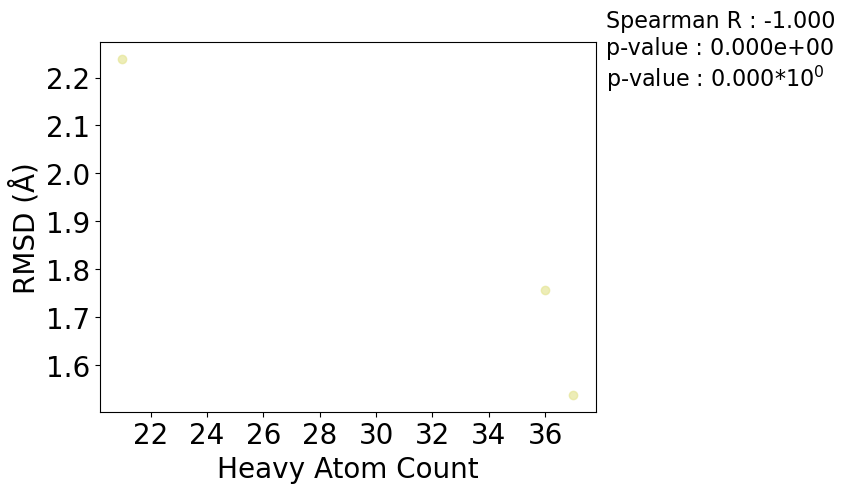

x values plot
0    5
1    4
2    5
Name: Rot_Bonds, dtype: int64
y values plot
0    2.239049
1    1.537123
2    1.756870
Name: RMSD, dtype: float64
Spearman R 3 formats
raw 0.3333333333333332
.3e 3.333e-01
sci. not. 3.333*$10^{-1}$


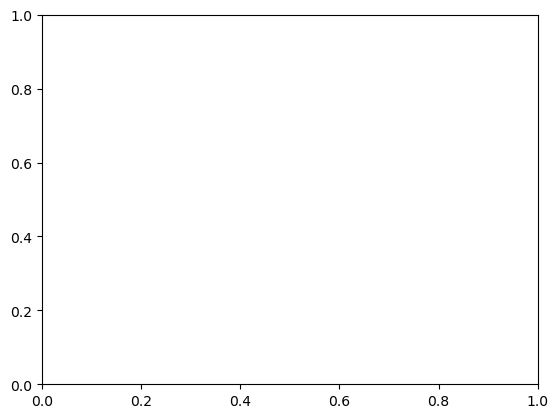

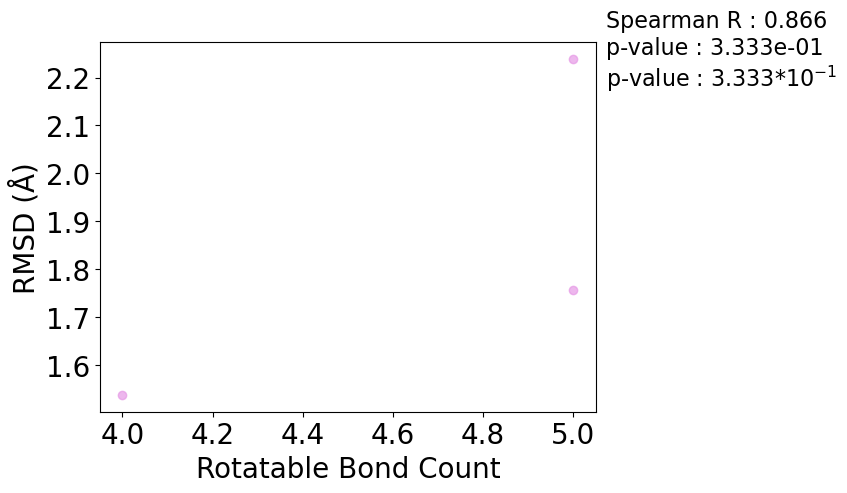

x values plot
0   -5.385337
1   -2.706182
2   -8.618273
Name: Rg_Percent_Error, dtype: float64
y values plot
0    2.239049
1    1.537123
2    1.756870
Name: RMSD, dtype: float64
Spearman R 3 formats
raw 0.6666666666666667
.3e 6.667e-01
sci. not. 6.667*$10^{-1}$


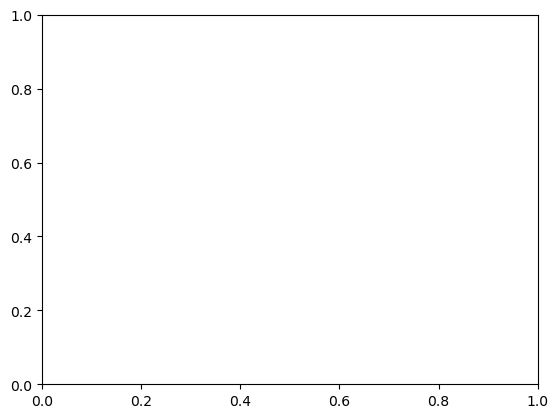

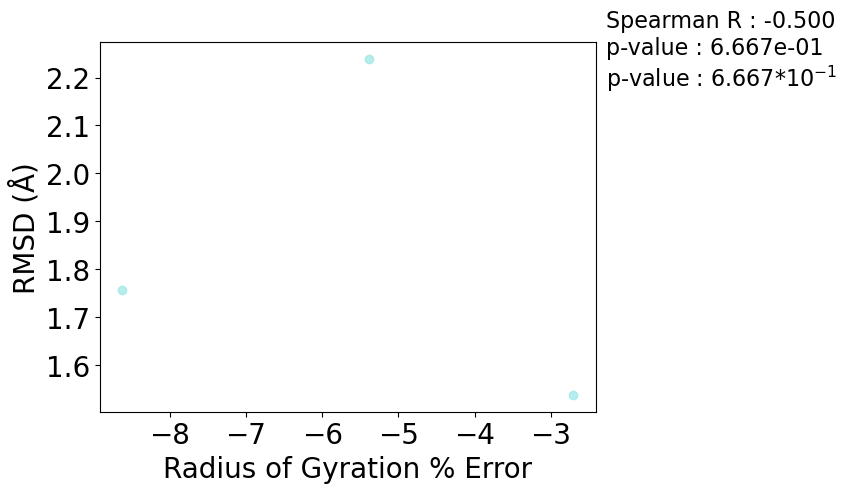

x values plot
0   -5.385337
1   -2.706182
2   -8.618273
Name: Rg_Percent_Error, dtype: float64
y values plot
0    21
1    37
2    36
Name: Heavy_Atom_Count, dtype: int64
Spearman R 3 formats
raw 0.6666666666666667
.3e 6.667e-01
sci. not. 6.667*$10^{-1}$


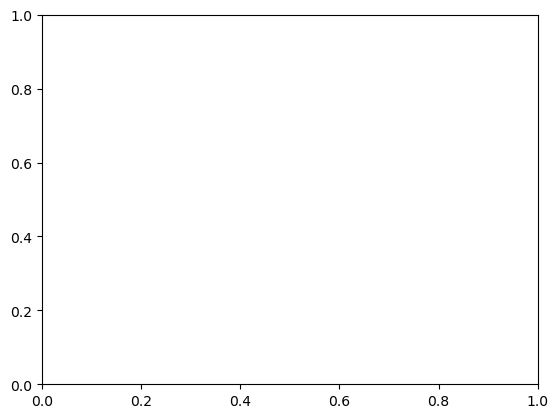

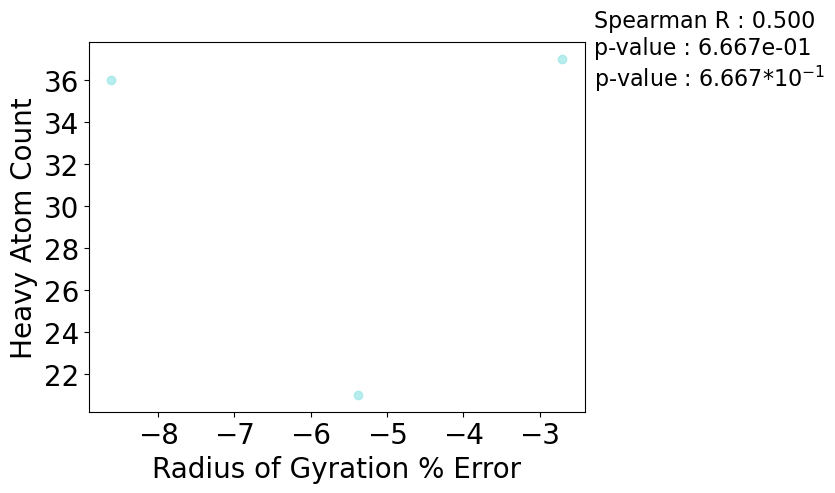

x values plot
0   -21.517381
1   -16.733430
2   -10.238245
Name: Bond_Distance_Percent_Error_Average, dtype: float64
y1 values plot
0   -5.385337
1   -2.706182
2   -8.618273
Name: Rg_Percent_Error, dtype: float64
y2 values plot
0    2.239049
1    1.537123
2    1.756870
Name: RMSD, dtype: float64


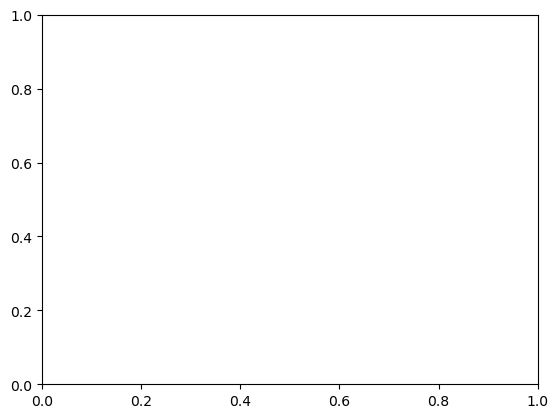

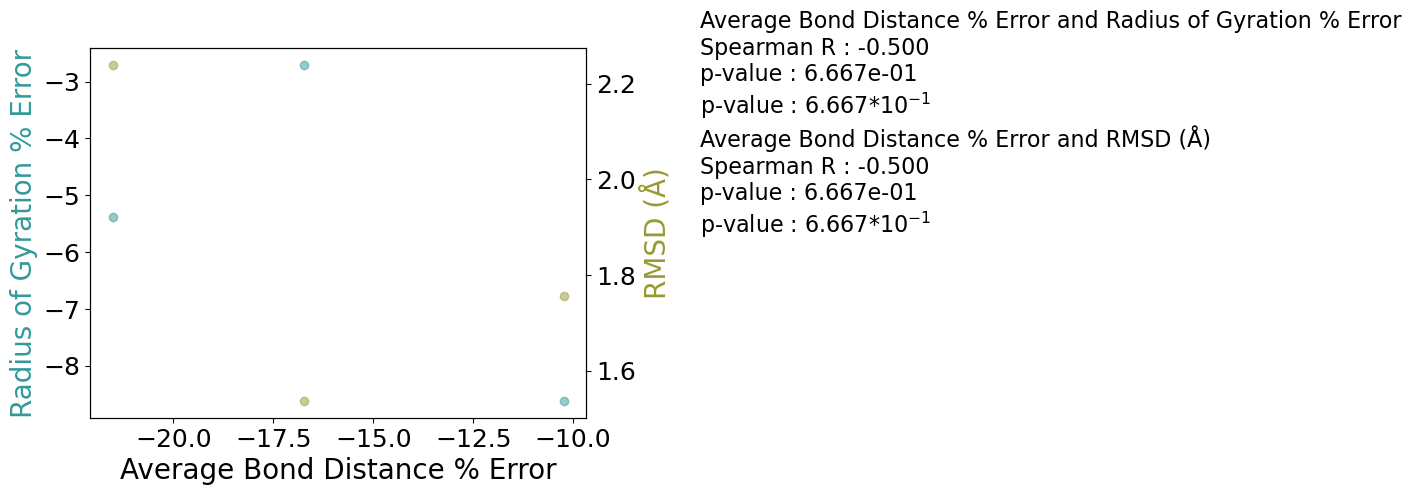

consolidation
len104
[-14.793005113237022, -15.00823463506898, -31.53806193269953, -31.85482032035267, -12.378756328033436, -21.304080148799766, -21.300633233747288, 5.092115589868116, -37.10205980943967, -13.249148782407467, -13.071068992152068, -13.070096104059616, 1.1701509516145374, -11.32573653621703, -18.249628862345762, -15.067100754090848, -20.812383447632964, -18.74810177385318, -52.89607682051507, -33.46432810038927, -62.89394852337647, -19.6876323830356, -41.46534999107442, -39.47457984809717, -18.28003057627538, -8.921244702794441, 0.4864049227824737, -19.45914087357004, -23.042608506099533, -7.413457082940327, -38.929212594271306, 5.392519087523174, -33.749965175508095, -11.167286434401358, -9.474538247624281, -22.40127678857811, -26.23376944225397, -29.30697877663767, 4.364187064277903, -12.169234488586895, 9.399713725007791, -7.696535174629882, 1.3982048416482598, -34.210604176333035, -15.018038474377974, -18.983356743747112, -30.26337484393543, -26.034155075596278, -11.

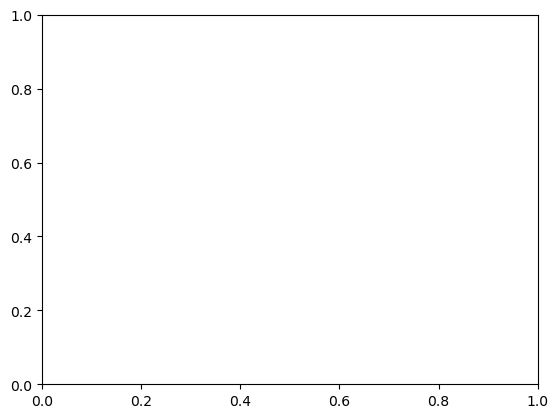

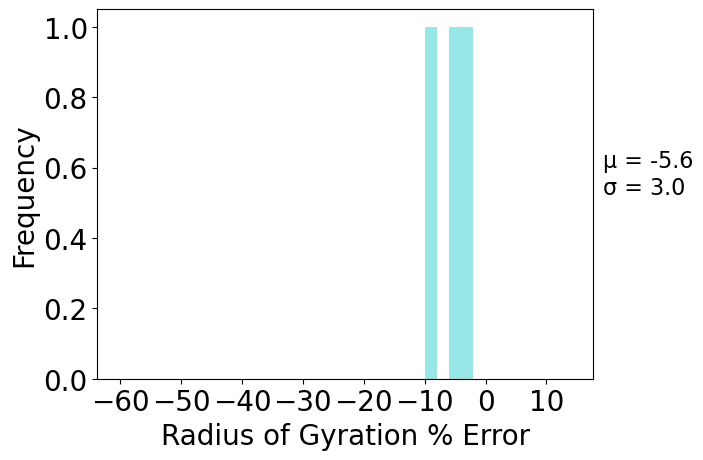

Radius of Gyration % Error has 3 entries, 3 below 0 for 100.0% below
Bond_Distance_Percent_Error_List
where 0?
(array([], dtype=int64),)


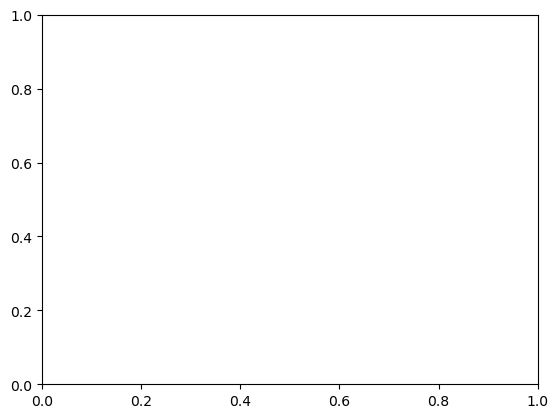

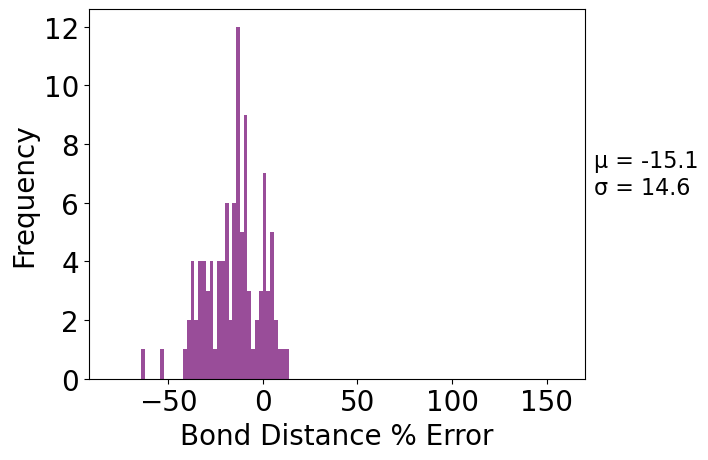

Bond Distance % Error has 104 entries, 84 below 0 for 80.76923076923077% below


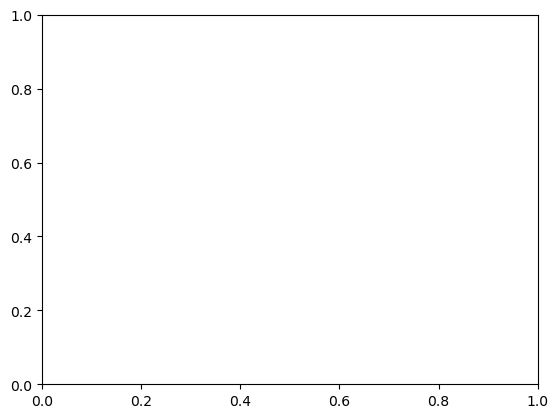

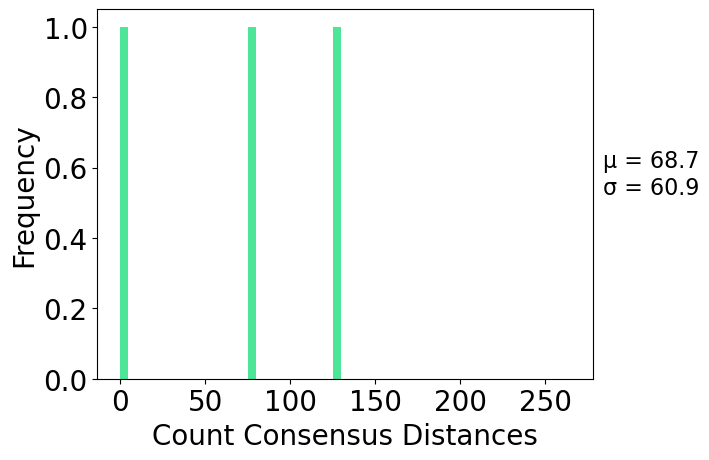

Count Consensus Distances has 3 entries, 0 below 0 for 0.0% below
All_LR_SD
where 0?
(array([], dtype=int64),)


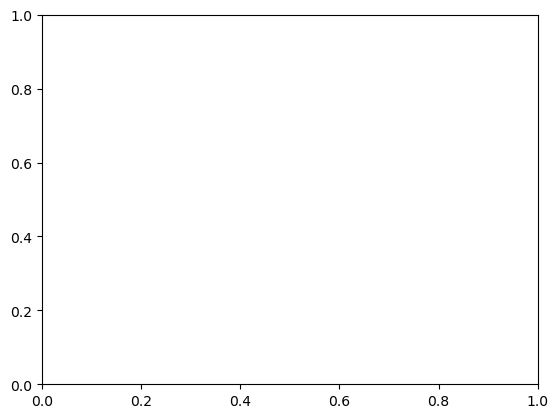

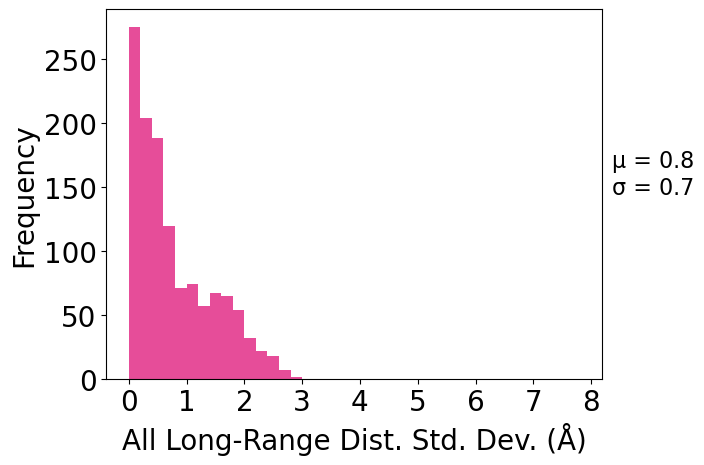

All Long-Range Dist. Std. Dev. (Å) has 1254 entries, 0 below 0 for 0.0% below


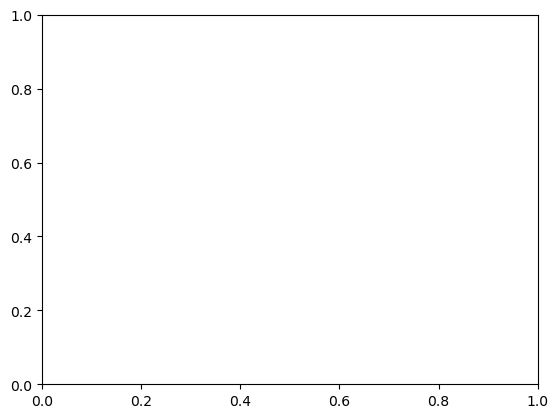

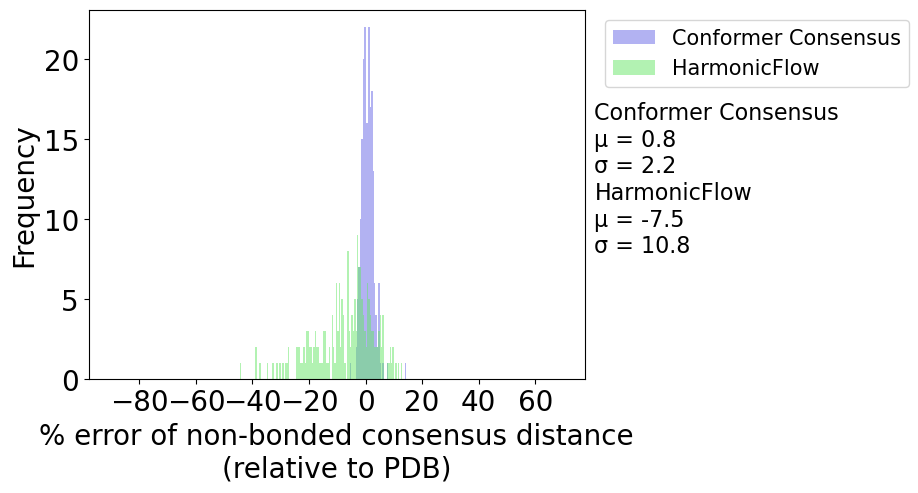

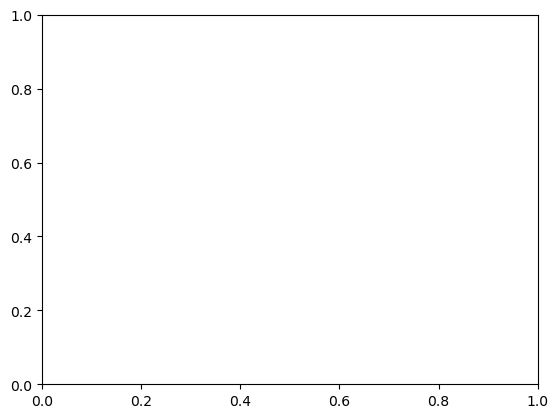

In [92]:
#2/5/24 try for a couple ligands
#This has processed PDBbind data
pdb_dir_check = "/Users/dsharon/Documents/MIT/6.8701/Project/Code/HarmonicFlow/FlowSite/data/PDBBind_processed/"

#I had parsed the _xt.pdb output and placed the 20th set of coordinates for each in a directory
hf_out_dir_check = "/Users/dsharon/Documents/MIT/6.8701/Project/Data/From_Hannes/HarmonicFlow/inference_output_last_xt"

#csv for comparison
#hfcsv = pd.read_csv("/Users/dsharon/Documents/MIT/6.8701/Project/Data/From_Hannes/HarmonicFlow/pred_0.csv")

#Output directory
dir_output_run = "/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/Output/240131/240205_1624"
check_df = run_analysis(pdb_dir_check, 
                        hf_out_dir_check, 
                        dir_output_run,
                        ["6py0", "6nrf", "6iby"])

In [ ]:
print(f"Rg for hist max {max(list_rg_pct_error)} min {min(list_rg_pct_error)}")

sum
2.0
norm sum
[0.25 0.25 0.25 0.25]
sum
2.0
norm sum
[0.   0.75 0.25 0.  ]
TtestResult(statistic=-0.09016696346674372, pvalue=0.9310892067053029, df=6.0)
t test stat 3 formats
raw 0.9310892067053029
.3e 9.311e-01
sci. not. 9.311*$10^{-1}$


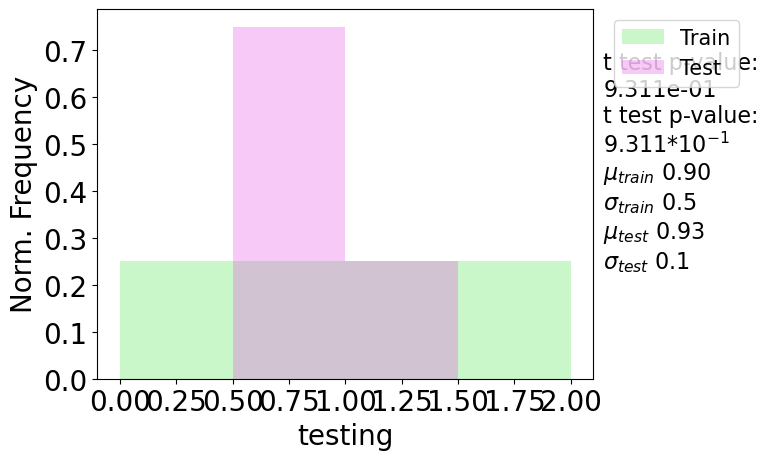

sum
2.0
norm sum
[0.33333333 0.         0.33333333 0.33333333]
sum
2.0
norm sum
[0.   0.75 0.25 0.  ]
TtestResult(statistic=0.07747516350666299, pvalue=0.9412503301599511, df=5.0)
t test stat 3 formats
raw 0.9412503301599511
.3e 9.413e-01
sci. not. 9.413*$10^{-1}$


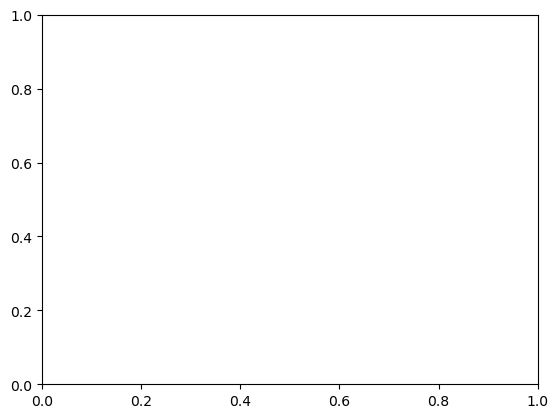

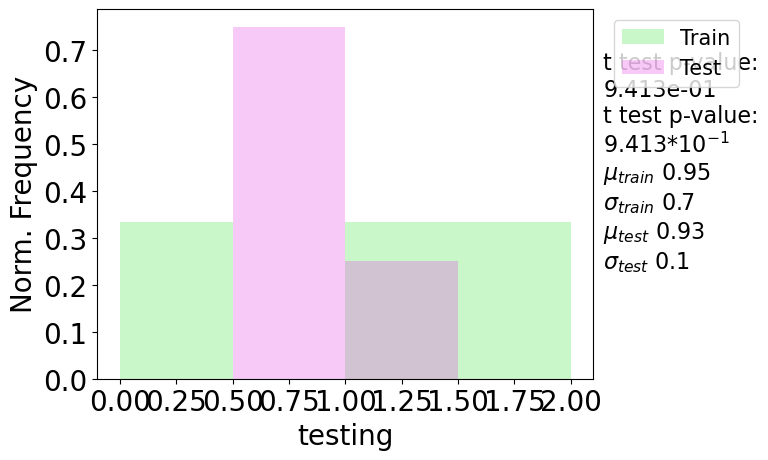

TtestResult(statistic=-0.09016696346674372, pvalue=0.9310892067053029, df=6.0)
TtestResult(statistic=0.07747516350666299, pvalue=0.9412503301599511, df=5.0)


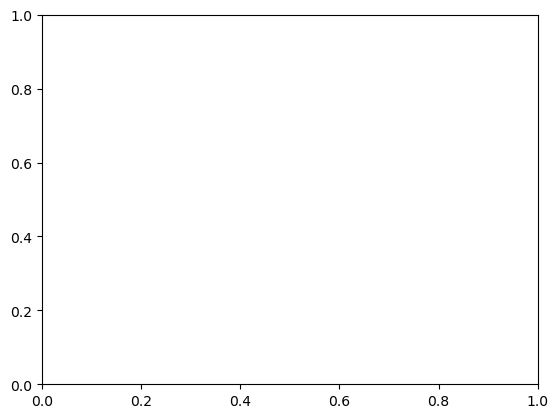

In [127]:
#Check train test histogram
#good, sum to 1 in both cases, and distribution is as expect- train uniform, test 3 in 1 bin 1 in other
#stats avg 0.9, sd 05. agrees. and test avg agrees too
#and t test stats match also good
histogram_train_test([1.05, 0.25, 0.75, 1.55], 
                         [0.8, 0.9, 0.95, 1.05], 
                         "testmetric", 
                         2.5, 
                         0.0, 
                         0.50,
                         "testing",
                         "/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/Output/240205/Tests/1700",
                         "sample_data1")

#Now remove 1 entry good bin goes away
#And stats agree tooo
histogram_train_test([1.05, 0.25, 1.55], 
                         [0.8, 0.9, 0.95, 1.05], 
                         "testmetric", 
                         2.5, 
                         0.0, 
                         0.50,
                         "testing",
                         "/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/Output/240205/Tests/1700",
                         "sample_data2")

print(scipy.stats.ttest_ind([1.05, 0.25, 0.75, 1.55], [0.8, 0.9, 0.95, 1.05]))
print(scipy.stats.ttest_ind([1.05, 0.25, 1.55], [0.8, 0.9, 0.95, 1.05]))

In [ ]:
#Create plots- not removing anything
#Check lists match printed df, good
#2/4/24 confirm all plots up to bd % error match stats, good
#this is comparing with Streamline_Analysis_240201_2050
plot_data(pd_df, [])

In [ ]:
pd_df["Consensus_Distance_Count"].sum()

In [ ]:
print(pd_df[pd_df["Complex_Name"].isin(["6py0", "6nrf", "6qtr", "5zjz"])])
for c_check in ["6py0", "6nrf", "6qtr", "5zjz"]:
    print(c_check)
    print("Conformer_Consensus_Percent_Error")
    print(list(pd_df[pd_df["Complex_Name"] == c_check]["Conformer_Consensus_Percent_Error"]))
    print("Inference_Consensus_Percent_Error")
    print(list(pd_df[pd_df["Complex_Name"] == c_check]["Inference_Consensus_Percent_Error"]))
    print("Consensus_Info_Dict")
    print(dict(pd_df[pd_df["Complex_Name"] == c_check]["Consensus_Info_Dict"]))
    #print("All_LR_SD")
    #print(list(pd_df[pd_df["Complex_Name"] == c_check]["All_LR_SD"]))

In [ ]:
#consensus distance counts- compare with Gen_Conformer_Test_240201_2130
#6py0 has 4, 6nrf has 77, 6qtr has 42, 5zjz has 64 good

#consensus pct errors and inf
#6py0 match  good
#consensus distance pe list- relative to conformers
#[3.51940603026987, 2.8253217493780265, 7.927803111924723, 14.412831402255808]
#consensus distance pe list- relative to inference
#[-2.2602189409821625, -14.382359350074113, 5.060666668057455, 11.875740515355558]

#6nrf match good
#consensus distance pe list- relative to conformers
#[1.9010143855905843, 0.14300409240068349, 0.2495840993683197, -2.751217623018728, -1.7272383796153055, -1.0259911192770443, -0.23148755995362102, -2.7365861171643426, -3.428217525975963, -1.5611083838767883, -0.5144526911693704, 0.4224709714630746, 0.6147357184584455, 0.9316520735418887, 0.11800518266656256, 0.8418546578453824, 2.004391948249912, 1.662490561792671, 2.2742185554446346, -1.4838090217029642, -0.8427479017224279, -0.3947755322809376, -0.14563482818799212, 0.15719379328456187, 0.40550145341271837, 3.403685506587259, -0.6535405785269923, -0.38092543764994385, -0.3671534131019658, -0.16045759768352813, -0.22410056283736163, -0.6183483443744985, -0.6536492483598024, -0.4191570860405378, 1.231791997947726, -0.8000570929816256, -1.3676886141776818, -0.6421133216192504, -1.217017999957538, -0.7851876486131874, -1.5999409635216575, -2.3676676108141645, -5.215213317252442, 0.9860097518120617, -1.3147632484835678, -1.3255081133183384, 1.3676782667480183, -0.6904838259680336, -0.8015219552564081, -1.360381638477304, -1.133941225654004, -0.6262384710859953, -0.14420957441335208, -0.759453349141383, 1.1606766236804726, -0.6898359751442152, 0.793750987236015, 0.6177035315749156, 1.25395547630265, 0.6796489647878622, -0.9063739809069861, -0.8546450268382187, -2.1125531049252193, -2.1120662728914295, -1.3486858260899113, 1.2008581332803638, 0.049727561489157364, -0.8195550531077741, -0.44624588778039825, -1.4805028489345622, -0.1895886713201796, 0.8644812805106391, 2.3339986801082517, 1.1502409488760923, 1.055826696778391, -1.0090354957290386, -2.1967626384474244]
#consensus distance pe list- relative to inference
#[-17.58571850784899, -7.9159349105652375, -7.112135690400866, -19.055522779634817, -10.415406483633149, -6.063339668765588, -10.350244921425201, -8.418016698418816, -37.25553418307519, -17.96896279066257, -9.810668846064427, -1.4949404028200668, 3.5888475912017697, 9.732331537100372, -6.16189114176679, -9.182527956086929, -15.573699937103628, -6.411193080834761, -6.194326961149237, -1.0350208227057374, -4.413901830226865, -2.9513623002313154, -2.933551792879997, -3.4788974679128932, -1.907634810406706, -3.810647861596459, -16.34835296041301, -15.207286015922914, -10.45514885295109, -13.483714557932052, -9.240740909810722, -11.540456197745224, -11.600106146480975, -9.917482116405154, -10.966896009893846, -17.537554744451754, -11.655783906280497, -8.274636773202852, -11.949244540520572, -9.441060929526158, -34.61771240256642, -38.723325101344045, -44.33264674804663, -27.320196650167112, -38.9612350986166, -23.052542245837746, -2.935013342372967, -27.629429935492272, -19.053219751272852, -22.78686110313254, -27.120974560495917, -17.177693956130376, -8.73729011305666, -14.016342991625622, -29.315986025392537, -9.251676876461033, -3.3937832717112886, 1.0790167747597894, 3.4077695755393225, 0.7008983000428046, -6.098823626410947, -16.914220451287115, -8.324556033044889, -8.901007125775608, -11.478419023308762, -20.658051971499816, -7.917233752003187, -32.73664754193038, -31.448259912446893, -10.085852621346891, -5.712494294697797, -4.8617424935535825, -6.253685916961075, -10.133622988506344, -28.37260704245759, -11.345578328371792, -2.512141088195539]

#6qtr match good
#consensus distance pe list- relative to conformers
#[2.1004344379828606, 3.810949323659038, 0.4737233610857225, 1.9742099066170897, 1.2910458804872011, 3.960144024160654, 27.895342939019518, -19.378967891417552, 1.3404924163760323, 2.886584256768848, 26.595727124418673, -20.92689793935693, 7.173370731890907, 1.5260968857071349, 0.07800626948980784, 1.379617178024961, 2.69242403325498, 1.217979901220705, 1.1558495429669997, 0.8232114700980189, 0.6420777836166481, 0.8653978298824837, 0.7246240744339947, 0.7737083636006823, 0.8912805213683493, 0.9298610142535715, 0.40279800259803245, 1.7860350456277267, 1.0423585187539472, 1.2565342188223365, 0.45758300561535714, 0.20138746692846865, 0.31695172146331846, 0.3177765975739739, 0.2112082800364197, -0.028567907819224334, 0.3134055386708859, -0.046097656890445975, 1.072143454326248, 0.0636909949923208, 0.9627399268669264, 0.27581103234730825]
#consensus distance pe list- relative to inference
#[-7.275826116748243, -5.703092570145563, -3.5326548498013333, -24.128600768414046, -10.473941728306505, -29.563979922331793, -13.525324600069883, -50.794064400344624, -14.405363734593257, -20.739174659926526, -35.84190201229298, -37.8153298971022, -13.645271397213866, -8.138948426487639, -25.248407359206105, -19.837665800886388, -33.947103790650715, -32.32465803015197, -23.067521627416625, -31.084142758517284, -37.19585435290956, -26.495150545297935, -29.633746059834493, -33.340624852342785, -34.35314909706843, -53.186183550720976, -26.22051460678698, -31.439553816429704, -19.650032407686584, -24.014742756664933, -27.9581667187905, -28.286898610110853, -32.55467125356307, -27.614187901721678, -25.08523420562228, -26.992410175153296, -19.76629354183534, -23.978662195141034, -34.988060162063704, -25.251277935731828, -41.749814596026134, -29.173969170717502]

#5zjz match good
#how many consensus distances? 64
#consensus distance pe list- relative to conformers
#[-21.013862476685286, 26.898703157178957, -0.04196484384262405, 3.6739363580730036, 0.8838838736838724, 0.41970222500373, 1.5081409622646953, 0.4958238424522645, 0.8287738582966451, -0.027990928702799726, 0.5257416302786297, 0.10874022719858742, 1.7988086036316357, 0.14339346338192416, 0.4402425494465754, 0.1420961415266551, -0.23926360055628929, 0.021806160327594293, -0.4475967227656975, 0.702541518362029, -0.45665569179843046, 0.48519587907462397, -0.09933377082757018, 1.0956006703115766, -0.060469469213072106, 0.7651944873189229, 0.9605582700196181, -20.650277990689204, 28.52795103128406, -6.963208821871123, 8.908776913572291, 3.3967473760889226, 2.173526942653649, 6.208335155907042, -1.0013740986619688, 0.22735959657943763, -1.2727966223902198, -0.5469635769565556, 0.21901930098352926, -0.09200555083733139, 0.12270387293471423, 0.6700120506339922, 0.4767081880972493, 1.8086125186363056, -6.377373250224554, -0.6131888538726897, -0.5164411719339161, 0.45981886421287743, -0.342126325427873, 0.4618101623420516, 0.07684244395428151, -0.349614496289518, 0.4376993280653283, 0.20236935010771087, 0.7947410149526298, 0.2531432318509162, 0.9030712644211024, 0.8421077431084136, 0.2839165247831089, -0.19557107166204601, 0.27418543712950544, 0.6143258355478719, 0.15440446632644192, -0.7293196909775355]
#consensus distance pe list- relative to inference
#[-36.33602380789821, -12.82754744444976, -15.325166923909576, -35.90675603774521, 0.16549932214408702, -13.261045515026332, 33.663009386040954, 13.063545314025797, -33.28314363629198, -41.26136235192126, -27.4651864552136, -31.967940201573523, -9.929342093854906, -38.26211590795465, -38.35312957159185, -36.55036857090542, -39.415558170707584, -24.86123178810595, -31.85389003204931, -55.01947069820203, -36.36601576510179, -61.1263785678478, -48.84030297514698, -28.14255308371576, -34.40284218416582, 28.258344213982493, 12.903119560941594, -20.176262327274245, -7.186304781331557, -38.00594501392774, -46.32407891402858, -16.0196358715567, -14.162434399331236, 6.1425172254509235, 0.6195950908999571, -20.79079576324634, -8.502614554608986, -11.367017891689601, -10.714287935139179, -7.2724748563447505, -3.3951940185536102, -46.90515278335021, -44.860854837817364, -13.462661776670211, -12.97573055197857, -14.809810937058442, -2.962175135204015, 4.8026749929727695, -6.655449249368707, -7.555082837714914, -8.50492437073128, -11.886500416781132, -24.568228029088633, -18.537177894542697, -50.76948813821276, -23.56667578906096, -43.22271469441802, -33.48842507326569, -26.876163447727187, -59.2377175521242, -51.925295567779074, -42.245355186045806, -47.307058825269365, -42.42364615884291]

#compare consensus dictionaries- 1st couple entries
#6py0 match good
#{(0, 3): {'pdb': 2.8828966335961472, 'conformers': 2.984357471565377, 'pdb_conf_pe': 3.51940603026987, 'inf': 2.81773685783467, 'pdb_inf_pe': -2.2602189409821625}, (2, 5): {'pdb': 2.8475861707769257, 'conformers': 2.928039642192167, 'pdb_conf_pe': 2.8253217493780265, 'inf': 2.438036094892773, 'pdb_inf_pe': -14.382359350074113}, (6, 9): {'pdb': 3.3917300894970985, 'conformers': 3.6606197730803367, 'pdb_conf_pe': 7.927803111924723, 'inf': 3.5633742436067535, 'pdb_inf_pe': 5.060666668057455}, (8, 11): {'pdb': 3.215300608030297, 'conformers': 3.6787164637414094, 'pdb_conf_pe': 14.412831402255808, 'inf': 3.5971413650286244, 'pdb_inf_pe': 11.875740515355558}}

#6nrf match good
#6nrf consensus distances dictionary
#{(0, 4): {'pdb': 2.8549497368605277, 'conformers': 2.909222742059627, 'pdb_conf_pe': 1.9010143855905843, 'inf': 2.35288631259566, 'pdb_inf_pe': -17.58571850784899}, (0, 5): {'pdb': 6.532755850328405, 'conformers': 6.54209795854092, 'pdb_conf_pe': 0.14300409240068349, 'inf': 6.015627149350266, 'pdb_inf_pe': -7.9159349105652375}
#(24, 27): {'pdb': 2.779696026546788, 'conformers': 2.751647906965561, 'pdb_conf_pe': -1.0090354957290386, 'inf': 2.4643234365642837, 'pdb_inf_pe': -11.345578328371792}, (32, 34): {'pdb': 3.0819339707398017, 'conformers': 3.0142311967289706, 'pdb_conf_pe': -2.1967626384474244, 'inf': 3.004511441149791, 'pdb_inf_pe': -2.512141088195539}}
 

#6qtr match good
#6qtr consensus distances dictionary
#{(1, 10): {'pdb': 3.7865072296246858, 'conformers': 3.8660403314724334, 'pdb_conf_pe': 2.1004344379828606, 'inf': 3.5110075476990925, 'pdb_inf_pe': -7.275826116748243}, (3, 10): {'pdb': 2.7540588229012126, 'conformers': 2.8590146089857384, 'pdb_conf_pe': 3.810949323659038, 'inf': 2.5969922987948952, 'pdb_inf_pe': -5.703092570145563}
#(88, 89): {'pdb': 2.7638959821237816, 'conformers': 2.790505112280758, 'pdb_conf_pe': 0.9627399268669264, 'inf': 1.609974533960087, 'pdb_inf_pe': -41.749814596026134}, (88, 92): {'pdb': 3.640366053022686, 'conformers': 3.650406584214749, 'pdb_conf_pe': 0.27581103234730825, 'inf': 2.578326783012582, 'pdb_inf_pe': -29.173969170717502}}

#5zjz match good
#{(1, 4): {'pdb': 3.577998602570995, 'conformers': 2.8261228968090046, 'pdb_conf_pe': -21.013862476685286, 'inf': 2.277896178494533, 'pdb_inf_pe': -36.33602380789821}, (2, 4): {'pdb': 2.996462414247838, 'conformers': 3.802471944272802, 'pdb_conf_pe': 26.898703157178957, 'inf': 2.612089776405092, 'pdb_inf_pe': -12.82754744444976},
#end (124, 127): {'pdb': 2.7621185709523766, 'conformers': 2.766383405391159, 'pdb_conf_pe': 0.15440446632644192, 'inf': 1.4554415137682462, 'pdb_inf_pe': -47.307058825269365}, (125, 126): {'pdb': 2.84674586150573, 'conformers': 2.825983983385681, 'pdb_conf_pe': -0.7293196909775355, 'inf': 1.6390524701790352, 'pdb_inf_pe': -42.42364615884291}}

#LR SD lists
#6py0
#all pair sd list match
#[0.07199367117749465, 0.17702076411884635....1.0487080521766985, 0.6879352118856541]
#6nrf
#all pair sd list match
#[0.12080109229704707, 0.5930793281189362,...0.39101373616056967, 0.3854277672672214]
#6qtr
#all pair sd list match
#[0.41011121984938037, 0.3353980543288988,...1.1247230645916113, 1.2177365593458067]
#5zjz
#all pair sd list match
#[0.282095228994756, 0.4529594208251584,...1.1514442363404487, 1.125102147315403]

In [ ]:
#Create plots- with removal
#points align with removal, last entries match up- good
remove_list = ['6qsz', '6a6k', '6kqi', '6m7h', '6qtm', '6e4v', '6iql', '6rz6', '6nv9', '6qzh', '5ab1', '4jdf', '1qon', '4pox', '2r23', '4po7', '4nw2', '2w73', '4x6h', '1g6g', '4u6x', '2r23', '4po7', '4nw2', '2w73', '4x6h', '1g6g', '4u6x']
plot_data(pd_df, remove_list)

In [ ]:
#This is from 2/4 check consensus plots
#Create a sample dataframe to check plotting
#look good, just a bit funny about spearman r pvalue, try in cell below
#Bond_Distance_Percent_Error_List 14 entries good, 6 below 0 good, peaks at -5 and 10 good
#And summary stats match: list consolidation was successful, also confirm with exclusion
#2 y. scatter- RMSD series has (1,1), (5,2), (-4, 3), (2, 4), (-3, 5), (0, 6), and (-1,7) -good
#And Rg pe series has (1,3), (5,2), (-4,1), (2,0), (-3,-1), (0, -2), (-1, -3)
#spearman R matches
#Also with exclusions
#rmsd series (2, 4), (-3, 5), (0, 6), and (-1,7) and rg series (2,0), (-3,-1), (0, -2), (-1, -3)
#consensus avg good, bin pattern of 2 then 1 then 2 then 1 is good
#LR SD 3 in 1st bin then 1 a bit over 2, 1 under 3, then 2 over 3 1 each in next 2 bins and 2 over 4 good
#and sd and avg match good
#conformer consensus see 2 just below 0 2 each just above 0 and right larger 1 bit below, 1 each above/below 2 and near 7, 1 at 10 1 at. -15
#HF see 2 at -5/-4/-3, also -20 and -30 and -17 and -23.4 plus 7 and 12
#consensus avg and sd match, so do hf
#exclusions a b look good, stats good
test_df_dict = {
                "Complex_Name" : ["a", "b", "c", "d", "e", "f", "g"],
                "RMSD" : [1, 2, 3, 4, 5, 6, 7],
                "Heavy_Atom_Count" : [1, 2, 3, 4, 5, 6, 7],
                "Rot_Bonds" : [2, 2, 2, 2, 2, 2, 1],
                "Rg_Percent_Error" : [3, 2, 1, 0, -1, -2, -3],
                "Bond_Distance_Percent_Error_List" : [[-5, 10], [-1, 20], [-30, -20], [40, 50], [-5, 10], [-5, 10], [5, 15]],
                "Bond_Distance_Percent_Error_Average" : [1, 5, -4, 2, -3, 0, -1],
                "Consensus_Distance_Count": [2, 3, 11, 21, 22, 34, 101], 
                "Conformer_Consensus_Percent_Error" : [[-0.5, -0.2], [0.2, 0.6, 0.2, 0.6], [-1.5], [1.55, 6.96], [2.03], [10.03], [-15.02]],
                "Inference_Consensus_Percent_Error" : [[-5.05, -5.10], [-4.05, -4.10, -3.05, -3.10], [-20.5], [-17.2, -23.4], [7.03], [12.02], [-30.1]],
                "All_LR_SD" : [[0.12, 0.15], [0.13], [4.03, 4.04], [3.02, 3.07], [3.42, 3.39], [2.03], [2.95]]
               }
#Ref https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
pd_test_df = pd.DataFrame(data = test_df_dict)
plot_data(pd_test_df, [])
print("++++++++++++++++++++++++++++++++++++\nWITH REMOVALS")
plot_data(pd_test_df, ["a", "b"])
print("++++++++++++++++++++++++++++++++++++\nWITH 3 REMOVALS")
plot_data(pd_test_df, ["a", "b", "c"])

In [ ]:
#Below from 2/1
#Create a sample dataframe to check plotting
#look good, just a bit funny about spearman r pvalue, try in cell below
#Bond_Distance_Percent_Error_List 14 entries good, 6 below 0 good, peaks at -5 and 10 good
#And summary stats match: list consolidation was successful, also confirm with exclusion
#2 y. scatter- RMSD series has (1,1), (5,2), (-4, 3), (2, 4), (-3, 5), (0, 6), and (-1,7) -good
#And Rg pe series has (1,3), (5,2), (-4,1), (2,0), (-3,-1), (0, -2), (-1, -3)
#spearman R matches
#Also with exclusions
#rmsd series (2, 4), (-3, 5), (0, 6), and (-1,7) and rg series (2,0), (-3,-1), (0, -2), (-1, -3)
test_df_dict = {
                "Complex_Name" : ["a", "b", "c", "d", "e", "f", "g"],
                "RMSD" : [1, 2, 3, 4, 5, 6, 7],
                "Heavy_Atom_Count" : [1, 2, 3, 4, 5, 6, 7],
                "Rot_Bonds" : [2, 2, 2, 2, 2, 2, 1],
                "Rg_Percent_Error" : [3, 2, 1, 0, -1, -2, -3],
                "Bond_Distance_Percent_Error_List" : [[-5, 10], [-1, 20], [-30, -20], [40, 50], [-5, 10], [-5, 10], [5, 15]],
                "Bond_Distance_Percent_Error_Average" : [1, 5, -4, 2, -3, 0, -1]
               }
#Ref https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
pd_test_df = pd.DataFrame(data = test_df_dict)
plot_data(pd_test_df, [])
print("++++++++++++++++++++++++++++++++++++\nWITH REMOVALS")
plot_data(pd_test_df, ["a", "b"])
print("++++++++++++++++++++++++++++++++++++\nWITH 3 REMOVALS")
plot_data(pd_test_df, ["a", "b", "c"])

In [ ]:
print(scipy.stats.spearmanr([1,2,3,4,5,6,7,8], [1,2,3,4,5,6,7,8]))
print(scipy.stats.spearmanr([1,2,3,4,5,6,7], [1,2,3,4,5,6,7]))
print(scipy.stats.spearmanr([1,2,3,4,5,6], [1,2,3,4,5,6]))
print(scipy.stats.spearmanr([1,2,3,4,5], [1,2,3,4,5]))
print(scipy.stats.spearmanr([1,2,3,4], [1,2,3,4]))
print(np.average([-5, 10, -1, 20, -30, -20, 40, 50, -5, 10, -5, 10, 5, 15]))
print(np.std([-5, 10, -1, 20, -30, -20, 40, 50, -5, 10, -5, 10, 5, 15], ddof = 1))
print(np.average([40, 50, -5, 10, -5, 10, 5, 15]))
print(np.std([40, 50, -5, 10, -5, 10, 5, 15], ddof = 1))
print(scipy.stats.spearmanr([1, 5, -4, 2, -3, 0, -1], [1, 2, 3, 4, 5, 6, 7]))
print(scipy.stats.spearmanr([1, 5, -4, 2, -3, 0, -1], [3, 2, 1, 0, -1, -2, -3]))
print(scipy.stats.spearmanr([2, -3, 0, -1], [4, 5, 6, 7]))
print(scipy.stats.spearmanr([2, -3, 0, -1], [0, -1, -2, -3]))

In [ ]:
print(pd_df)

#Spot checks:
#(a) Heavy_atom_count 
#(i) 6iby is 36, pymol select noth, not elem H get 36
#(ii) 6mjj is 69, pymol select noth, not elem H get  69
#(iii) 6qfe is 30, pymol select noth, not elem H 30
#(b) Rot_Bonds 
#(i) 6iby exlcuding amide bond 5 makes sense
#(ii) 6qfe 8 looks reasonable
#(iii) 6jbe 1 looks reasonable
#(c) Rg percent error
#(i) 6iby 100.0 * (4.696354 - 5.139271) / 5.139271 = -8.617
#(ii) 6mjj 100.0 * (7.873698 - 8.908885) / 8.908885 = -11.6197
#(iii) 6qfe 100.0 * (4.008217 - 4.579058) / 4.579058 = -12.466
#(d) Rg_PDB
#run pymol cmd
#(i) 6mjj 8.90887 match
#(ii) 6hlb 6.95864 match
#(iii) 6jbe got 2.33903 match
#(e) Rg_Inf
#(i) 6mjj 7.87368 match
#(ii) 6hlb 5.58761 match
#(iii) 6qfe 4.00822 match

#Check a few individual entries
#See. /Users/dsharon/Documents/MIT/6.8701/Project/Analysis/Output/240131/Check_bond_pct_error_240131_1930.pse
#Do label- atom properties- id
#6py0 spot check
#21 bonds looks right
#1 2 distance (1 indexed) is 1.5283 in pdb, 1.3022 in inference pose. PE: 100 * (1.3022 - 1.5283) / 1.5283=-14.79 good
#13 21 distance is 1.4828 in pdb, 0.6984 in inference pose. PE: 100 * (0.6984 - 1.4828) / 1.4828 = -52.90 good
#7 8 distance is 1.312 in pdb, 1.1411 in inference pose. PE: 100 * (1.1411- 1.312) / 1.312 = -13.03 good
#And average check matches, good
#6qre spot check
#18 bonds looks right
#2 3 distance pdb 1.3631 inference pose 1.3045 PE (100 * (1.3045 - 1.3631)) / 1.3631 = -4.299 good
#4 17 distance pdb 1.3970 inference pose 1.2403 PE (100 * (1.2403 - 1.3970)) / 1.3970 = -11.217 good
#11 12 distance pdb 1.4543 inference pose 1.2618 PE (100 * (1.2618 - 1.4543)) / 1.4543 = -13.237 good
#And average check matches, good
#6inz spot check
#27. bonds looks right
#0 1 1.4901 distance pdb inf 1.5349 PE 100 * (1.5349 - 1.4901) / 1.4901 = 3.007 good
#18 26 1.2427 distance pdb inf 0.8112 100 * (0.8112 - 1.2427) / 1.2427 = -34.723 good
#4 5 1.3441 distance pdb inf 1.2203 100 * (1.2203 - 1.3441) / 1.3441 = -9.211 good
#And average check matches, good
#Ref https://saturncloud.io/blog/how-to-get-a-list-from-a-pandas-dataframe-column/
#Ref https://stackoverflow.com/questions/40410416/extract-list-from-pandas-cell-and-use-list-elements-as-new-column
for p_check in ["6py0", "6qre", "6inz"]:
    print("******************")
    print(f"{p_check} bond dist pe list")
    list_p_check = pd_df[pd_df["Complex_Name"] == p_check]["Bond_Distance_Percent_Error_List"].tolist()
    print(list_p_check)
    print("list length")
    print(len(list_p_check[0]))
    print(f"{p_check} bond dist pe dict")
    dict_p_check = pd_df[pd_df["Complex_Name"] == p_check]["Bond_Distance_Percent_Error_Dict"].tolist()
    print(dict_p_check)
    print(dict_p_check[0])
    print("dict length")
    print(len(list(dict_p_check[0].keys())))
    print("average")
    print(pd_df[pd_df["Complex_Name"] == p_check]["Bond_Distance_Percent_Error_Average"])

In [ ]:
#check averages
print("6py0")
print(np.average([-14.793005113237022, -12.378756328033436, -21.304080148799766, -21.300633233747288, 5.092115589868116, -15.00823463506898, -13.249148782407467, -13.071068992152068, -13.070096104059616, 1.1701509516145374, -18.249628862345762, -15.067100754090848, -20.812383447632964, -18.74810177385318, -33.46432810038927, -62.89394852337647, -31.53806193269953, -31.85482032035267, -37.10205980943967, -11.32573653621703, -52.89607682051507]))
print("6qre")
print(np.average([-4.29584755380543, -48.85474909818387, -28.162671689191956, -27.965468074581306, -15.09616406784059, -24.803324550539436, -27.071447157509752, -2.8641083831379115, -13.233709561173198, -19.498277281940684, -10.897159330393917, -34.526347883181685, -33.12381580892355, -49.54993933199187, -1.960128905177158, -33.623490189995515, -32.34420984758027, -11.213051146220055]))
print("6inz")
print(np.average([3.007775068767706, -10.62922214419955, -11.27549268592031, -9.205881629270785, -3.3802801986541007, -16.96548141485752, -20.672615355408862, -13.286545433916222, -6.790318434492094, -49.367002911730275, -36.45856967871213, -14.298440220252472, -8.0534883700856, -8.097946097608244, -10.688158940235033, -0.6066654708201425, -20.243450412792974, -17.6875408466208, -10.829942931965688, -23.130038595388907, -8.447648450914699, -7.390489224798162, -40.613540538174504, -10.1188559447668, -9.626552873586133, -44.37490693595686, -34.72494376557915]))

In [ ]:
#Tests
#Expect for 1st- square root of 2/2, giving 1
#Expect for 2nd- square root of 0.5, giving 0.77
print(rmsd_calc_no_torch(np.array([[0, 1, 0], [0, 1, 0]]), np.array([[0, 0, 0], [0, 0, 0]])))
print(rmsd_calc_no_torch(np.array([[0, 1, 0], [0, 0, 0]]), np.array([[0, 0, 0], [0, 0, 0]])))

In [ ]:
csv_with_h_for_calc = pd.read_csv("/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/RMSD_and_Chem_Feats/Docking_analyze_240123_1745/HF_240123_1745_Driver_Data.csv")

In [ ]:
csv_with_h_for_calc[csv_with_h_for_calc["names"] == "6iby"]
#Rgbit diff, rg pct error bit diff
#Rg + Rg_Inf_Minus_PDB = 5.234467-0.538112=4.696, matches. So the change is due to Hs